# Aula8: Pandas & Matplotlib (Cont...) & Econometria

In [217]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
os.chdir("/Users/gustavorsampaio/Documents/Cursos/Python 2023.2/aula6/")

In [219]:
countries = pd.read_pickle("countries.pkl")
leagues = pd.read_pickle("leagues.pkl")
matches = pd.read_pickle("matches.pkl")
teams = pd.read_pickle("teams.pkl")
player = pd.read_pickle("player.pkl")
player_attributes = pd.read_pickle("player_attributes.pkl")
sequence = pd.read_pickle("sequence.pkl")
team_attributes = pd.read_pickle("team_attributes.pkl")
lat_long = pd.read_pickle("lat_long.pkl")

Realizar todas as construções que fizemos nas aulas passadas

In [220]:
#os.environ['PROJ_LIB'] = '/Users/gustavorsampaio/anaconda3/share/proj'
#from mpl_toolkits.basemap import Basemap
import seaborn as sns
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

In [221]:
countries_leagues = countries.merge(leagues,left_on="id",right_on="id",how="outer", indicator=True)
countries_leagues = countries_leagues.drop("id",axis = 1)
countries_leagues = countries_leagues.rename(columns={'name_x':"country", 'name_y':"league"})
matches_new = matches[['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                       'match_api_id', 'home_team_api_id', 'away_team_api_id',
                       'home_team_goal', 'away_team_goal']]
matches_new = matches_new.drop("id",axis=1)
data = matches_new.merge(countries_leagues,left_on="country_id",right_on="country_id",how="outer")
country_info  = countries_leagues.merge(lat_long,left_on="country",right_on="name",how="left")
country_info  = country_info.drop(["country_id","country_y","name"],axis = 1)

data["date"] = pd.to_datetime(data["date"],format="%Y-%m-%d")
data["year"] = pd.DatetimeIndex(data["date"]).year
data = data.merge(teams,left_on="home_team_api_id",right_on="team_api_id",how="left") # use only keys from left frame
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"home_team_lname",'team_short_name':"home_team_sname"})
data = data.merge(teams,left_on="away_team_api_id",right_on="team_api_id",how="left")
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"away_team_lname",'team_short_name':"away_team_sname"})
h_t = data.groupby("home_team_lname")["home_team_goal"].sum().reset_index()
a_t = data.groupby("away_team_lname")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)
x = h_t
x = x.rename(columns={'home_team_lname':"team", 'home_team_goal':"goals"})
y = a_t
y = y.rename(columns={'away_team_lname':"team", 'away_team_goal':"goals"})
goals = pd.concat([x,y])
goals = goals.groupby("team")["goals"].sum().reset_index().sort_values(by = "goals",ascending = False)
x = data.groupby("home_team_lname")["match_api_id"].count().reset_index()
x = x.rename(columns={"home_team_lname":"team"})
y = data.groupby("away_team_lname")["match_api_id"].count().reset_index()
y = y.rename(columns={"away_team_lname":"team"})
xy = pd.concat([x,y],axis=0)
match_teams =  xy.groupby("team")["match_api_id"].sum().reset_index().sort_values(by="match_api_id",ascending =False)
match_teams = match_teams.rename(columns={"match_api_id":"matches_played"})
ts = list(goals["team"][:50])
v = data[["home_team_lname","away_team_lname"]]
v = v[(v["home_team_lname"].isin(ts)) & (v["away_team_lname"].isin(ts))]
x = data.groupby(["home_team_lname","league"]).agg({"match_api_id":"count","home_team_goal":"sum"}).reset_index()
y = data.groupby(["away_team_lname","league"]).agg({"match_api_id":"count","away_team_goal":"sum"}).reset_index()
x = x.rename(columns={'home_team_lname':"team", 'match_api_id':"matches", 'home_team_goal':"goals"})
y = y.rename(columns={'away_team_lname':"team", 'match_api_id':"matches", 'away_team_goal':"goals"})
xy = pd.concat([x,y])
xy = xy.groupby(["team","league"])[["matches","goals"]].sum().reset_index()
xy = xy.sort_values(by="goals",ascending=False)
data["total_goal"] = data["home_team_goal"]+data["away_team_goal"]
a = data.groupby("season").agg({"total_goal":"sum"})
m = data.groupby("season").agg({"total_goal":"mean"})
s = data.groupby("season").agg({"total_goal":"std"})
x = data.groupby("season").agg({"total_goal":"max"})
xx = a.merge(m,left_index=True,right_index=True,how="left")
yy = s.merge(x,left_index=True,right_index=True,how="left")
x_y = xx.merge(yy,left_index=True,right_index=True,how="left").reset_index()
x_y = x_y.rename(columns={'total_goal_x_x':"goals", 'total_goal_y_x':"mean",
                          'total_goal_x_y':"std",'total_goal_y_y':"max"})

### Criar novas colunas na base

Time Vencedor

In [222]:
def label(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] > data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["win"] = data.apply(lambda data:label(data),axis=1)

Outcome do jogo

In [223]:
def lab(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return "HOME TEAM WIN"
    elif data["away_team_goal"] > data["home_team_goal"]:
        return "AWAY TEAM WIN"
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["outcome_side"] = data.apply(lambda data:lab(data),axis = 1)

Time Perdedor

In [224]:
def labe(data):
    if data["home_team_goal"] < data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] < data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["lost"] = data.apply(lambda data:labe(data),axis = 1)

In [9]:
data.head()

country_id  league_id     season  stage       date  match_api_id  \
0           1          1  2008/2009      1 2008-08-17        492473   
1           1          1  2008/2009      1 2008-08-16        492474   
2           1          1  2008/2009      1 2008-08-16        492475   
3           1          1  2008/2009      1 2008-08-17        492476   
4           1          1  2008/2009      1 2008-08-16        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  ...  \
0              9987              9993               1               1  ...   
1             10000              9994               0               0  ...   
2              9984              8635               0               3  ...   
3              9991              9998               5               0  ...   
4              7947              9985               1               3  ...   

  _merge  year    home_team_lname  home_team_sname    away_team_lname  \
0   both  2008           KRC Genk              GEN       Beerschot AC   
1   both  2008   SV Zulte-Waregem              ZUL   Sporting Lokeren   
2   both  2008  KSV Cercle Brugge              CEB     RSC Anderlecht   
3   both  2008           KAA Gent              GEN          RAEC Mons   
4   both  2008      FCV Dender EH              DEN  Standard de Liège   

  away_team_sname total_goal                win   outcome_side  \
0             BAC          2               DRAW           DRAW   
1             LOK          0               DRAW           DRAW   
2             AND          3     RSC Anderlecht  AWAY TEAM WIN   
3             MON          5           KAA Gent  HOME TEAM WIN   
4             STL          4  Standard de Liège  AWAY TEAM WIN   

                lost  
0               DRAW  
1               DRAW  
2  KSV Cercle Brugge  
3          RAEC Mons  
4      FCV Dender EH  

[5 rows x 22 columns]

### Proporção dos jogos por outcome

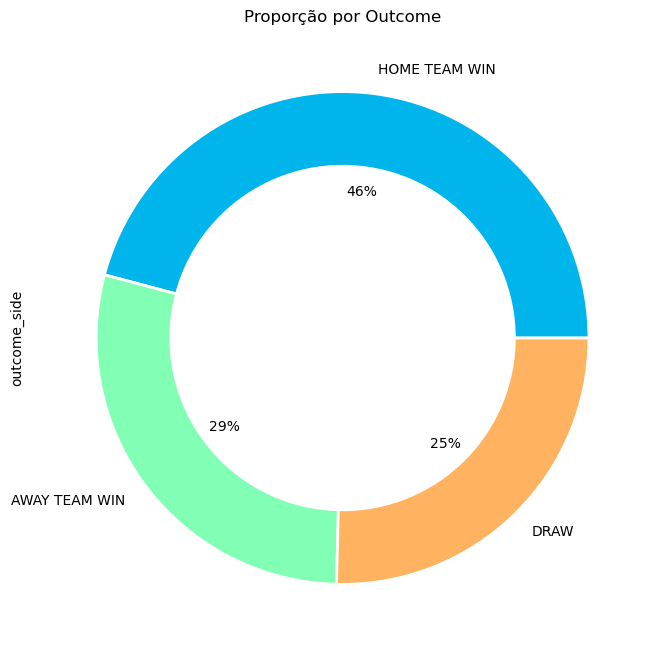

In [10]:
plt.figure(figsize=(8,8))
data["outcome_side"].value_counts().plot.pie(autopct = "%1.0f%%", # Mostrar o valor percentual
                                             colors =sns.color_palette("rainbow",3),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white") # Experimenta tirar essa linha do plot
plt.gca().add_artist(my_circ)
plt.title("Proporção por Outcome")
plt.show()

In [228]:
win = data["win"].value_counts()[1:].reset_index()
lost = data["lost"].value_counts()[1:].reset_index()

#### Juntar win,draw e lost dos times com of jogos

In [229]:
f = xy.merge(win,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
f = f.rename(columns={"outcome":"wins"})
f = f.merge(lost,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
dr = data[data["outcome_side"] == "DRAW"][["home_team_lname","away_team_lname"]]
l  = dr["home_team_lname"].value_counts().reset_index()
v  = dr["away_team_lname"].value_counts().reset_index()
l  = l.rename(columns={'index':"team", 'home_team_lname':"draw"})
v  = v.rename(columns={'index':"team", 'away_team_lname':"draw"})
lv = pd.concat([l,v])
lv = lv.groupby("team")["draw"].sum().reset_index()
f = f.merge(lv,left_on="team",right_on="team",how ="left")

In [230]:
f.head()

team                   league  matches  goals  win  lost  draw
0      FC Barcelona          Spain LIGA BBVA      304    849  234    27    43
1    Real Madrid CF          Spain LIGA BBVA      304    843  228    40    36
2            Celtic  Scotland Premier League      304    695  218    36    50
3  FC Bayern Munich    Germany 1. Bundesliga      272    653  193    35    44
4               PSV   Netherlands Eredivisie      272    652  178    47    47

### Performance dos melhores times

In [231]:
f = f.sort_values(by="win",ascending=False)
f_new = f.copy()
f_new.index = f_new.team

In [232]:
f_new.head()

team                   league  matches  goals  \
team                                                                            
FC Barcelona            FC Barcelona          Spain LIGA BBVA      304    849   
Real Madrid CF        Real Madrid CF          Spain LIGA BBVA      304    843   
Celtic                        Celtic  Scotland Premier League      304    695   
FC Bayern Munich    FC Bayern Munich    Germany 1. Bundesliga      272    653   
Manchester United  Manchester United   England Premier League      304    582   

                   win  lost  draw  
team                                
FC Barcelona       234    27    43  
Real Madrid CF     228    40    36  
Celtic             218    36    50  
FC Bayern Munich   193    35    44  
Manchester United  192    55    57

### Melhores Times Por Liga

In [233]:
g = data.groupby(["home_team_lname","league"]).agg({"match_api_id":"count","home_team_goal":"sum"}).reset_index()
l = data.groupby(["away_team_lname","league"]).agg({"match_api_id":"count","away_team_goal":"sum"}).reset_index()
g = g.rename(columns={'home_team_lname':"team", 'match_api_id':"matches", 'home_team_goal':"goals"})
l = l.rename(columns={'away_team_lname':"team", 'match_api_id':"matches", 'away_team_goal':"goals"})
gl = pd.concat([g,l])
gl = gl.groupby(["team","league"])[["matches","goals"]].sum().reset_index()
gl = gl.sort_values(by="goals",ascending=False)

x = pd.DataFrame(data.groupby(["league","win"]).agg({"win":"count"}, {"match_api_id":"count"}))
x = x.rename(columns={"win":"team"}).reset_index()
x = x.rename(columns={"win":"team","team":"win"})
x = x.sort_values(by="win",ascending=False)
x = x[x["team"] != "DRAW"]
x = x.drop_duplicates(subset=["league"],keep="first")

a = gl.merge(x,left_on="team",right_on="team",how ="right")
a = a.drop('league_y', 1)
a = a.drop('goals', 1)
a = a.rename(columns={"league_x":"league"})

In [234]:
a

team                    league  matches  win
0          FC Barcelona           Spain LIGA BBVA      304  234
1                Celtic   Scotland Premier League      304  218
2      FC Bayern Munich     Germany 1. Bundesliga      272  193
3     Manchester United    England Premier League      304  192
4              Juventus             Italy Serie A      301  189
5            SL Benfica  Portugal Liga ZON Sagres      248  185
6                  Ajax    Netherlands Eredivisie      272  181
7              FC Basel  Switzerland Super League      286  180
8   Paris Saint-Germain            France Ligue 1      304  175
9        Legia Warszawa        Poland Ekstraklasa      240  137
10       RSC Anderlecht    Belgium Jupiler League      212  136

In [235]:
a["win"]/a["matches"]

0     0.769737
1     0.717105
2     0.709559
3     0.631579
4     0.627907
5     0.745968
6     0.665441
7     0.629371
8     0.575658
9     0.570833
10    0.641509
dtype: float64

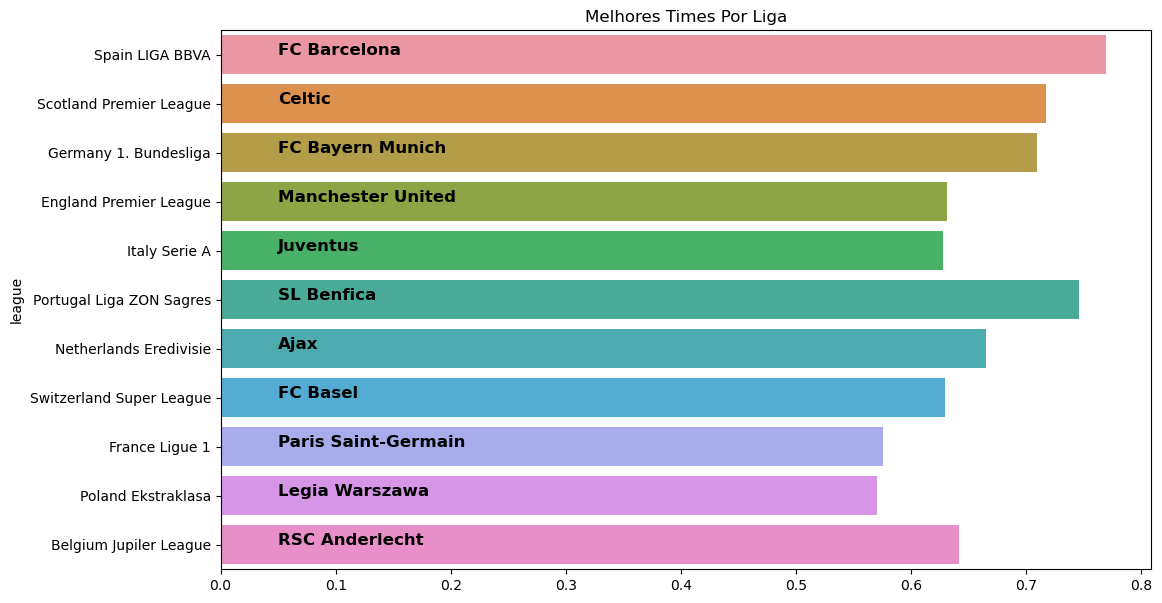

In [238]:
plt.figure(figsize=(12,7))

ax =sns.barplot(a, x=(a["win"]/a["matches"]),y="league")

for i,j in enumerate(a["team"]):
    ax.text(.05,i,j,weight = "bold",fontsize = 12)

plt.title("Melhores Times Por Liga")
plt.show()

### Gols em Casa, Por Melhores Times, Por Temporada

In [240]:
data

country_id  league_id     season  stage       date  match_api_id  \
0               1          1  2008/2009      1 2008-08-17        492473   
1               1          1  2008/2009      1 2008-08-16        492474   
2               1          1  2008/2009      1 2008-08-16        492475   
3               1          1  2008/2009      1 2008-08-17        492476   
4               1          1  2008/2009      1 2008-08-16        492477   
...           ...        ...        ...    ...        ...           ...   
25974       24558      24558  2015/2016      9 2015-09-22       1992091   
25975       24558      24558  2015/2016      9 2015-09-23       1992092   
25976       24558      24558  2015/2016      9 2015-09-23       1992093   
25977       24558      24558  2015/2016      9 2015-09-22       1992094   
25978       24558      24558  2015/2016      9 2015-09-23       1992095   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0                  9987              9993               1               1   
1                 10000              9994               0               0   
2                  9984              8635               0               3   
3                  9991              9998               5               0   
4                  7947              9985               1               3   
...                 ...               ...             ...             ...   
25974             10190             10191               1               0   
25975              9824             10199               1               2   
25976              9956             10179               2               0   
25977              7896             10243               0               0   
25978             10192              9931               4               3   

       ... _merge  year          home_team_lname  home_team_sname  \
0      ...   both  2008                 KRC Genk              GEN   
1      ...   both  2008         SV Zulte-Waregem              ZUL   
2      ...   both  2008        KSV Cercle Brugge              CEB   
3      ...   both  2008                 KAA Gent              GEN   
4      ...   both  2008            FCV Dender EH              DEN   
...    ...    ...   ...                      ...              ...   
25974  ...   both  2015            FC St. Gallen              GAL   
25975  ...   both  2015                 FC Vaduz              VAD   
25976  ...   both  2015  Grasshopper Club Zürich              GRA   
25977  ...   both  2015                   Lugano              LUG   
25978  ...   both  2015           BSC Young Boys               YB   

         away_team_lname away_team_sname total_goal                      win  \
0           Beerschot AC             BAC          2                     DRAW   
1       Sporting Lokeren             LOK          0                     DRAW   
2         RSC Anderlecht             AND          3           RSC Anderlecht   
3              RAEC Mons             MON          5                 KAA Gent   
4      Standard de Liège             STL          4        Standard de Liège   
...                  ...             ...        ...                      ...   
25974            FC Thun             THU          1            FC St. Gallen   
25975          FC Luzern             LUZ          3                FC Luzern   
25976            FC Sion             SIO          2  Grasshopper Club Zürich   
25977          FC Zürich             ZUR          0                     DRAW   
25978           FC Basel             BAS          7           BSC Young Boys   

        outcome_side               lost  
0               DRAW               DRAW  
1               DRAW               DRAW  
2      AWAY TEAM WIN  KSV Cercle Brugge  
3      HOME TEAM WIN          RAEC Mons  
4      AWAY TEAM WIN      FCV Dender EH  
...              ...                ...  
25974  HOME TEAM WIN            FC Thun  
25975  AWAY TEAM WIN           FC Vaduz  
25976  HOME T

In [241]:
list(data)

['country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'country',
 'league',
 '_merge',
 'year',
 'home_team_lname',
 'home_team_sname',
 'away_team_lname',
 'away_team_sname',
 'total_goal',
 'win',
 'outcome_side',
 'lost']

In [242]:
data["win"].value_counts()[1:25]

FC Barcelona           234
Real Madrid CF         228
Celtic                 218
FC Bayern Munich       193
Manchester United      192
Juventus               189
SL Benfica             185
FC Porto               183
Ajax                   181
FC Basel               180
PSV                    178
Chelsea                176
Paris Saint-Germain    175
Manchester City        175
Arsenal                170
Atlético Madrid        167
Roma                   162
Borussia Dortmund      157
Inter                  154
Milan                  154
Napoli                 153
Olympique Lyonnais     153
Tottenham Hotspur      151
Liverpool              150
Name: win, dtype: int64

In [243]:
i = data["win"].value_counts()[1:25].index

In [244]:
i

Index(['FC Barcelona', 'Real Madrid CF', 'Celtic', 'FC Bayern Munich',
       'Manchester United', 'Juventus', 'SL Benfica', 'FC Porto', 'Ajax',
       'FC Basel', 'PSV', 'Chelsea', 'Paris Saint-Germain', 'Manchester City',
       'Arsenal', 'Atlético Madrid', 'Roma', 'Borussia Dortmund', 'Inter',
       'Milan', 'Napoli', 'Olympique Lyonnais', 'Tottenham Hotspur',
       'Liverpool'],
      dtype='object')

In [245]:
t = pd.pivot_table(index="home_team_lname",columns="season",values="home_team_goal",
                  data=data,aggfunc="sum") # Criar uma tabela,  values=["home_team_goal","away_team_goal"]

In [246]:
t

season                    2008/2009  2009/2010  2010/2011  2011/2012  \
home_team_lname                                                        
1. FC Kaiserslautern            NaN        NaN       25.0       12.0   
1. FC Köln                     14.0       18.0       30.0       20.0   
1. FC Nürnberg                  NaN       18.0       28.0       22.0   
1. FSV Mainz 05                 NaN       22.0       22.0       27.0   
AC Ajaccio                      NaN        NaN        NaN       22.0   
...                             ...        ...        ...        ...   
Xerez Club Deportivo            NaN       20.0        NaN        NaN   
Zagłębie Lubin                  NaN       14.0       14.0       18.0   
Zawisza Bydgoszcz               NaN        NaN        NaN        NaN   
Évian Thonon Gaillard FC        NaN        NaN        NaN       29.0   
Śląsk Wrocław                  25.0       19.0       27.0       26.0   

season                    2012/2013  2013/2014  2014/2015  2015/2016  
home_team_lname                                                       
1. FC Kaiserslautern            NaN        NaN        NaN        NaN  
1. FC Köln                      NaN        NaN       18.0       16.0  
1. FC Nürnberg                 24.0       16.0        NaN        NaN  
1. FSV Mainz 05                22.0       28.0       27.0       23.0  
AC Ajaccio                     19.0       23.0        NaN        NaN  
...                             ...        ...        ...        ...  
Xerez Club Deportivo            NaN        NaN        NaN        NaN  
Zagłębie Lubin                 24.0       23.0        NaN       23.0  
Zawisza Bydgoszcz               NaN       27.0       16.0        NaN  
Évian Thonon Gaillard FC       31.0       25.0       20.0        NaN  
Śląsk Wrocław                  23.0       21.0       21.0       14.0  

[296 rows x 8 columns]

In [66]:
t[t.index.isin(i)]

season               2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
home_team_lname                                                              
Ajax                      41.0       64.0       38.0       49.0       40.0   
Arsenal                   31.0       48.0       33.0       39.0       47.0   
Atlético Madrid           47.0       37.0       35.0       36.0       42.0   
Borussia Dortmund         34.0       29.0       35.0       44.0       40.0   
Celtic                    48.0       42.0       51.0       41.0       52.0   
Chelsea                   33.0       68.0       39.0       41.0       41.0   
FC Barcelona              61.0       57.0       46.0       73.0       63.0   
FC Basel                  39.0       54.0       43.0       44.0       36.0   
FC Bayern Munich          45.0       39.0       48.0       49.0       56.0   
FC Porto                  23.0       40.0       43.0       40.0       38.0   
Inter                     37.0       42.0       48.0       34.0       30.0   
Juventus                  38.0       32.0       35.0       37.0       36.0   
Liverpool                 41.0       43.0       37.0       24.0       33.0   
Manchester City           40.0       41.0       34.0       55.0       41.0   
Manchester United         43.0       52.0       49.0       52.0       45.0   
Milan                     39.0       37.0       42.0       34.0       33.0   
Napoli                    27.0       26.0       33.0       37.0       44.0   
Olympique Lyonnais        32.0       32.0       35.0       44.0       34.0   
PSV                       41.0       40.0       49.0       57.0       58.0   
Paris Saint-Germain       29.0       32.0       33.0       42.0       34.0   
Real Madrid CF            49.0       60.0       61.0       70.0       67.0   
Roma                      35.0       36.0       31.0       38.0       40.0   
SL Benfica                23.0       46.0       36.0       44.0       42.0   
Tottenham Hotspur         21.0       40.0       30.0       39.0       29.0   

season               2013/2014  2014/2015  2015/2016  
home_team_lname                                       
Ajax                      42.0       37.0       49.0  
Arsenal                   36.0       41.0       31.0  
Atlético Madrid           49.0       42.0       33.0  
Borussia Dortmund         41.0       26.0       49.0  
Celtic                    50.0       50.0       55.0  
Chelsea                   43.0       36.0       32.0  
FC Barcelona              64.0       64.0       67.0  
FC Basel                  41.0       43.0       44.0  
FC Bayern Munich          48.0       46.0       51.0  
FC Porto                  35.0       41.0       35.0  
Inter                     27.0       33.0       29.0  
Juventus                  47.0       45.0       37.0  
Liverpool                 53.0       30.0       33.0  
Manchester City           63.0       44.0       47.0  
Manchester United         29.0       41.0       27.0  
Milan                     28.0       30.0       28.0  
Napoli                    43.0       44.0       49.0  
Olympique Lyonnais        30.0       40.0       42.0  
PSV                       34.0       50.0       41.0  
Paris Saint-Germain       51.0       52.0       59.0  
Real Madrid CF            63.0       65.0       70.0  
Roma                      44.0       31.0       44.0  
SL Benfica                30.0       48.0       52.0  
Tottenham Hotspur         30.0       31.0       35.0

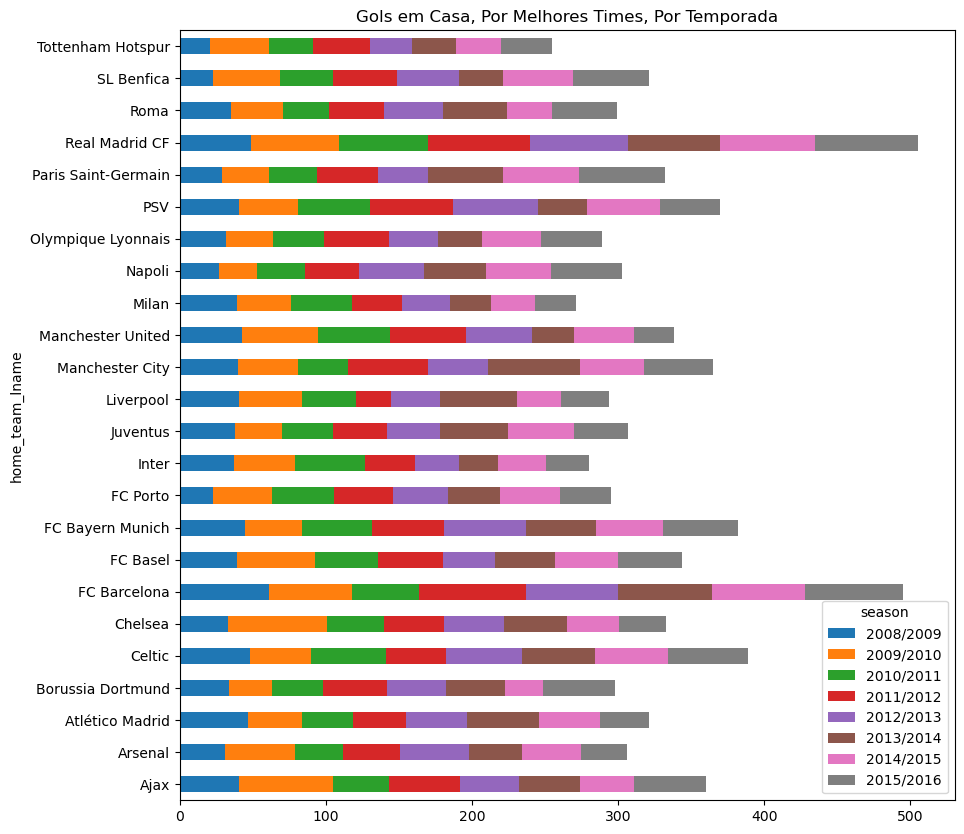

In [247]:
t=t[t.index.isin(i)]
t.plot(kind="barh",stacked=True,figsize=(10,10))
plt.title("Gols em Casa, Por Melhores Times, Por Temporada")
plt.show()

Criar uma tabela como (excel) em DataFrame

In [68]:
t= pd.pivot_table(index="home_team_lname",columns="season",values="home_team_goal",
                  data=data,aggfunc="sum")

In [69]:
t

season                    2008/2009  2009/2010  2010/2011  2011/2012  \
home_team_lname                                                        
1. FC Kaiserslautern            NaN        NaN       25.0       12.0   
1. FC Köln                     14.0       18.0       30.0       20.0   
1. FC Nürnberg                  NaN       18.0       28.0       22.0   
1. FSV Mainz 05                 NaN       22.0       22.0       27.0   
AC Ajaccio                      NaN        NaN        NaN       22.0   
...                             ...        ...        ...        ...   
Xerez Club Deportivo            NaN       20.0        NaN        NaN   
Zagłębie Lubin                  NaN       14.0       14.0       18.0   
Zawisza Bydgoszcz               NaN        NaN        NaN        NaN   
Évian Thonon Gaillard FC        NaN        NaN        NaN       29.0   
Śląsk Wrocław                  25.0       19.0       27.0       26.0   

season                    2012/2013  2013/2014  2014/2015  2015/2016  
home_team_lname                                                       
1. FC Kaiserslautern            NaN        NaN        NaN        NaN  
1. FC Köln                      NaN        NaN       18.0       16.0  
1. FC Nürnberg                 24.0       16.0        NaN        NaN  
1. FSV Mainz 05                22.0       28.0       27.0       23.0  
AC Ajaccio                     19.0       23.0        NaN        NaN  
...                             ...        ...        ...        ...  
Xerez Club Deportivo            NaN        NaN        NaN        NaN  
Zagłębie Lubin                 24.0       23.0        NaN       23.0  
Zawisza Bydgoszcz               NaN       27.0       16.0        NaN  
Évian Thonon Gaillard FC       31.0       25.0       20.0        NaN  
Śląsk Wrocław                  23.0       21.0       21.0       14.0  

[296 rows x 8 columns]

### Jogos entre os Melhores Times

annot : bool or rectangular dataset, optional

If True, write the data value in each cell. If an array-like with the same shape as data, then use this to annotate the heatmap instead of the raw data.

In [248]:
i = data["win"].value_counts()[1:50].index

In [71]:
i

Index(['FC Barcelona', 'Real Madrid CF', 'Celtic', 'FC Bayern Munich',
       'Manchester United', 'Juventus', 'SL Benfica', 'FC Porto', 'Ajax',
       'FC Basel', 'PSV', 'Chelsea', 'Paris Saint-Germain', 'Manchester City',
       'Arsenal', 'Atlético Madrid', 'Roma', 'Borussia Dortmund', 'Inter',
       'Milan', 'Napoli', 'Olympique Lyonnais', 'Tottenham Hotspur',
       'Liverpool', 'LOSC Lille', 'Sporting CP', 'FC Twente',
       'Olympique de Marseille', 'Valencia CF', 'BSC Young Boys', 'AZ',
       'Feyenoord', 'Sevilla FC', 'Legia Warszawa', 'Bayer 04 Leverkusen',
       'RSC Anderlecht', 'Fiorentina', 'Lazio', 'FC Schalke 04', 'SC Braga',
       'Girondins de Bordeaux', 'Lech Poznań', 'Club Brugge KV', 'Motherwell',
       'Athletic Club de Bilbao', 'AS Saint-Étienne', 'Everton', 'FC Zürich',
       'Aberdeen'],
      dtype='object')

In [74]:
data["home_team_lname"].isin(i)

0        False
1        False
2        False
3        False
4        False
         ...  
25974    False
25975    False
25976    False
25977    False
25978     True
Name: home_team_lname, Length: 25979, dtype: bool

In [75]:
data[(data["home_team_lname"].isin(i)) | (data["away_team_lname"].isin(i))]

country_id  league_id     season  stage       date  match_api_id  \
2               1          1  2008/2009      1 2008-08-16        492475   
5               1          1  2008/2009      1 2008-09-24        492478   
9               1          1  2008/2009     10 2008-11-01        492564   
17              1          1  2008/2009     10 2008-11-02        492572   
18              1          1  2008/2009     11 2008-11-08        492573   
...           ...        ...        ...    ...        ...           ...   
25969       24558      24558  2015/2016      8 2015-09-12       1992086   
25970       24558      24558  2015/2016      8 2015-09-12       1992087   
25972       24558      24558  2015/2016      8 2015-09-13       1992089   
25977       24558      24558  2015/2016      9 2015-09-22       1992094   
25978       24558      24558  2015/2016      9 2015-09-23       1992095   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
2                  9984              8635               0               3   
5                  8203              8342               1               1   
9                  8342              8571               4               1   
17                 9993              8635               1               3   
18                 8635              9994               2               3   
...                 ...               ...             ...             ...   
25969              9931             10190               2               1   
25970             10192              9824               4               0   
25972             10243             10191               3               3   
25977              7896             10243               0               0   
25978             10192              9931               4               3   

       ... _merge  year    home_team_lname  home_team_sname   away_team_lname  \
2      ...   both  2008  KSV Cercle Brugge              CEB    RSC Anderlecht   
5      ...   both  2008        KV Mechelen              MEC    Club Brugge KV   
9      ...   both  2008     Club Brugge KV              CLB       KV Kortrijk   
17     ...   both  2008       Beerschot AC              BAC    RSC Anderlecht   
18     ...   both  2008     RSC Anderlecht              AND  Sporting Lokeren   
...    ...    ...   ...                ...              ...               ...   
25969  ...   both  2015           FC Basel              BAS     FC St. Gallen   
25970  ...   both  2015     BSC Young Boys               YB          FC Vaduz   
25972  ...   both  2015          FC Zürich              ZUR           FC Thun   
25977  ...   both  2015             Lugano              LUG         FC Zürich   
25978  ...   both  2015     BSC Young Boys               YB          FC Basel   

      away_team_sname total_goal               win   outcome_side  \
2                 AND          3    RSC Anderlecht  AWAY TEAM WIN   
5                 CLB          2              DRAW           DRAW   
9                 KOR          5    Club Brugge KV  HOME TEAM WIN   
17                AND          4    RSC Anderlecht  AWAY TEAM WIN   
18                LOK          5  Sporting Lokeren  AWAY TEAM WIN   
...               ...        ...               ...            ...   
25969             GAL          3          FC Basel  HOME TEAM WIN   
25970             VAD          4    BSC Young Boys  HOME TEAM WIN   
25972             THU          6              DRAW           DRAW   
25977             ZUR          0              DRAW           DRAW   
25978             BAS          7    BSC Young Boys  HOME TEAM WIN   

                    lost  
2      KSV Cercle Brugge  
5                   DRAW  
9            KV Kortrijk  
17          Beerschot AC  
18        RSC Anderlecht  
...                  ...  
25969      FC St. Gallen  
25970           FC Vaduz  
25972               DRAW  
25977               DRAW  
25978           FC Basel  

[12291 rows x 22 columns]

In [249]:
c = data[(data["home_team_lname"].isin(i)) & (data["away_team_lname"].isin(i))]

In [77]:
c

country_id  league_id     season  stage       date  match_api_id  \
27              1          1  2008/2009     12 2008-11-16        492582   
189             1          1  2008/2009     29 2009-04-12        493061   
313             1          1  2009/2010     10 2009-10-04        665411   
376             1          1  2009/2010     19 2010-02-03        665626   
556             1          1  2010/2011     14 2010-11-07        838635   
...           ...        ...        ...    ...        ...           ...   
25918       24558      24558  2015/2016     30 2016-04-24       1992200   
25928       24558      24558  2015/2016     32 2016-05-07       1992210   
25942       24558      24558  2015/2016     35 2016-05-22       1992224   
25967       24558      24558  2015/2016      7 2015-08-30       1992084   
25978       24558      24558  2015/2016      9 2015-09-23       1992095   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
27                 8342              8635               1               1   
189                8635              8342               1               0   
313                8342              8635               4               2   
376                8635              8342               3               2   
556                8635              8342               2               2   
...                 ...               ...             ...             ...   
25918             10192             10243               3               0   
25928             10243              9931               2               3   
25942             10192              9931               2               3   
25967              9931             10243               3               1   
25978             10192              9931               4               3   

       ... _merge  year home_team_lname  home_team_sname away_team_lname  \
27     ...   both  2008  Club Brugge KV              CLB  RSC Anderlecht   
189    ...   both  2009  RSC Anderlecht              AND  Club Brugge KV   
313    ...   both  2009  Club Brugge KV              CLB  RSC Anderlecht   
376    ...   both  2010  RSC Anderlecht              AND  Club Brugge KV   
556    ...   both  2010  RSC Anderlecht              AND  Club Brugge KV   
...    ...    ...   ...             ...              ...             ...   
25918  ...   both  2016  BSC Young Boys               YB       FC Zürich   
25928  ...   both  2016       FC Zürich              ZUR        FC Basel   
25942  ...   both  2016  BSC Young Boys               YB        FC Basel   
25967  ...   both  2015        FC Basel              BAS       FC Zürich   
25978  ...   both  2015  BSC Young Boys               YB        FC Basel   

      away_team_sname total_goal             win   outcome_side  \
27                AND          2            DRAW           DRAW   
189               CLB          1  RSC Anderlecht  HOME TEAM WIN   
313               AND          6  Club Brugge KV  HOME TEAM WIN   
376               CLB          5  RSC Anderlecht  HOME TEAM WIN   
556               CLB          4            DRAW           DRAW   
...               ...        ...             ...            ...   
25918             ZUR          3  BSC Young Boys  HOME TEAM WIN   
25928             BAS          5        FC Basel  AWAY TEAM WIN   
25942             BAS          5        FC Basel  AWAY TEAM WIN   
25967             ZUR          4        FC Basel  HOME TEAM WIN   
25978             BAS          7  BSC Young Boys  HOME TEAM WIN   

                 lost  
27               DRAW  
189    Club Brugge KV  
313    RSC Anderlecht  
376    Club Brugge KV  
556              DRAW  
...               ...  
25918       FC Zürich  
25928       FC Zürich  
25942  BSC Young Boys  
25967       FC Zürich  
25978        FC Basel  

[1711 rows x 22 columns]

In [250]:
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])

In [79]:
d

away_team_lname          AS Saint-Étienne  AZ  Aberdeen  Ajax  Arsenal  \
home_team_lname                                                          
AS Saint-Étienne                        0   0         0     0        0   
AZ                                      0   0         0     8        0   
Aberdeen                                0   0         0     0        0   
Ajax                                    0   8         0     0        0   
Arsenal                                 0   0         0     0        0   
Athletic Club de Bilbao                 0   0         0     0        0   
Atlético Madrid                         0   0         0     0        0   
BSC Young Boys                          0   0         0     0        0   
Bayer 04 Leverkusen                     0   0         0     0        0   
Borussia Dortmund                       0   0         0     0        0   
Celtic                                  0   0        14     0        0   
Chelsea                                 0   0         0     0        8   
Club Brugge KV                          0   0         0     0        0   
Everton                                 0   0         0     0        8   
FC Barcelona                            0   0         0     0        0   
FC Basel                                0   0         0     0        0   
FC Bayern Munich                        0   0         0     0        0   
FC Porto                                0   0         0     0        0   
FC Schalke 04                           0   0         0     0        0   
FC Twente                               0   8         0     8        0   
FC Zürich                               0   0         0     0        0   
Feyenoord                               0   8         0     8        0   
Fiorentina                              0   0         0     0        0   
Girondins de Bordeaux                   8   0         0     0        0   
Inter                                   0   0         0     0        0   
Juventus                                0   0         0     0        0   
LOSC Lille                              8   0         0     0        0   
Lazio                                   0   0         0     0        0   
Lech Poznań                             0   0         0     0        0   
Legia Warszawa                          0   0         0     0        0   
Liverpool                               0   0         0     0        8   
Manchester City                         0   0         0     0        8   
Manchester United                       0   0         0     0        8   
Milan                                   0   0         0     0        0   
Motherwell                              0   0        13     0        0   
Napoli                                  0   0         0     0        0   
Olympique Lyonnais                      8   0         0     0        0   
Olympique de Marseille                  8   0         0     0        0   
PSV                                     0   8         0     8        0   
Paris Saint-Germain                     8   0         0     0        0   
RSC Anderlecht                          0   0         0     0        0   
Real Madrid CF                          0   0         0     0        0   
Roma                                    0   0         0     0        0   
SC Braga                                0   0         0     0        0   
SL Benfica                              0   0         0     0        0   
Sevilla FC                              0   0         0     0        0   
Sporting CP                             0   0         0     0        0   
Tottenham Hotspur                       0   0         0     0        8   
Valencia CF                             0   0         0     0        0   

away_team_lname          Athletic Club de Bilbao  Atlético Madrid  \
home_team_lname                                                     
AS Saint-Étienne                               0                0   
AZ                

In [251]:
i = data["win"].value_counts()[1:50].index
c = data[(data["home_team_lname"].isin(i)) & (data["away_team_lname"].isin(i))]
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])

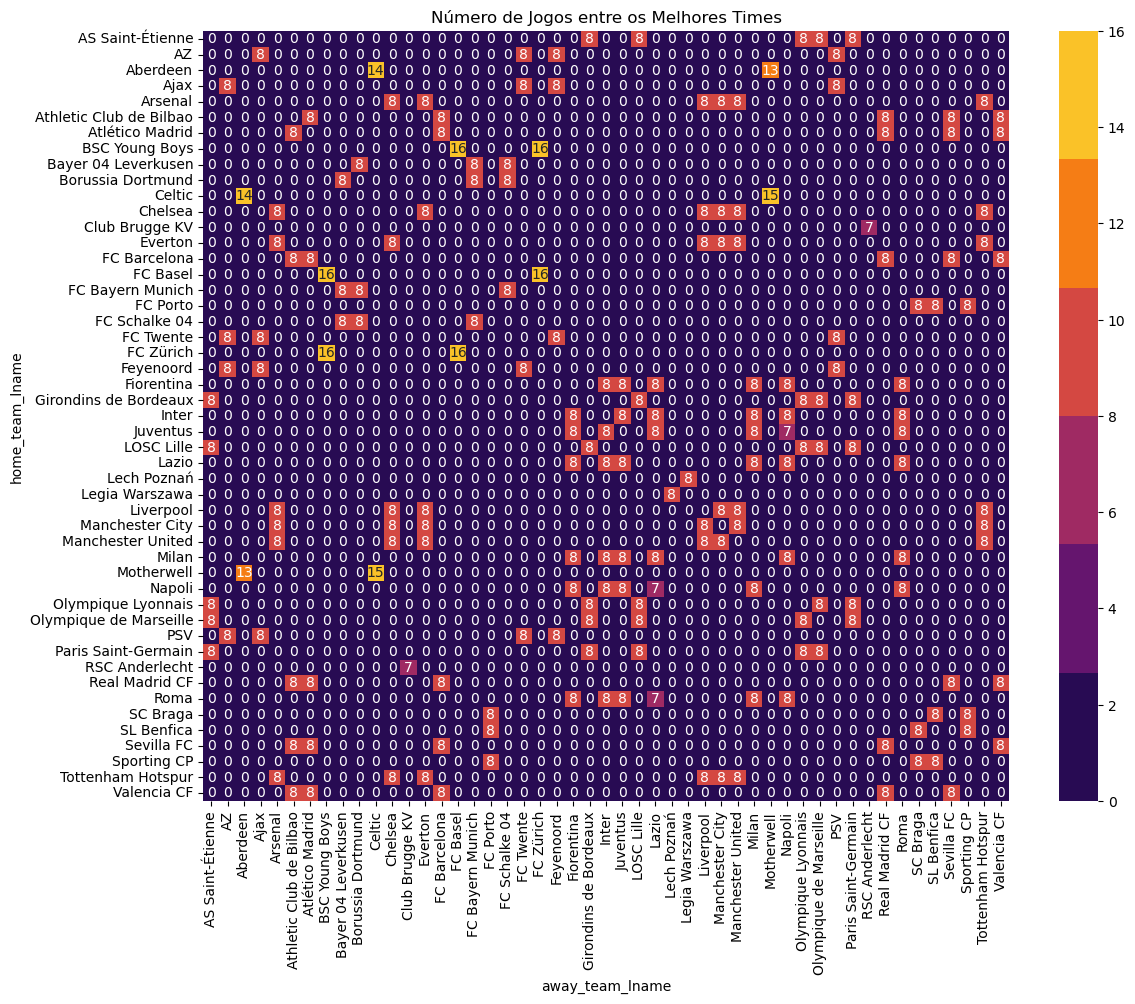

In [252]:
plt.figure(figsize=(13,10))
sns.heatmap(d,annot=True,cmap=sns.color_palette("inferno")) # Opção annot
plt.title("Número de Jogos entre os Melhores Times")
plt.show()

In [253]:
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])

In [83]:
d

away_team_lname          AS Saint-Étienne  AZ  Aberdeen  Ajax  Arsenal  \
home_team_lname                                                          
AS Saint-Étienne                        0   0         0     0        0   
AZ                                      0   0         0     8        0   
Aberdeen                                0   0         0     0        0   
Ajax                                    0   8         0     0        0   
Arsenal                                 0   0         0     0        0   
Athletic Club de Bilbao                 0   0         0     0        0   
Atlético Madrid                         0   0         0     0        0   
BSC Young Boys                          0   0         0     0        0   
Bayer 04 Leverkusen                     0   0         0     0        0   
Borussia Dortmund                       0   0         0     0        0   
Celtic                                  0   0        14     0        0   
Chelsea                                 0   0         0     0        8   
Club Brugge KV                          0   0         0     0        0   
Everton                                 0   0         0     0        8   
FC Barcelona                            0   0         0     0        0   
FC Basel                                0   0         0     0        0   
FC Bayern Munich                        0   0         0     0        0   
FC Porto                                0   0         0     0        0   
FC Schalke 04                           0   0         0     0        0   
FC Twente                               0   8         0     8        0   
FC Zürich                               0   0         0     0        0   
Feyenoord                               0   8         0     8        0   
Fiorentina                              0   0         0     0        0   
Girondins de Bordeaux                   8   0         0     0        0   
Inter                                   0   0         0     0        0   
Juventus                                0   0         0     0        0   
LOSC Lille                              8   0         0     0        0   
Lazio                                   0   0         0     0        0   
Lech Poznań                             0   0         0     0        0   
Legia Warszawa                          0   0         0     0        0   
Liverpool                               0   0         0     0        8   
Manchester City                         0   0         0     0        8   
Manchester United                       0   0         0     0        8   
Milan                                   0   0         0     0        0   
Motherwell                              0   0        13     0        0   
Napoli                                  0   0         0     0        0   
Olympique Lyonnais                      8   0         0     0        0   
Olympique de Marseille                  8   0         0     0        0   
PSV                                     0   8         0     8        0   
Paris Saint-Germain                     8   0         0     0        0   
RSC Anderlecht                          0   0         0     0        0   
Real Madrid CF                          0   0         0     0        0   
Roma                                    0   0         0     0        0   
SC Braga                                0   0         0     0        0   
SL Benfica                              0   0         0     0        0   
Sevilla FC                              0   0         0     0        0   
Sporting CP                             0   0         0     0        0   
Tottenham Hotspur                       0   0         0     0        8   
Valencia CF                             0   0         0     0        0   

away_team_lname          Athletic Club de Bilbao  Atlético Madrid  \
home_team_lname                                                     
AS Saint-Étienne                               0                0   
AZ                

### Gols Marcados Por Liga

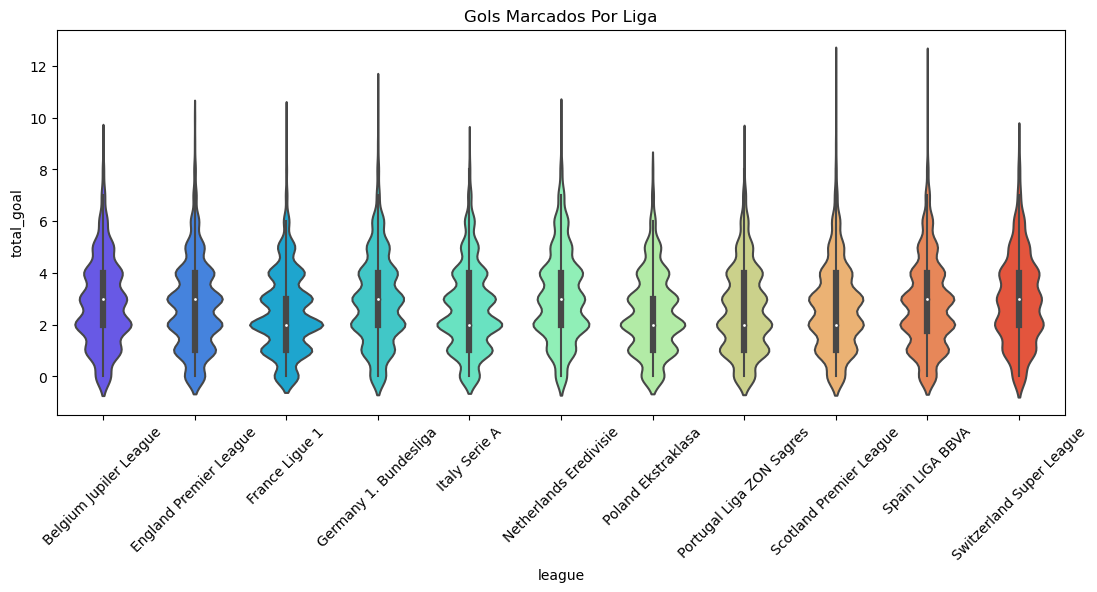

In [255]:
plt.figure(figsize=(13,5))
sns.violinplot(data=data, x="league",y="total_goal",palette="rainbow")
plt.title("Gols Marcados Por Liga")
plt.xticks(rotation = 45)
plt.show()

### Atributos dos Jogadores

In [85]:
list(data)

['country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'country',
 'league',
 '_merge',
 'year',
 'home_team_lname',
 'home_team_sname',
 'away_team_lname',
 'away_team_sname',
 'total_goal',
 'win',
 'outcome_side',
 'lost']

In [86]:
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [257]:
player["weight_kg"] = player["weight"] * 0.453592
player["height_m"]  = player["height"] / 100
player["bmi"]       = player["weight_kg"]/(player["height_m"] * player["height_m"])
player["year"]  = pd.DatetimeIndex(player["birthday"]).year
player["age"]   = 2022 - player["year"]

In [258]:
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  weight_kg  height_m        bmi  year  \
0  1992-02-29 00:00:00  182.88     187  84.821704    1.8288  25.361478  1992   
1  1989-12-15 00:00:00  170.18     146  66.224432    1.7018  22.866579  1989   
2  1991-05-13 00:00:00  170.18     163  73.935496    1.7018  25.529126  1991   
3  1982-05-08 00:00:00  182.88     198  89.811216    1.8288  26.853330  1982   
4  1979-11-08 00:00:00  182.88     154  69.853168    1.8288  20.885923  1979   

   age  
0   30  
1   33  
2   31  
3   40  
4   43

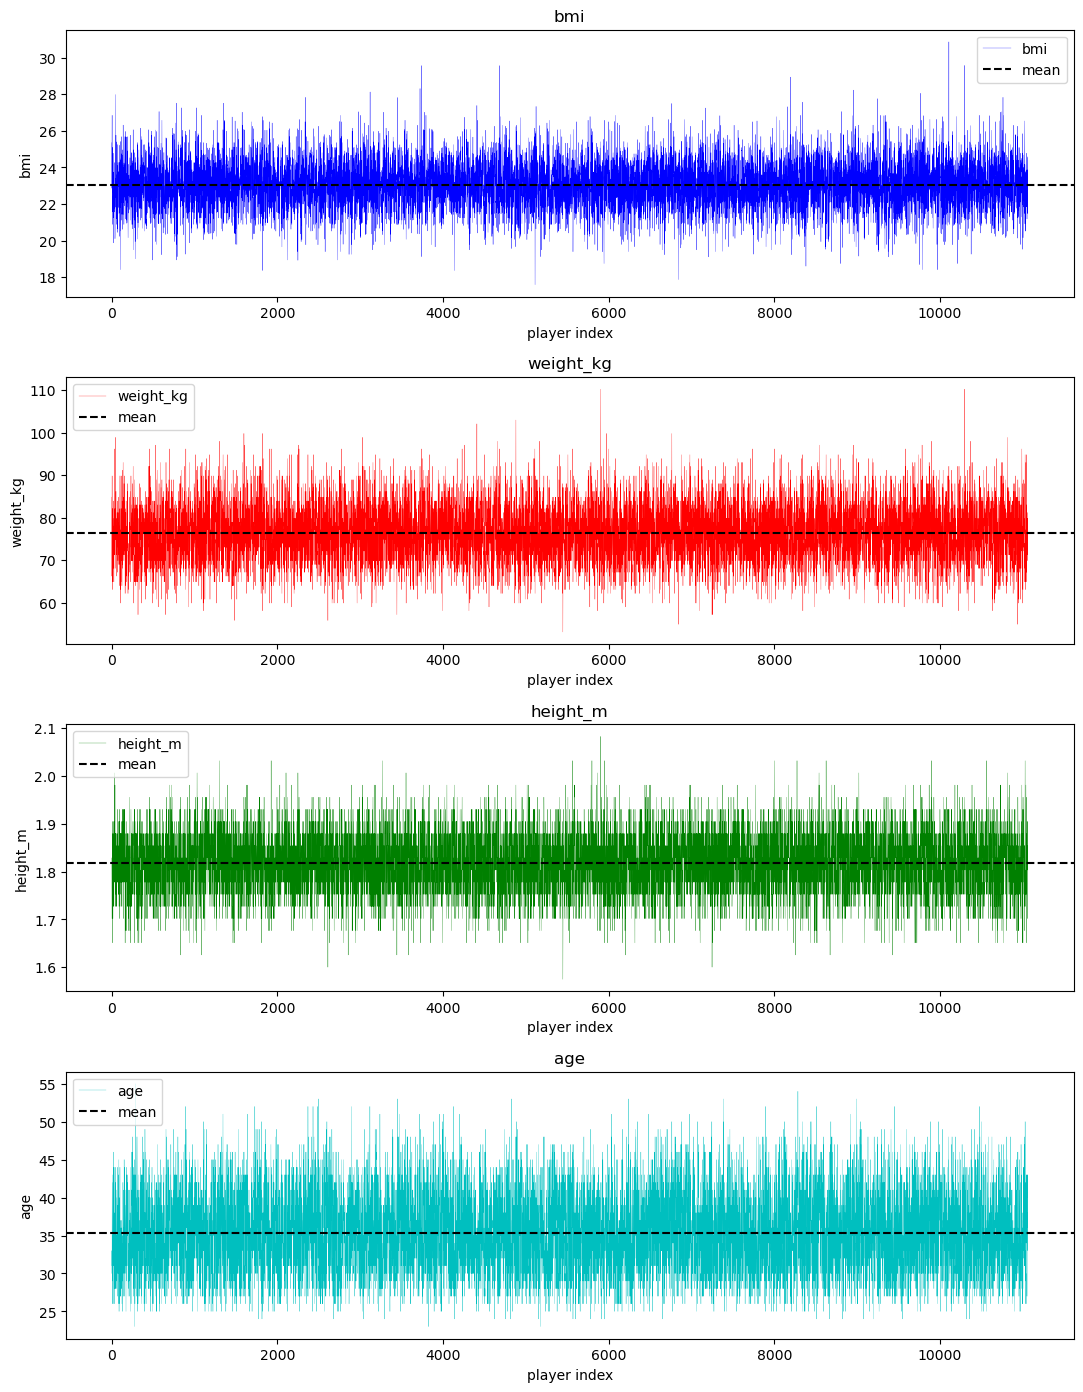

In [259]:
cols  = ["bmi","weight_kg","height_m","age"]
length = len(cols)
c = ["b","r","g","c"]
plt.figure(figsize=(13,17))

for i,j,k in zip(cols,range(length),c):
    plt.subplot(4,1,j+1)
    player[i].plot(color = k ,linewidth =.2,label = i)
    plt.axhline(player[i].mean(),color = "k",linestyle = "dashed",label="mean")
    plt.legend(loc="best")
    plt.subplots_adjust(hspace = .3)
    plt.xlabel("player index")
    plt.ylabel(i)
    plt.title(i)

plt.show()

### Atributos dos Jogadores Normalmente Distribuidos

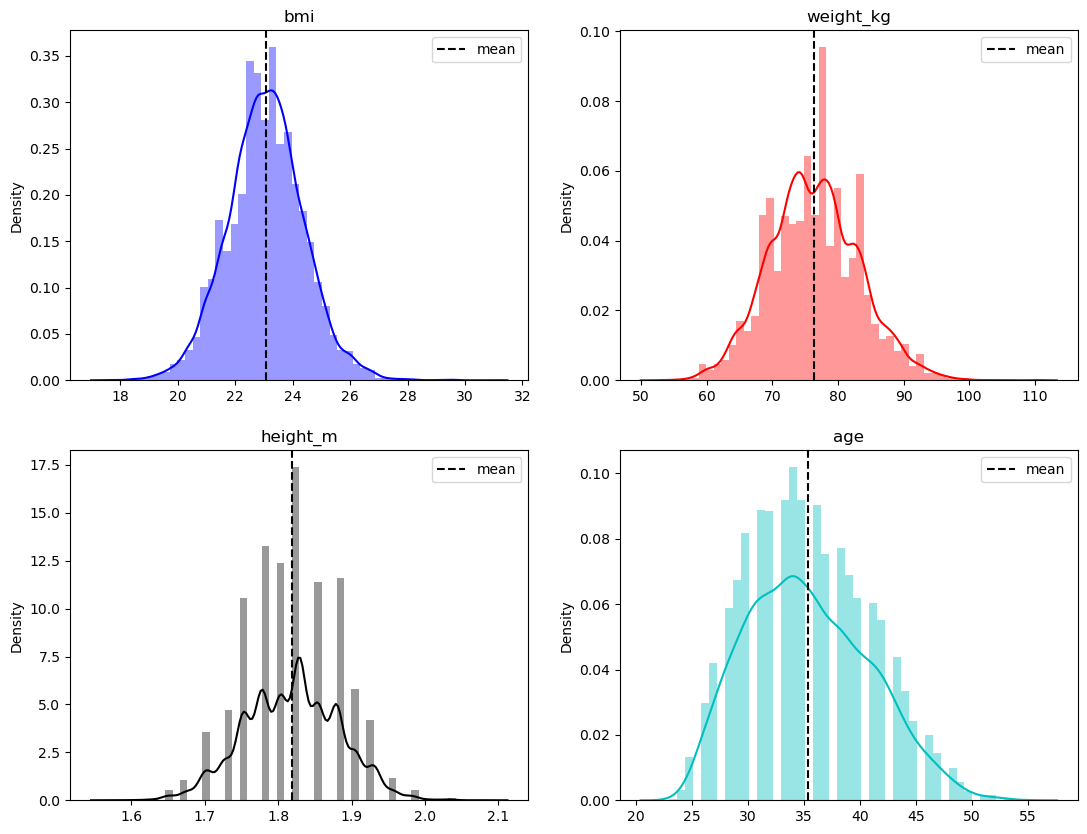

In [260]:
cols  = ["bmi","weight_kg","height_m","age"]
length = len(cols)
c = ["b","r","k","c"]
plt.figure(figsize=(13,10))

for i,j,k in itertools.zip_longest(cols,range(length),c):
    plt.subplot(2,2,j+1)
    sns.distplot(player[i],color=k)
    plt.axvline(player[i].mean(),color = "k",linestyle = "dashed",label="mean")
    plt.legend(loc="best")
    plt.title(i)
    plt.xlabel("")

plt.show()

In [97]:
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  weight_kg  height_m        bmi  year  \
0  1992-02-29 00:00:00  182.88     187  84.821704    1.8288  25.361478  1992   
1  1989-12-15 00:00:00  170.18     146  66.224432    1.7018  22.866579  1989   
2  1991-05-13 00:00:00  170.18     163  73.935496    1.7018  25.529126  1991   
3  1982-05-08 00:00:00  182.88     198  89.811216    1.8288  26.853330  1982   
4  1979-11-08 00:00:00  182.88     154  69.853168    1.8288  20.885923  1979   

   age  
0   30  
1   33  
2   31  
3   40  
4   43

In [98]:
player["age"].idxmax()

289

In [99]:
player["age"].idxmin()

271

In [100]:
player.loc[271]["player_name"]

'Alban Lafont'

In [101]:
player.loc[player["age"].idxmax()]["player_name"]

'Alberto Fontana'

In [102]:
player["age"].max()

55

In [103]:
player[player["player_fifa_api_id"] == 158023]

id  player_api_id   player_name  player_fifa_api_id  \
6169  6176          30981  Lionel Messi              158023   

                 birthday  height  weight  weight_kg  height_m        bmi  \
6169  1987-06-24 00:00:00  170.18     159  72.121128    1.7018  24.902645   

      year  age  
6169  1987   35

In [104]:
print ("Atributos Jogadores")
print ("===================================================================================================")
print ("Jogador mais velho é",player.loc[player["age"].idxmax()]["player_name"],"com idade de",player["age"].max(),"anos")
print ("Jogadores mais novos são",list(player[player["age"]==player["age"].min()]["player_name"]),"com idades de",player["age"].min(),"anos")
print ("Jogador mais alto é",player.loc[player["height_m"].idxmax()]["player_name"],"com altura de",player["height_m"].max(),"metros")
print ("Jogador mais baixo é",player.loc[player["height_m"].idxmin()]["player_name"],"com altura de",player["height_m"].min(),"metros")
print ("Jogador com maior peso é",list(player[player["weight_kg"] == 110.222856]["player_name"]),"com peso de ",player["weight_kg"].max(),"kg")
print ("Jogador com menor peso é",player.loc[player["weight_kg"].idxmin()]["player_name"],"com peso de ",player["weight_kg"].min(),"kg")
print ("Jogador com o maior BMI é",player.loc[player["bmi"].idxmax()]["player_name"],"com",player["bmi"].max(),"kg/m2")
print ("Jogador com o menor BMI é",player.loc[player["bmi"].idxmin()]["player_name"],"com",player["bmi"].min(),"kg/m2")

Atributos Jogadores
Jogador mais velho é Alberto Fontana com idade de 55 anos
Jogadores mais novos são ['Alban Lafont', 'Gianluigi Donnarumma', 'Jonathan Leko'] com idades de 23 anos
Jogador mais alto é Kristof van Hout com altura de 2.0828 metros
Jogador mais baixo é Juan Quero com altura de 1.5748 metros
Jogador com maior peso é ['Kristof van Hout', 'Tim Wiese'] com peso de  110.222856 kg
Jogador com menor peso é Juan Quero com peso de  53.070264 kg
Jogador com o maior BMI é Sylvan Ebanks-Blake com 30.865702475349586 kg/m2
Jogador com o menor BMI é John Stewart com 17.58956425144406 kg/m2


In [105]:
player[["height","weight_kg","age","bmi"]].describe()[1:].transpose()

mean       std         min         25%         50%  \
height     181.867445  6.369201  157.480000  177.800000  182.880000   
weight_kg   76.375952  6.799443   53.070264   72.121128   76.203456   
age         35.357143  5.481362   23.000000   31.000000   35.000000   
bmi         23.065734  1.317103   17.589564   22.174718   23.055889   

                  75%         max  
height     185.420000  208.280000  
weight_kg   81.192968  110.222856  
age         39.000000   55.000000  
bmi         23.871504   30.865702

### Sumário dos Atributos

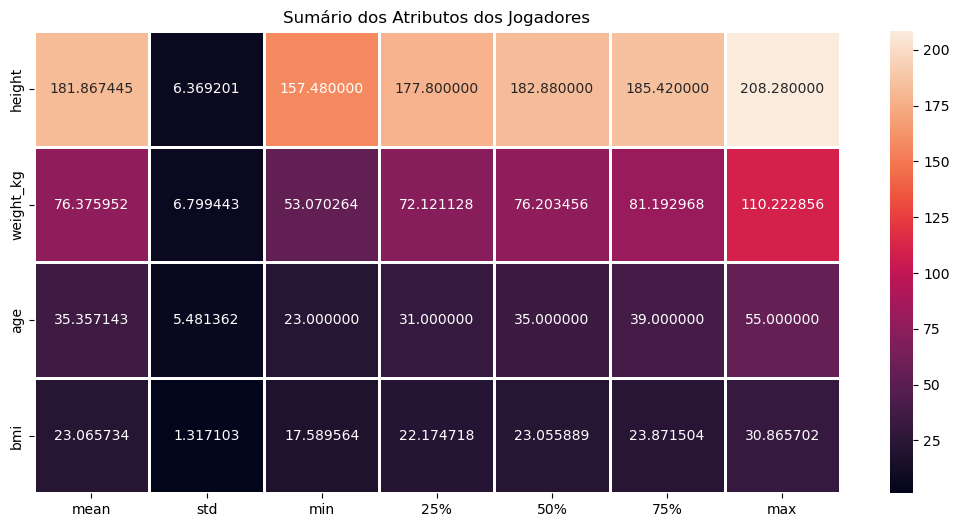

In [261]:
plt.figure(figsize=(13,6))
sns.heatmap(player[["height","weight_kg","age","bmi"]].describe()[1:].transpose(),annot=True,fmt="f",linecolor="white",linewidths=2) # fmt: String formatting code to use when adding annotations
plt.title("Sumário dos Atributos dos Jogadores")
plt.show()

### Correlação Entre as Variáveis

In [107]:
player.corr()

id  player_api_id  player_fifa_api_id    height  \
id                  1.000000      -0.006515           -0.002377  0.008563   
player_api_id      -0.006515       1.000000            0.576963 -0.053595   
player_fifa_api_id -0.002377       0.576963            1.000000 -0.025890   
height              0.008563      -0.053595           -0.025890  1.000000   
weight              0.004654      -0.164771           -0.111867  0.766626   
weight_kg           0.004654      -0.164771           -0.111867  0.766626   
height_m            0.008563      -0.053595           -0.025890  1.000000   
bmi                -0.002845      -0.192010           -0.142558 -0.030688   
year                0.000653       0.754425            0.789524 -0.061700   
age                -0.000653      -0.754425           -0.789524  0.061700   

                      weight  weight_kg  height_m       bmi      year  \
id                  0.004654   0.004654  0.008563 -0.002845  0.000653   
player_api_id      -0.164771  -0.164771 -0.053595 -0.192010  0.754425   
player_fifa_api_id -0.111867  -0.111867 -0.025890 -0.142558  0.789524   
height              0.766626   0.766626  1.000000 -0.030688 -0.061700   
weight              1.000000   1.000000  0.766626  0.616426 -0.177416   
weight_kg           1.000000   1.000000  0.766626  0.616426 -0.177416   
height_m            0.766626   0.766626  1.000000 -0.030688 -0.061700   
bmi                 0.616426   0.616426 -0.030688  1.000000 -0.200625   
year               -0.177416  -0.177416 -0.061700 -0.200625  1.000000   
age                 0.177416   0.177416  0.061700  0.200625 -1.000000   

                         age  
id                 -0.000653  
player_api_id      -0.754425  
player_fifa_api_id -0.789524  
height              0.061700  
weight              0.177416  
weight_kg           0.177416  
height_m            0.061700  
bmi                 0.200625  
year               -1.000000  
age                 1.000000

In [108]:
player[["height_m","weight_kg","age","bmi"]].corr()

height_m  weight_kg       age       bmi
height_m   1.000000   0.766626  0.061700 -0.030688
weight_kg  0.766626   1.000000  0.177416  0.616426
age        0.061700   0.177416  1.000000  0.200625
bmi       -0.030688   0.616426  0.200625  1.000000

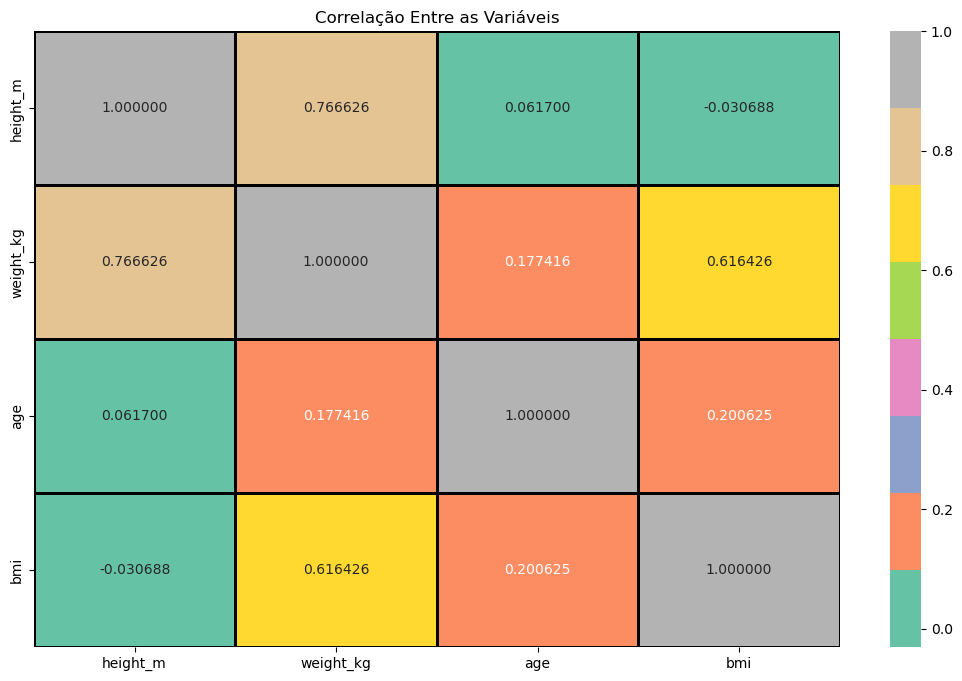

In [262]:
plt.figure(figsize=(13,8))
sns.heatmap(player[["height_m","weight_kg","age","bmi"]].corr(),annot=True,fmt="f",linecolor="k",
            linewidths=2,cmap =sns.color_palette("Set2"))
plt.title("Correlação Entre as Variáveis")
plt.show()

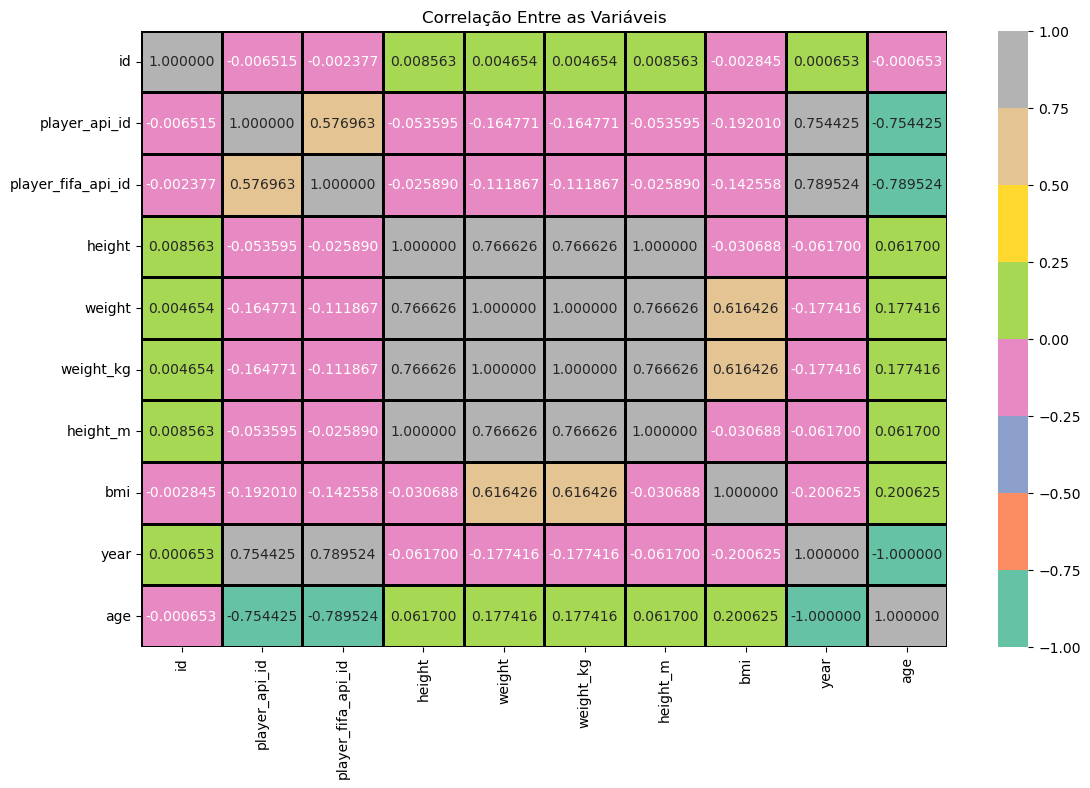

In [263]:
correlation = player.corr()
plt.figure(figsize=(13,8))
sns.heatmap(correlation,annot=True,fmt="f",linecolor="k",
            linewidths=2,cmap =sns.color_palette("Set2"))
plt.title("Correlação Entre as Variáveis")
plt.show()

### Densidade Entre Altura e Peso

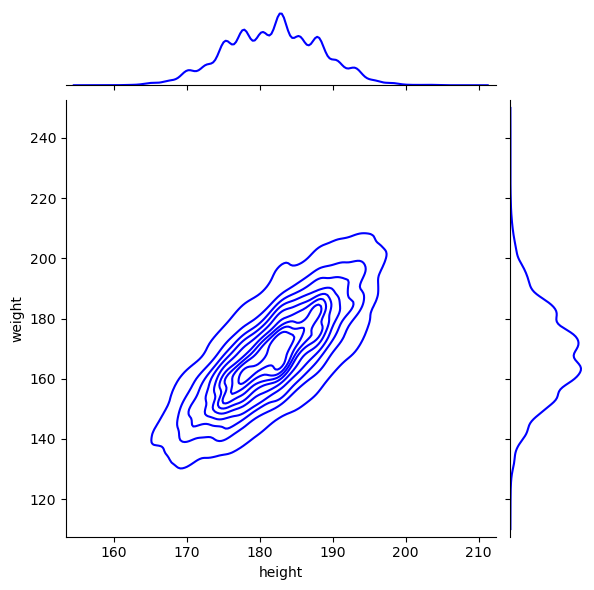

In [265]:
sns.jointplot(data=player,x="height",y="weight",kind="kde",color="b",size = 9)
plt.show()

### Hexbin para Idade vs. peso, altura e BMI

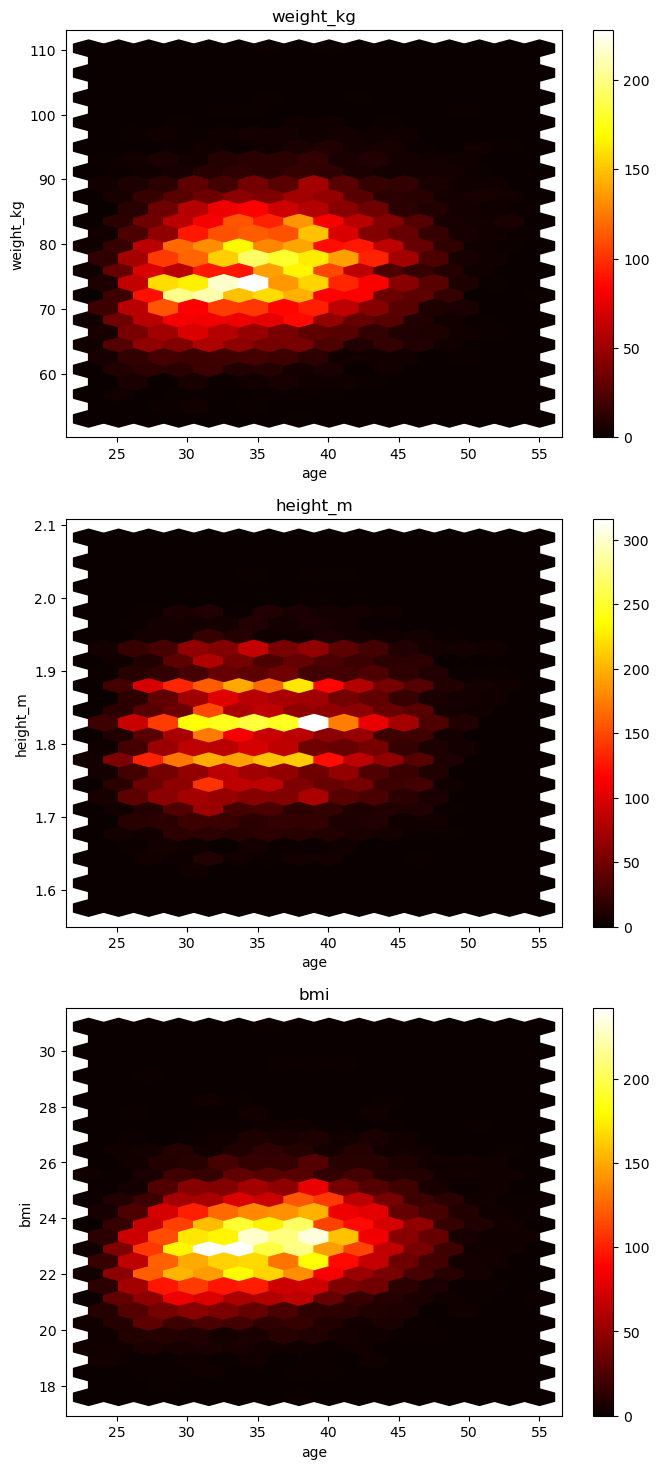

In [266]:
cols = [ 'weight_kg', 'height_m', 'bmi']
length=len(cols)
plt.figure(figsize=(8,18))
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(3,1,j+1)
    plt.hexbin(player["age"],player[i],cmap="hot",gridsize=(15,15))
    plt.xlabel("age")
    plt.ylabel(i)
    plt.colorbar()
    plt.title(i)

plt.show()

### Tendências Das Primeiras Letras nos Nomes dos Jogadores

In [267]:
player["player_name"].str.split(" ").str[0].str.upper().str[0:1]

0        A
1        A
2        A
3        A
4        A
        ..
11055    Z
11056    Z
11057    Z
11058    Z
11059    Z
Name: player_name, Length: 11060, dtype: object

In [268]:
player["player_name"].str.split(" ").str[0].str.upper().str[:1].value_counts()

M    1310
J    1082
A    1069
D     812
S     761
R     672
C     541
L     486
G     483
F     456
P     452
B     404
K     376
T     374
E     322
N     321
I     206
H     199
V     182
O     151
W     135
Y     130
Z      70
U      31
X      23
Q      12
Name: player_name, dtype: int64

In [269]:
player["fl"] = player["player_name"].str.split(" ").str[0].str.upper().str[:1]

In [270]:
player

id  player_api_id          player_name  player_fifa_api_id  \
0          1         505942   Aaron Appindangoye              218353   
1          2         155782      Aaron Cresswell              189615   
2          3         162549          Aaron Doran              186170   
3          4          30572        Aaron Galindo              140161   
4          5          23780         Aaron Hughes               17725   
...      ...            ...                  ...                 ...   
11055  11071          26357       Zoumana Camara                2488   
11056  11072         111182         Zsolt Laczko              164680   
11057  11073          36491            Zsolt Low              111191   
11058  11074          35506  Zurab Khizanishvili               47058   
11059  11075          39902   Zvjezdan Misimovic              102359   

                  birthday  height  weight  weight_kg  height_m        bmi  \
0      1992-02-29 00:00:00  182.88     187  84.821704    1.8288  25.361478   
1      1989-12-15 00:00:00  170.18     146  66.224432    1.7018  22.866579   
2      1991-05-13 00:00:00  170.18     163  73.935496    1.7018  25.529126   
3      1982-05-08 00:00:00  182.88     198  89.811216    1.8288  26.853330   
4      1979-11-08 00:00:00  182.88     154  69.853168    1.8288  20.885923   
...                    ...     ...     ...        ...       ...        ...   
11055  1979-04-03 00:00:00  182.88     168  76.203456    1.8288  22.784644   
11056  1986-12-18 00:00:00  182.88     176  79.832192    1.8288  23.869627   
11057  1979-04-29 00:00:00  180.34     154  69.853168    1.8034  21.478402   
11058  1981-10-06 00:00:00  185.42     172  78.017824    1.8542  22.692413   
11059  1982-06-05 00:00:00  180.34     176  79.832192    1.8034  24.546746   

       year  age fl  
0      1992   30  A  
1      1989   33  A  
2      1991   31  A  
3      1982   40  A  
4      1979   43  A  
...     ...  ... ..  
11055  1979   43  Z  
11056  1986   36  Z  
11057  1979   43  Z  
11058  1981   41  Z  
11059  1982   40  Z  

[11060 rows x 13 columns]

In [272]:
player[player["fl"] == 'M']

id  player_api_id              player_name  player_fifa_api_id  \
6436  6445          41463          Maarten Martens              156544   
6437  6446          30841     Maarten Stekelenburg                2147   
6438  6447         140951            Macedo Novaes              188272   
6439  6448          26628            Maceo Rigters              163884   
6440  6449         118822         Maciej Dabrowski              187982   
...    ...            ...                      ...                 ...   
7741  7752          38947    Mustapha Jarju Alasan              178374   
7742  7753          39625        Mustapha Oussalah               45362   
7743  7754          37996            Mustapha Riga              148627   
7744  7755         134221        Mustapha Yatabare              188274   
7745  7756         148292  Mvuezolo Muscal Musumbu              180365   

                 birthday  height  weight  weight_kg  height_m        bmi  \
6436  1984-07-02 00:00:00  175.26     146  66.224432    1.7526  21.560192   
6437  1982-09-22 00:00:00  198.12     203  92.079176    1.9812  23.458746   
6438  1983-03-30 00:00:00  182.88     174  78.925008    1.8288  23.598381   
6439  1984-01-22 00:00:00  177.80     183  83.007336    1.7780  26.257475   
6440  1987-04-20 00:00:00  193.04     194  87.996848    1.9304  23.614160   
...                   ...     ...     ...        ...       ...        ...   
7741  1986-07-18 00:00:00  182.88     179  81.192968    1.8288  24.276495   
7742  1982-02-19 00:00:00  175.26     163  73.935496    1.7526  24.070625   
7743  1981-10-10 00:00:00  177.80     165  74.842680    1.7780  23.674773   
7744  1986-01-26 00:00:00  185.42     154  69.853168    1.8542  20.317626   
7745  1979-03-30 00:00:00  175.26     161  73.028312    1.7526  23.775280   

      year  age fl  
6436  1984   38  M  
6437  1982   40  M  
6438  1983   39  M  
6439  1984   38  M  
6440  1987   35  M  
...    ...  ... ..  
7741  1986   36  M  
7742  1982   40  M  
7743  1981   41  M  
7744  1986   36  M  
7745  1979   43  M  

[1310 rows x 13 columns]

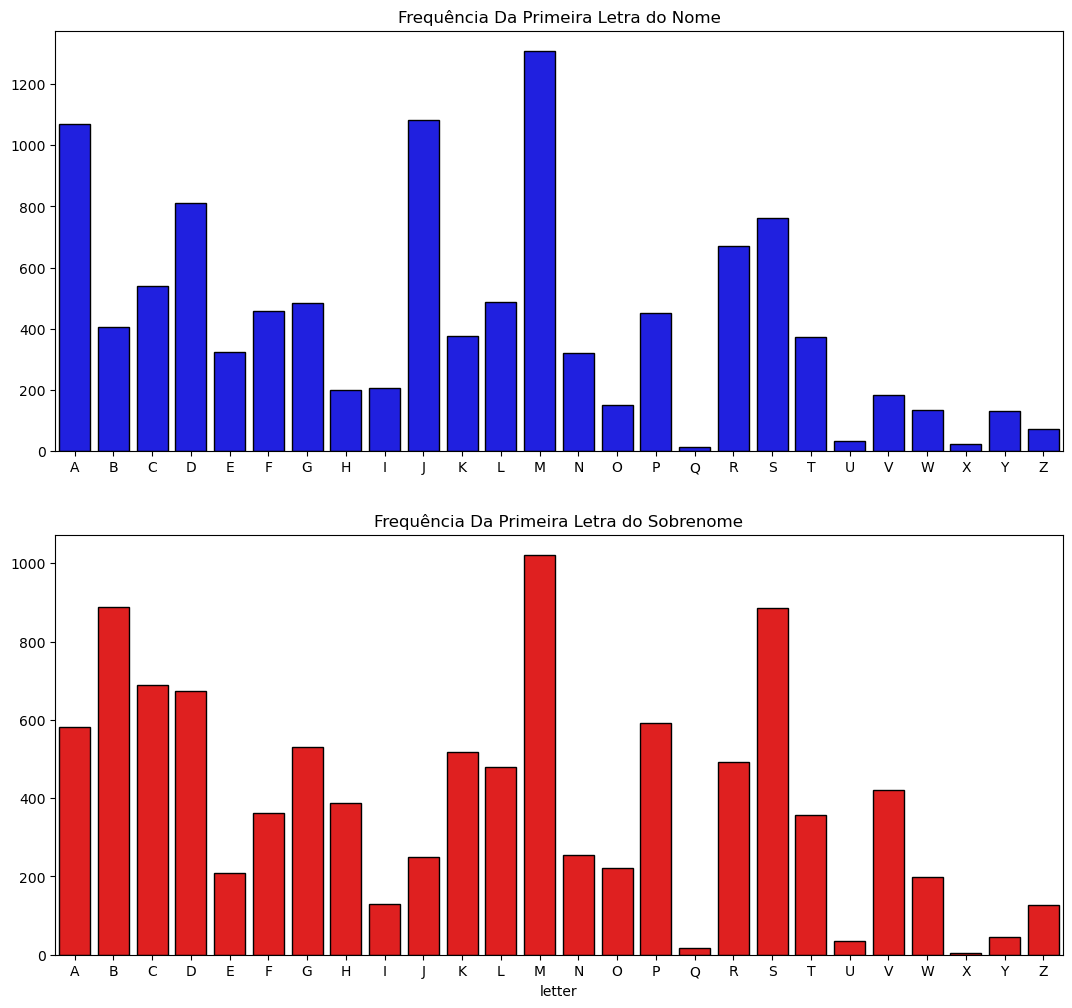

In [275]:
first = pd.DataFrame(player["player_name"].str.split(" ").str[0].str.upper().str[:1].value_counts())
last = pd.DataFrame(player["player_name"].str.split(" ").str[1].str.upper().str[:1].value_counts())
lets = first.merge(last,left_index=True,right_index=True,how="left").reset_index()
lets = lets.rename(columns={"index":"letter","player_name_x":'first_name',"player_name_y":"last_name"}).sort_values(by="letter",ascending = True)

plt.figure(figsize=(13,12))
plt.subplot(211)
sns.barplot(data=lets,x="letter",y="first_name",color="b",
            linewidth = 1,edgecolor = ["k" for i in range(26)])

plt.ylabel("")
plt.xlabel("")
plt.title("Frequência Da Primeira Letra do Nome")
plt.subplot(212)
sns.barplot(data=lets,x="letter",y="last_name",color="r",
            linewidth = 1,edgecolor = ["k" for i in range(26)])

plt.ylabel("")
plt.title("Frequência Da Primeira Letra do Sobrenome")
plt.show()

Juntar dados dos Jogadores com seus Atributos

In [119]:
list(player_attributes)

['id',
 'player_fifa_api_id',
 'player_api_id',
 'date',
 'overall_rating',
 'potential',
 'preferred_foot',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes']

In [120]:
player_attributes

id  player_fifa_api_id  player_api_id                 date  \
0            1              218353         505942  2016-02-18 00:00:00   
1            2              218353         505942  2015-11-19 00:00:00   
2            3              218353         505942  2015-09-21 00:00:00   
3            4              218353         505942  2015-03-20 00:00:00   
4            5              218353         505942  2007-02-22 00:00:00   
...        ...                 ...            ...                  ...   
183973  183974              102359          39902  2009-08-30 00:00:00   
183974  183975              102359          39902  2009-02-22 00:00:00   
183975  183976              102359          39902  2008-08-30 00:00:00   
183976  183977              102359          39902  2007-08-30 00:00:00   
183977  183978              102359          39902  2007-02-22 00:00:00   

        overall_rating  potential preferred_foot attacking_work_rate  \
0                 67.0       71.0          right              medium   
1                 67.0       71.0          right              medium   
2                 62.0       66.0          right              medium   
3                 61.0       65.0          right              medium   
4                 61.0       65.0          right              medium   
...                ...        ...            ...                 ...   
183973            83.0       85.0          right              medium   
183974            78.0       80.0          right              medium   
183975            77.0       80.0          right              medium   
183976            78.0       81.0          right              medium   
183977            80.0       81.0          right              medium   

       defensive_work_rate  crossing  ...  vision  penalties  marking  \
0                   medium      49.0  ...    54.0       48.0     65.0   
1                   medium      49.0  ...    54.0       48.0     65.0   
2                   medium      49.0  ...    54.0       48.0     65.0   
3                   medium      48.0  ...    53.0       47.0     62.0   
4                   medium      48.0  ...    53.0       47.0     62.0   
...                    ...       ...  ...     ...        ...      ...   
183973                 low      84.0  ...    88.0       83.0     22.0   
183974                 low      74.0  ...    88.0       70.0     32.0   
183975                 low      74.0  ...    88.0       70.0     32.0   
183976                 low      74.0  ...    88.0       53.0     28.0   
183977                 low      74.0  ...    88.0       53.0     38.0   

        standing_tackle  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
0                  69.0            69.0        6.0         11.0        10.0   
1                  69.0            69.0        6.0         11.0        10.0   
2                  66.0            69.0        6.0         11.0        10.0   
3                  63.0            66.0        5.0         10.0         9.0   
4                  63.0            66.0        5.0         10.0         9.0   
...                 ...             ...        ...          ...         ...   
183973             31.0            30.0        9.0         20.0        84.0   
183974             31.0            30.0        9.0         20.0        73.0   
183975             31.0            30.0        9.0         20.0        73.0   
183976             32.0            30.0        9.0         20.0        73.0   
183977             32.0            30.0        9.0          9.0        78.0   

        gk_positioning  gk_reflexes  
0                  8.0          8.0  
1                  8.0          8.0  
2                  8.0          8.0  
3                  7.0          7.0  
4                  7.0          7.0  
...                ...          ...  
183973            20.0         20.0  
183974            20.0         20.0  
183975            20.0         20.0  
183976            20.0         20.0  
183977        

In [121]:
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  weight_kg  height_m        bmi  year  \
0  1992-02-29 00:00:00  182.88     187  84.821704    1.8288  25.361478  1992   
1  1989-12-15 00:00:00  170.18     146  66.224432    1.7018  22.866579  1989   
2  1991-05-13 00:00:00  170.18     163  73.935496    1.7018  25.529126  1991   
3  1982-05-08 00:00:00  182.88     198  89.811216    1.8288  26.853330  1982   
4  1979-11-08 00:00:00  182.88     154  69.853168    1.8288  20.885923  1979   

   age fl  
0   30  A  
1   33  A  
2   31  A  
3   40  A  
4   43  A

In [276]:
player_info = player_attributes.merge(player,left_on="player_api_id",right_on="player_api_id",how="left")

i =["id_x","id_y",'player_fifa_api_id_y','height', 'weight', 'weight_kg', 'height_m', 'bmi', 'year','age','birthday', 'fl']
player_info = player_info[[x for x in player_info.columns if x not in i]]
player_info.columns

player_info["date"] = pd.to_datetime(player_info["date"],format="%Y-%m-%d")

In [277]:
player_info

player_fifa_api_id_x  player_api_id       date  overall_rating  \
0                     218353         505942 2016-02-18            67.0   
1                     218353         505942 2015-11-19            67.0   
2                     218353         505942 2015-09-21            62.0   
3                     218353         505942 2015-03-20            61.0   
4                     218353         505942 2007-02-22            61.0   
...                      ...            ...        ...             ...   
183973                102359          39902 2009-08-30            83.0   
183974                102359          39902 2009-02-22            78.0   
183975                102359          39902 2008-08-30            77.0   
183976                102359          39902 2007-08-30            78.0   
183977                102359          39902 2007-02-22            80.0   

        potential preferred_foot attacking_work_rate defensive_work_rate  \
0            71.0          right              medium              medium   
1            71.0          right              medium              medium   
2            66.0          right              medium              medium   
3            65.0          right              medium              medium   
4            65.0          right              medium              medium   
...           ...            ...                 ...                 ...   
183973       85.0          right              medium                 low   
183974       80.0          right              medium                 low   
183975       80.0          right              medium                 low   
183976       81.0          right              medium                 low   
183977       81.0          right              medium                 low   

        crossing  finishing  ...  penalties  marking  standing_tackle  \
0           49.0       44.0  ...       48.0     65.0             69.0   
1           49.0       44.0  ...       48.0     65.0             69.0   
2           49.0       44.0  ...       48.0     65.0             66.0   
3           48.0       43.0  ...       47.0     62.0             63.0   
4           48.0       43.0  ...       47.0     62.0             63.0   
...          ...        ...  ...        ...      ...              ...   
183973      84.0       77.0  ...       83.0     22.0             31.0   
183974      74.0       76.0  ...       70.0     32.0             31.0   
183975      74.0       71.0  ...       70.0     32.0             31.0   
183976      74.0       64.0  ...       53.0     28.0             32.0   
183977      74.0       68.0  ...       53.0     38.0             32.0   

        sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0                 69.0        6.0         11.0        10.0             8.0   
1                 69.0        6.0         11.0        10.0             8.0   
2                 69.0        6.0         11.0        10.0             8.0   
3                 66.0        5.0         10.0         9.0             7.0   
4                 66.0        5.0         10.0         9.0             7.0   
...                ...        ...          ...         ...             ...   
183973            30.0        9.0         20.0        84.0            20.0   
183974            30.0        9.0         20.0        73.0            20.0   
183975            30.0        9.0         20.0        73.0            20.0   
183976            30.0        9.0         20.0        73.0            20.0   
183977            30.0        9.0          9.0        78.0             7.0   

        gk_reflexes         player_name  
0               8.0  Aaron Appindangoye  
1               8.0  Aaron Appindangoye  
2               8.0  Aaron Appindangoye  
3               7.0  Aaron Appindangoye  
4               7.0  Aaron Appindangoye  
...             ...                 ...  
183973         20.0  Zvjezdan Misimovic  
183974         20.0  Zvjezdan Misimovic  
183975        

In [124]:
player_info["player_fifa_api_id_x"].value_counts().sort_values()[-20:]

186627    46
182495    47
112847    47
125995    47
137494    47
184826    48
102056    48
1625      48
153048    48
198394    50
179605    50
183284    50
41635     51
168650    52
184267    53
173210    53
155887    54
193061    56
178393    56
184431    96
Name: player_fifa_api_id_x, dtype: int64

In [125]:
player_info["player_name"].value_counts().sort_values()[-20:]

Roberto Pereyra     56
Alessio Cerci       56
Juan                58
David Lopez         60
Carlos Eduardo      63
Paulinho            63
Diego               64
Juan Carlos         65
Marcelo             66
Rafael              67
Scott Brown         71
Maicon              73
Rafinha             75
Fernando            75
Josue               77
Ricardo             84
Felipe              89
Douglas             93
Alex               104
Danilo             108
Name: player_name, dtype: int64

In [126]:
player_info[player_info["player_name"] == 'David Lopez']

player_fifa_api_id_x  player_api_id       date  overall_rating  \
39823                201505         215584 2016-05-05            76.0   
39824                201505         215584 2016-04-21            76.0   
39825                201505         215584 2016-01-14            76.0   
39826                201505         215584 2015-12-10            77.0   
39827                201505         215584 2015-10-23            77.0   
39828                201505         215584 2015-09-21            77.0   
39829                201505         215584 2015-04-17            76.0   
39830                201505         215584 2015-03-20            76.0   
39831                201505         215584 2015-02-06            76.0   
39832                201505         215584 2014-11-14            74.0   
39833                201505         215584 2014-11-07            74.0   
39834                201505         215584 2014-09-18            74.0   
39835                201505         215584 2014-04-11            72.0   
39836                201505         215584 2013-10-11            69.0   
39837                201505         215584 2013-09-20            67.0   
39838                201505         215584 2013-05-31            64.0   
39839                201505         215584 2013-05-24            64.0   
39840                201505         215584 2013-05-17            62.0   
39841                201505         215584 2013-02-15            62.0   
39842                201505         215584 2012-08-31            60.0   
39843                201505         215584 2011-02-22            60.0   
39844                201505         215584 2007-02-22            60.0   
39845                112628          33866 2016-03-10            70.0   
39846                112628          33866 2015-10-23            70.0   
39847                112628          33866 2015-10-16            70.0   
39848                112628          33866 2015-09-21            70.0   
39849                112628          33866 2015-05-08            69.0   
39850                112628          33866 2015-02-20            69.0   
39851                112628          33866 2014-12-05            69.0   
39852                112628          33866 2014-10-31            69.0   
39853                112628          33866 2014-10-24            69.0   
39854                112628          33866 2014-09-18            69.0   
39855                112628          33866 2014-05-02            70.0   
39856                112628          33866 2014-04-11            70.0   
39857                112628          33866 2014-03-21            70.0   
39858                112628          33866 2014-02-14            70.0   
39859                112628          33866 2014-02-07            71.0   
39860                112628          33866 2014-01-24            71.0   
39861                112628          33866 2013-09-20            71.0   
39862                112628          33866 2013-08-16            71.0   
39863                112628          33866 2013-05-17            71.0   
39864                112628          33866 2013-05-10            71.0   
39865                112628          33866 2013-04-26            71.0   
39866                112628          33866 2013-04-12            71.0   
39867                112628          33866 2013-03-28            71.0   
39868                112628          33866 2013-03-22            70.0   
39869                112628          33866 2013-03-15            70.0   
39870                112628          33866 2013-02-22            70.0   
39871                112628          33866 2013-02-15            72.0   
39872                112628          33866 2012-08-31            72.0   
39873                112628          33866 2012-02-22            73.0   
39874                112628          33866 2011-08-30            74.0   
39875                112628          33866 2011-02-22            74.0   
39876                112628          33866 2010-08-30            

### Jogadores que Jogaram mais Jogos

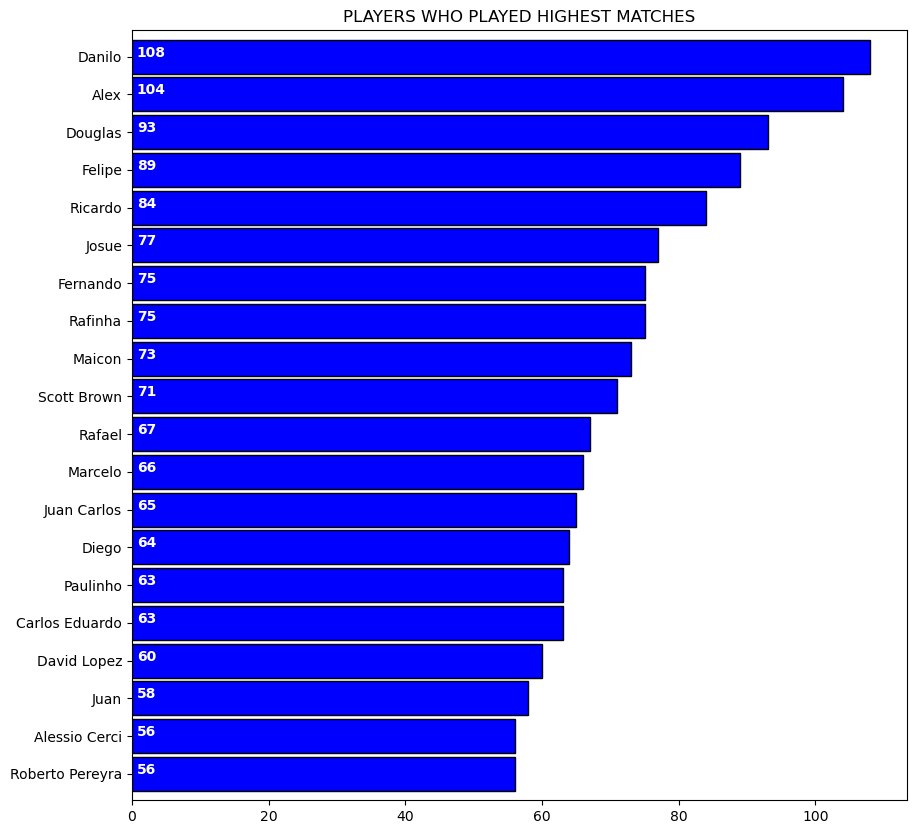

In [128]:
ax = player_info["player_name"].value_counts().sort_values()[-20:].plot(kind="barh",figsize=(10,10),
                                                                        color="b",width=.9,
                                                                        linewidth = 1,edgecolor = ["k" for i in range(20)]
                                                                       )

for i,j in enumerate(player_info["player_name"].value_counts().sort_values()[-20:].values):
    ax.text(.7,i,j,weight = "bold",color="white")

ax.set_title("PLAYERS WHO PLAYED HIGHEST MATCHES")
plt.show()

### WordCloud para Nomes dos Jogadores

In [278]:
from wordcloud import WordCloud

In [279]:
from PIL import Image

In [280]:
i = Image.open("z.jpg")

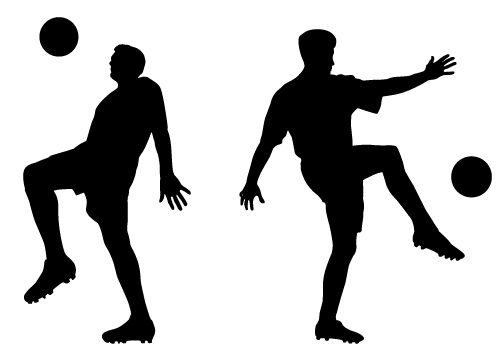

In [281]:
i

In [142]:
im = np.array(i)

In [145]:
im

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [146]:
im[0][0]

array([255, 255, 255], dtype=uint8)

In [147]:
im[0][0] = [42, 91, 140]

In [148]:
im

array([[[ 42,  91, 140],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [149]:
img = Image.fromarray(im, 'RGB')

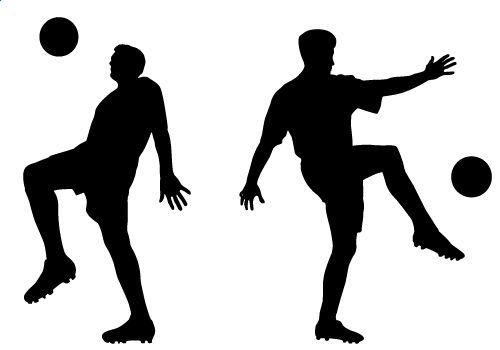

In [150]:
img

In [151]:
im[10]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [152]:
for i,j in enumerate(im[10]):
    im[10][i] = [10, 15, 70]

In [153]:
im[10]

array([[10, 15, 70],
       [10, 15, 70],
       [10, 15, 70],
       ...,
       [10, 15, 70],
       [10, 15, 70],
       [10, 15, 70]], dtype=uint8)

In [154]:
img = Image.fromarray(im, 'RGB')

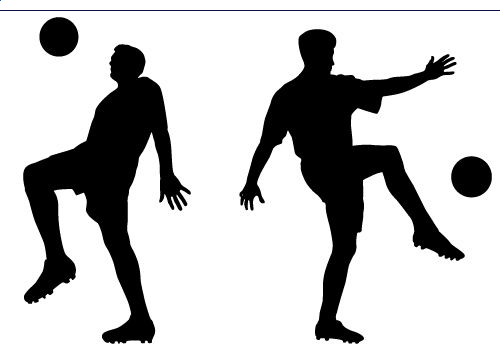

In [155]:
img

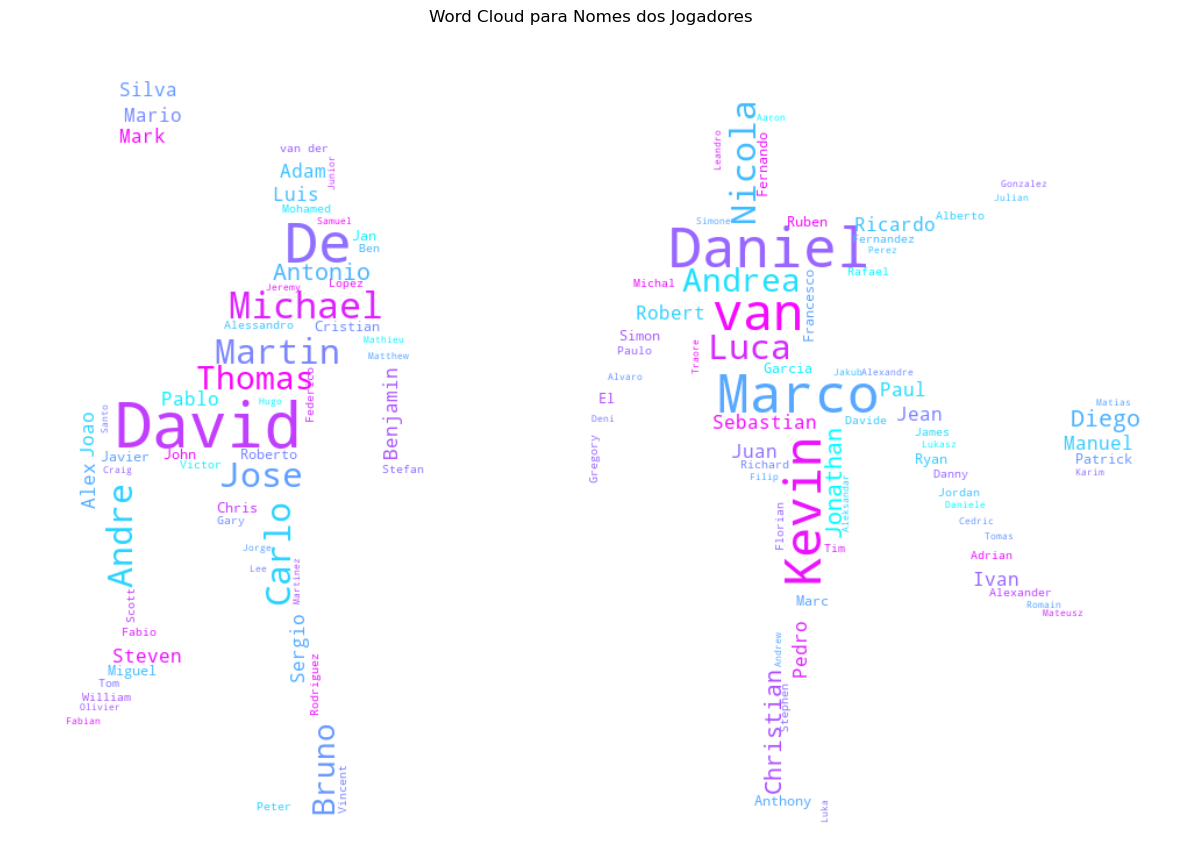

In [282]:
play = player_info["player_name"].unique()
img = np.array(Image.open("z.jpg"))
wc = WordCloud(background_color="white",scale=2,mask=img,colormap="cool",max_words=100000).generate(" ".join(play))
fig = plt.figure(figsize=(15,15))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud para Nomes dos Jogadores")
plt.show()

In [157]:
player_info.groupby(["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()["preferred_foot"].value_counts()

right    8979
left     3202
Name: preferred_foot, dtype: int64

### Pés Preferidos dos Jogadores

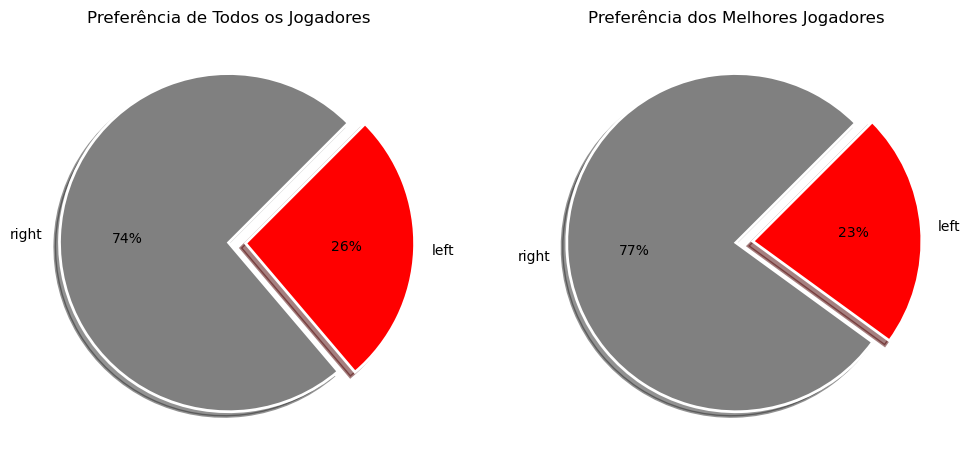

In [158]:
plt.figure(figsize=(12,6))

plt.subplot(121)
pf = player_info.groupby(["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()["preferred_foot"].value_counts()
pf.plot.pie(autopct = "%1.0f%%",shadow = True,
            wedgeprops={"linewidth":2,"edgecolor":"white"},
            colors=["grey","r"],explode=[0,.1],startangle=45)

plt.title("Preferência de Todos os Jogadores")
plt.ylabel("")

plt.subplot(122)
t_f = player_info.groupby(["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()
t_f[t_f["overall_rating"] > 80]["preferred_foot"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                          shadow = True,
                                                                          wedgeprops={"linewidth":2,"edgecolor":"white"},
                                                                          colors=["grey","r"],
                                                                          explode=[0,.1],
                                                                          startangle=45)

plt.title("Preferência dos Melhores Jogadores")
plt.ylabel("")
plt.show()

### Estatísticas dos Melhores Jogadores (rating > 91)

In [159]:
player_info.head()

player_fifa_api_id_x  player_api_id       date  overall_rating  potential  \
0                218353         505942 2016-02-18            67.0       71.0   
1                218353         505942 2015-11-19            67.0       71.0   
2                218353         505942 2015-09-21            62.0       66.0   
3                218353         505942 2015-03-20            61.0       65.0   
4                218353         505942 2007-02-22            61.0       65.0   

  preferred_foot attacking_work_rate defensive_work_rate  crossing  finishing  \
0          right              medium              medium      49.0       44.0   
1          right              medium              medium      49.0       44.0   
2          right              medium              medium      49.0       44.0   
3          right              medium              medium      48.0       43.0   
4          right              medium              medium      48.0       43.0   

   ...  penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0  ...       48.0     65.0             69.0            69.0        6.0   
1  ...       48.0     65.0             69.0            69.0        6.0   
2  ...       48.0     65.0             66.0            69.0        6.0   
3  ...       47.0     62.0             63.0            66.0        5.0   
4  ...       47.0     62.0             63.0            66.0        5.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes         player_name  
0         11.0        10.0             8.0          8.0  Aaron Appindangoye  
1         11.0        10.0             8.0          8.0  Aaron Appindangoye  
2         11.0        10.0             8.0          8.0  Aaron Appindangoye  
3         10.0         9.0             7.0          7.0  Aaron Appindangoye  
4         10.0         9.0             7.0          7.0  Aaron Appindangoye  

[5 rows x 42 columns]

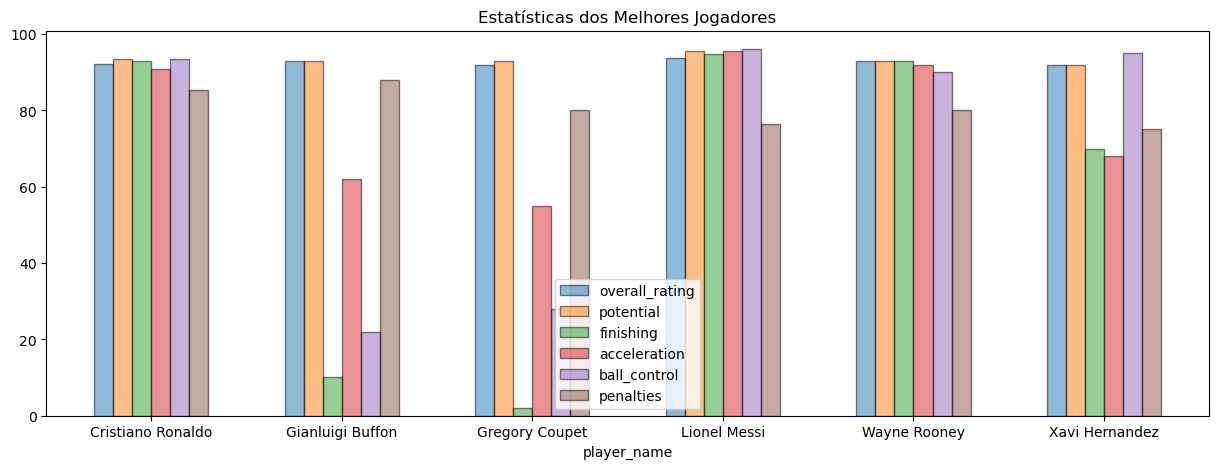

In [283]:
top_rated = player_info[player_info["overall_rating"]  > 91 ]
top_rated = top_rated[['player_name','player_api_id', 'date', 
                       'overall_rating','potential','finishing','acceleration',
                       'ball_control' ,'penalties']]

top_rated = top_rated.groupby("player_name").agg({'overall_rating':"mean",'potential':"mean",
                                                  'finishing':"mean",'acceleration':"mean",
                                                  'ball_control':"mean" ,'penalties':"mean"})

top_rated.plot(kind="bar",width=.6,figsize=(15,5)
               ,alpha=.5,
              linewidth = 1,edgecolor = ["k" for i in range(0,6)])

plt.title("Estatísticas dos Melhores Jogadores")
plt.xticks(rotation = 0)
plt.legend(loc ="lower center")
plt.show()

### Comparador de Jogadores

In [161]:
idx  = "player_api_id"
cols = ['overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']

In [162]:
x1 = player_info[player_info["player_name"] == 'Lionel Messi']
x1 = x1.groupby(["player_name"])[cols].mean()
x1

overall_rating  potential   crossing  finishing  \
player_name                                                     
Lionel Messi       92.192308  95.230769  83.346154  92.230769   

              heading_accuracy  short_passing    volleys  dribbling  \
player_name                                                           
Lionel Messi         69.269231      88.807692  87.538462  96.461538   

                  curve  free_kick_accuracy  ...   strength  long_shots  \
player_name                                  ...                          
Lionel Messi  87.692308           84.115385  ...  59.692308   86.923077   

              aggression  interceptions  positioning     vision  penalties  \
player_name                                                                  
Lionel Messi   49.269231      34.230769    90.538462  90.269231  80.153846   

                marking  standing_tackle  sliding_tackle  
player_name                                               
Lionel Messi  18.769231        21.846154       20.115385  

[1 rows x 30 columns]

In [163]:
x2 = player_info[player_info["player_name"] == 'Cristiano Ronaldo']
x2 = x2.groupby(["player_name"])[cols].mean()
x2

overall_rating  potential  crossing  finishing  \
player_name                                                         
Cristiano Ronaldo           91.28      93.48     83.88      91.12   

                   heading_accuracy  short_passing  volleys  dribbling  curve  \
player_name                                                                     
Cristiano Ronaldo             85.52          82.28    85.56      92.64   88.0   

                   free_kick_accuracy  ...  strength  long_shots  aggression  \
player_name                            ...                                     
Cristiano Ronaldo               81.64  ...     78.68       89.88       61.28   

                   interceptions  positioning  vision  penalties  marking  \
player_name                                                                 
Cristiano Ronaldo          35.64        86.48   80.68       83.6    22.12   

                   standing_tackle  sliding_tackle  
player_name                                         
Cristiano Ronaldo            30.84            23.0  

[1 rows x 30 columns]

In [164]:
pd.concat([x1,x2])

overall_rating  potential   crossing  finishing  \
player_name                                                          
Lionel Messi            92.192308  95.230769  83.346154  92.230769   
Cristiano Ronaldo       91.280000  93.480000  83.880000  91.120000   

                   heading_accuracy  short_passing    volleys  dribbling  \
player_name                                                                
Lionel Messi              69.269231      88.807692  87.538462  96.461538   
Cristiano Ronaldo         85.520000      82.280000  85.560000  92.640000   

                       curve  free_kick_accuracy  ...   strength  long_shots  \
player_name                                       ...                          
Lionel Messi       87.692308           84.115385  ...  59.692308   86.923077   
Cristiano Ronaldo  88.000000           81.640000  ...  78.680000   89.880000   

                   aggression  interceptions  positioning     vision  \
player_name                                                            
Lionel Messi        49.269231      34.230769    90.538462  90.269231   
Cristiano Ronaldo   61.280000      35.640000    86.480000  80.680000   

                   penalties    marking  standing_tackle  sliding_tackle  
player_name                                                               
Lionel Messi       80.153846  18.769231        21.846154       20.115385  
Cristiano Ronaldo  83.600000  22.120000        30.840000       23.000000  

[2 rows x 30 columns]

In [165]:
z = pd.concat([x1,x2]).transpose().reset_index()
z  = z.rename(columns={"index":"attributes"})
z.index = z.attributes
z

player_name                 attributes  Lionel Messi  Cristiano Ronaldo
attributes                                                             
overall_rating          overall_rating     92.192308              91.28
potential                    potential     95.230769              93.48
crossing                      crossing     83.346154              83.88
finishing                    finishing     92.230769              91.12
heading_accuracy      heading_accuracy     69.269231              85.52
short_passing            short_passing     88.807692              82.28
volleys                        volleys     87.538462              85.56
dribbling                    dribbling     96.461538              92.64
curve                            curve     87.692308              88.00
free_kick_accuracy  free_kick_accuracy     84.115385              81.64
long_passing              long_passing     76.615385              71.72
ball_control              ball_control     95.769231              93.96
acceleration              acceleration     95.307692              91.64
sprint_speed              sprint_speed     90.846154              93.76
agility                        agility     94.384615              92.96
reactions                    reactions     92.538462              88.16
balance                        balance     92.230769              74.32
shot_power                  shot_power     80.307692              92.76
jumping                        jumping     69.653846              93.04
stamina                        stamina     77.538462              87.60
strength                      strength     59.692308              78.68
long_shots                  long_shots     86.923077              89.88
aggression                  aggression     49.269231              61.28
interceptions            interceptions     34.230769              35.64
positioning                positioning     90.538462              86.48
vision                          vision     90.269231              80.68
penalties                    penalties     80.153846              83.60
marking                        marking     18.769231              22.12
standing_tackle        standing_tackle     21.846154              30.84
sliding_tackle          sliding_tackle     20.115385              23.00

In [166]:
def player_comparator(player1,player2):
    
    x1 = player_info[player_info["player_name"] == player1]
    x1 = x1.groupby(["player_name"])[cols].mean()
    
    x2 = player_info[player_info["player_name"] == player2]
    x2 = x2.groupby(["player_name"])[cols].mean()
    
    z  = pd.concat([x1,x2]).transpose().reset_index()
    z  = z.rename(columns={"index":"attributes",player1:player1,player2:player2})
    z.index = z.attributes
    z[[player1,player2]].plot(kind = "barh",
                            figsize = (8,12),
                            #colors = ["orange","grey"],
                            linewidth = 1 ,
                            width = .7,
                            edgecolor = ["k"]*z["attributes"].nunique()
                            )
    plt.xlabel("mean value")
    plt.legend(loc = "best",prop = {"size" : 15})
    plt.grid(True,alpha = .3)
    plt.title(player1+"  vs  "+player2)
    plt.show()

### MESSI VS RONALDO

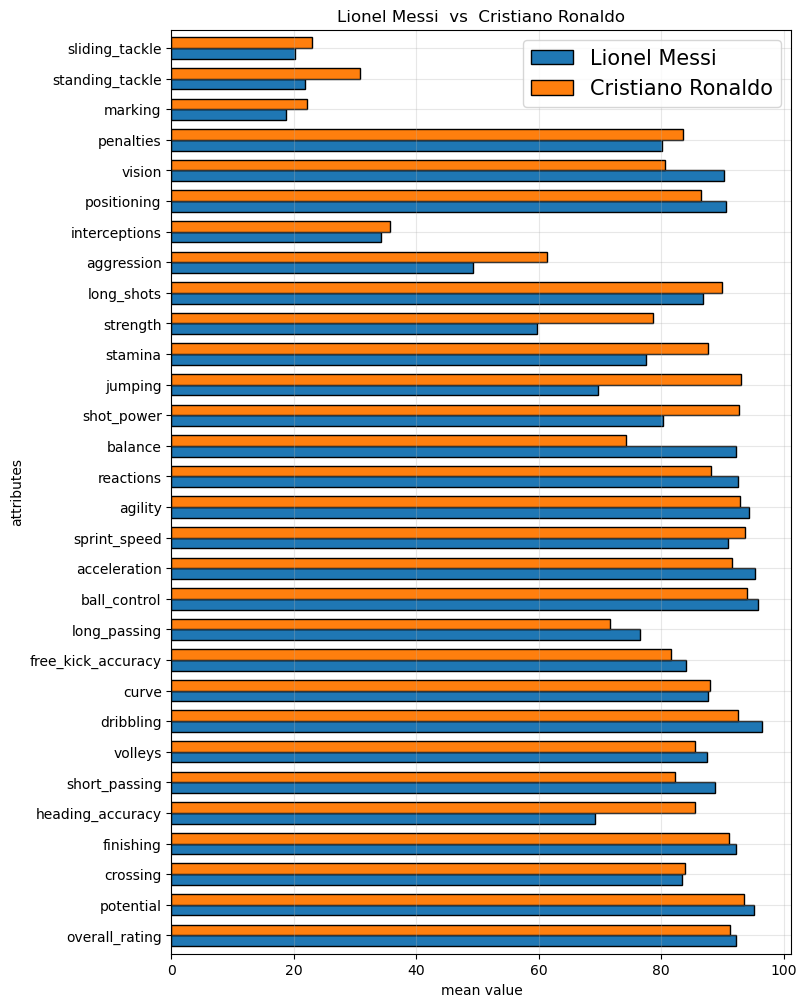

In [168]:
player_comparator('Lionel Messi','Cristiano Ronaldo') #Xavi Hernandez

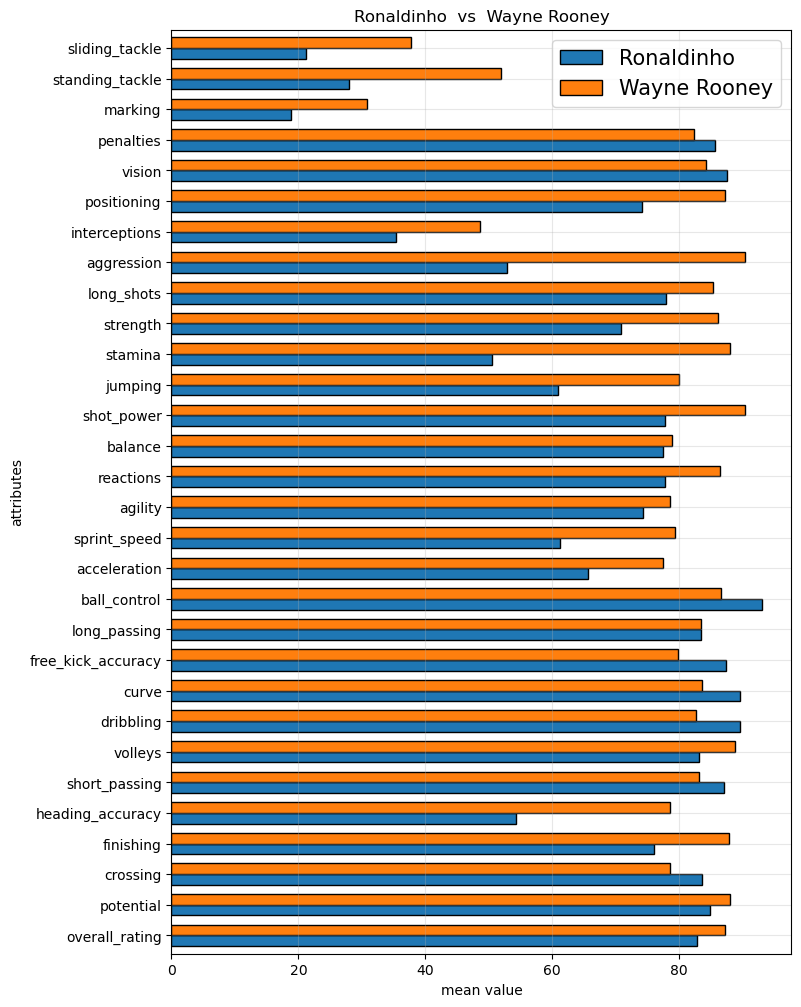

In [169]:
player_comparator('Ronaldinho','Wayne Rooney')

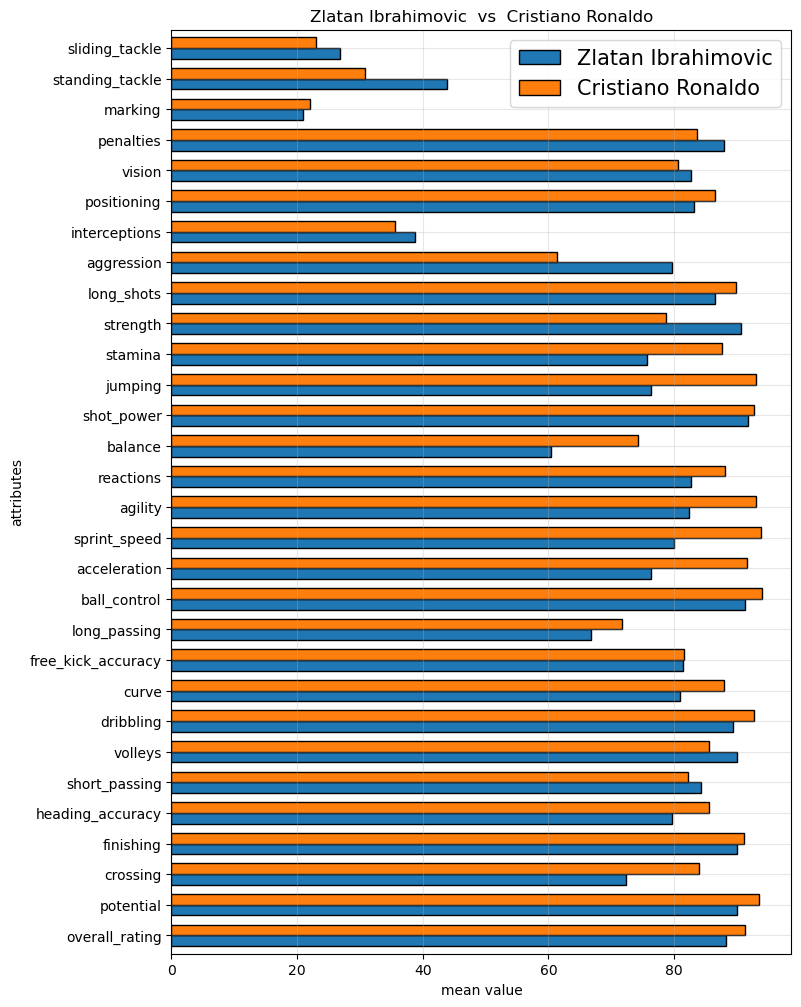

In [170]:
player_comparator('Zlatan Ibrahimovic','Cristiano Ronaldo')

### Goleiro

In [171]:
goal_keeper = player_info[["player_api_id",'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning','gk_reflexes', 'player_name',"overall_rating"]]
goal_keeper = goal_keeper[(goal_keeper["gk_diving"]>75) & (goal_keeper["gk_handling"]>75)
                          & (goal_keeper["gk_kicking"]>75)& (goal_keeper["gk_positioning"]>75)
                          & (goal_keeper["gk_reflexes"]>75) ]
goal_keeper = goal_keeper.groupby(["player_api_id","player_name"])[['gk_diving', 'gk_handling', 'gk_kicking',
                                    'gk_positioning', 'gk_reflexes', 'overall_rating']].mean()
goal_keeper = goal_keeper.sort_values(by="overall_rating",ascending =False).reset_index()
goal_keeper.index = goal_keeper["player_name"]

In [172]:
goal_keeper

player_api_id         player_name  gk_diving  gk_handling  \
player_name                                                                     
Gianluigi Buffon            30717    Gianluigi Buffon  90.250000    92.000000   
Gregory Coupet              39989      Gregory Coupet  90.500000    90.500000   
Manuel Neuer                27299        Manuel Neuer  87.750000    82.875000   
Sebastian Frey              24503      Sebastian Frey  87.000000    89.000000   
Petr Cech                   30859           Petr Cech  88.272727    83.454545   
...                           ...                 ...        ...          ...   
Vladimir Stojkovic          33439  Vladimir Stojkovic  77.000000    78.000000   
Antonio Adan                40648        Antonio Adan  76.000000    81.000000   
Mariano Andujar             39415     Mariano Andujar  76.000000    78.000000   
Ivan Cuellar                33630        Ivan Cuellar  78.000000    79.000000   
Justo Villar                30990        Justo Villar  77.000000    78.000000   

                    gk_kicking  gk_positioning  gk_reflexes  overall_rating  
player_name                                                                  
Gianluigi Buffon     79.750000       95.000000    91.250000       91.000000  
Gregory Coupet       80.500000       90.000000    86.500000       88.500000  
Manuel Neuer         90.875000       84.916667    86.833333       87.541667  
Sebastian Frey       79.000000       92.000000    90.000000       87.000000  
Petr Cech            78.454545       86.545455    88.909091       86.090909  
...                        ...             ...          ...             ...  
Vladimir Stojkovic   84.000000       80.000000    88.000000       78.000000  
Antonio Adan         77.000000       78.000000    80.000000       77.000000  
Mariano Andujar      77.000000       78.000000    79.000000       77.000000  
Ivan Cuellar         77.000000       76.000000    78.000000       76.000000  
Justo Villar         76.000000       76.000000    77.000000       75.000000  

[81 rows x 8 columns]

### Estatísticas dos Melhores Goleiros

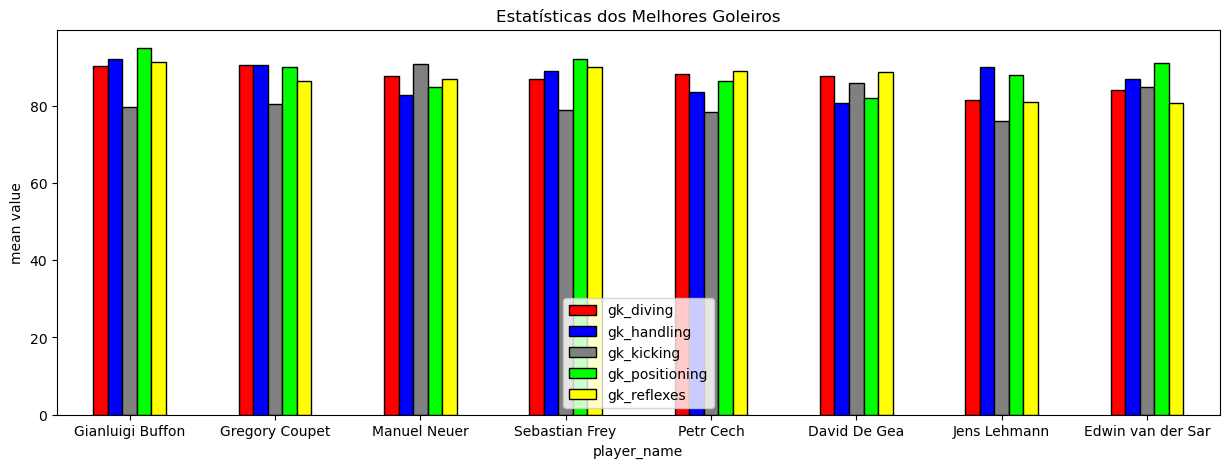

In [175]:
goal_keeper[['gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes']][:8].plot(kind = "bar",figsize=(15,5),
                                                  color =["r","b","grey","lime","yellow"],
                                                  linewidth = 1,
                                                  edgecolor = ["k" for i in range(10)]
                                                 )

plt.xticks(rotation =0)
plt.legend(loc ="lower center")
plt.ylabel("mean value")
plt.title("Estatísticas dos Melhores Goleiros")
plt.show()

### Gráficos Radar para Jogadores e Seus Atributos

In [176]:
from math import pi

In [177]:
string = ['Andres Iniesta','Cristiano Ronaldo', 'Lionel Messi','Luis Suarez','Neymar', 'Ronaldinho','Wayne Rooney','Zlatan Ibrahimovic']
play   = player_info[player_info["player_name"].isin(string)]
cols   = ["player_name",'overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'standing_tackle', 'sliding_tackle']
play = play[cols]
play = play.groupby("player_name")[cols].mean().reset_index()

In [178]:
play

player_name  overall_rating  potential   crossing  finishing  \
0      Andres Iniesta       88.320000  90.560000  83.720000  72.680000   
1   Cristiano Ronaldo       91.280000  93.480000  83.880000  91.120000   
2        Lionel Messi       92.192308  95.230769  83.346154  92.230769   
3         Luis Suarez       85.275000  87.525000  75.675000  85.650000   
4              Neymar       83.800000  90.760000  70.320000  83.480000   
5          Ronaldinho       82.840000  84.880000  83.520000  75.960000   
6        Wayne Rooney       87.222222  87.944444  78.472222  87.861111   
7  Zlatan Ibrahimovic       88.285714  90.047619  72.380952  90.000000   

   heading_accuracy  short_passing    volleys  dribbling      curve  ...  \
0         55.320000      93.880000  74.000000  90.080000  80.000000  ...   
1         85.520000      82.280000  85.560000  92.640000  88.000000  ...   
2         69.269231      88.807692  87.538462  96.461538  87.692308  ...   
3         72.100000      79.175000  83.475000  87.875000  84.300000  ...   
4         63.320000      75.680000  81.240000  91.600000  76.520000  ...   
5         54.200000      87.080000  83.120000  89.560000  89.600000  ...   
6         78.583333      83.138889  88.694444  82.694444  83.500000  ...   
7         79.714286      84.238095  90.047619  89.380952  80.952381  ...   

     stamina   strength  long_shots  aggression  interceptions  positioning  \
0  77.720000  60.480000   76.160000   59.400000      72.360000    88.200000   
1  87.600000  78.680000   89.880000   61.280000      35.640000    86.480000   
2  77.538462  59.692308   86.923077   49.269231      34.230769    90.538462   
3  83.800000  75.000000   80.525000   75.550000      44.450000    85.125000   
4  78.320000  44.080000   72.320000   54.400000      39.040000    84.560000   
5  50.560000  70.800000   77.840000   52.800000      35.400000    74.120000   
6  88.000000  86.166667   85.361111   90.388889      48.611111    87.166667   
7  75.714286  90.571429   86.523810   79.666667      38.714286    83.095238   

      vision  penalties  standing_tackle  sliding_tackle  
0  92.920000  71.120000        59.680000       56.000000  
1  80.680000  83.600000        30.840000       23.000000  
2  90.269231  80.153846        21.846154       20.115385  
3  82.650000  83.275000        42.300000       38.000000  
4  76.840000  79.760000        26.960000       33.000000  
5  87.520000  85.680000        28.000000       21.160000  
6  84.166667  82.333333        51.833333       37.777778  
7  82.619048  88.000000        43.809524       26.809524  

[8 rows x 30 columns]

In [180]:
print(list(play))

['player_name', 'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'standing_tackle', 'sliding_tackle']


In [181]:
cats = list(play)[1:]
N    = len(cats)

In [182]:
N

29

In [183]:
print(cats)

['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'standing_tackle', 'sliding_tackle']


In [184]:
play.loc[0].drop("player_name").values.tolist()

[88.32,
 90.56,
 83.72,
 72.68,
 55.32,
 93.88,
 74.0,
 90.08,
 80.0,
 69.28,
 89.0,
 92.96,
 79.96,
 76.8,
 86.44,
 89.32,
 86.04,
 66.84,
 54.64,
 77.72,
 60.48,
 76.16,
 59.4,
 72.36,
 88.2,
 92.92,
 71.12,
 59.68,
 56.0]

In [185]:
play.loc[0].drop("player_name").values.flatten()

array([88.32, 90.56, 83.72, 72.68, 55.32, 93.88, 74.0, 90.08, 80.0, 69.28,
       89.0, 92.96, 79.96, 76.8, 86.44, 89.32, 86.04, 66.84, 54.64, 77.72,
       60.48, 76.16, 59.4, 72.36, 88.2, 92.92, 71.12, 59.68, 56.0],
      dtype=object)

In [186]:
values = play.loc[0].drop("player_name").values.flatten().tolist()
values

[88.32,
 90.56,
 83.72,
 72.68,
 55.32,
 93.88,
 74.0,
 90.08,
 80.0,
 69.28,
 89.0,
 92.96,
 79.96,
 76.8,
 86.44,
 89.32,
 86.04,
 66.84,
 54.64,
 77.72,
 60.48,
 76.16,
 59.4,
 72.36,
 88.2,
 92.92,
 71.12,
 59.68,
 56.0]

In [187]:
values = play.loc[1].drop("player_name").values.flatten().tolist()
values

[91.28,
 93.48,
 83.88,
 91.12,
 85.52,
 82.28,
 85.56,
 92.64,
 88.0,
 81.64,
 71.72,
 93.96,
 91.64,
 93.76,
 92.96,
 88.16,
 74.32,
 92.76,
 93.04,
 87.6,
 78.68,
 89.88,
 61.28,
 35.64,
 86.48,
 80.68,
 83.6,
 30.84,
 23.0]

In [188]:
[n / float(N)*2*pi for n in range(N)]

[0.0,
 0.21666156231653746,
 0.43332312463307493,
 0.6499846869496123,
 0.8666462492661499,
 1.0833078115826873,
 1.2999693738992246,
 1.5166309362157622,
 1.7332924985322997,
 1.9499540608488373,
 2.1666156231653746,
 2.3832771854819117,
 2.5999387477984492,
 2.816600310114987,
 3.0332618724315243,
 3.249923434748062,
 3.4665849970645994,
 3.6832465593811365,
 3.8999081216976745,
 4.116569684014212,
 4.333231246330749,
 4.549892808647287,
 4.766554370963823,
 4.983215933280362,
 5.1998774955968985,
 5.416539057913436,
 5.633200620229974,
 5.849862182546511,
 6.066523744863049]

In [190]:
num = [0,1,2,3,4,5,6,7]
c = ["r","y","b","c","orange","m","k","lime"]

In [191]:
for i,j,k in zip(num,range(len(num)),c):    
    values = play.loc[i].drop("player_name").values.flatten().tolist()
    values += values[:1]
    print(values)

[88.32, 90.56, 83.72, 72.68, 55.32, 93.88, 74.0, 90.08, 80.0, 69.28, 89.0, 92.96, 79.96, 76.8, 86.44, 89.32, 86.04, 66.84, 54.64, 77.72, 60.48, 76.16, 59.4, 72.36, 88.2, 92.92, 71.12, 59.68, 56.0, 88.32]
[91.28, 93.48, 83.88, 91.12, 85.52, 82.28, 85.56, 92.64, 88.0, 81.64, 71.72, 93.96, 91.64, 93.76, 92.96, 88.16, 74.32, 92.76, 93.04, 87.6, 78.68, 89.88, 61.28, 35.64, 86.48, 80.68, 83.6, 30.84, 23.0, 91.28]
[92.1923076923077, 95.23076923076923, 83.34615384615384, 92.23076923076923, 69.26923076923077, 88.8076923076923, 87.53846153846153, 96.46153846153847, 87.6923076923077, 84.11538461538461, 76.61538461538461, 95.76923076923077, 95.3076923076923, 90.84615384615384, 94.38461538461539, 92.53846153846153, 92.23076923076923, 80.3076923076923, 69.65384615384616, 77.53846153846153, 59.69230769230769, 86.92307692307692, 49.26923076923077, 34.23076923076923, 90.53846153846153, 90.26923076923077, 80.15384615384616, 21.846153846153847, 20.115384615384617, 92.1923076923077]
[85.275, 87.525, 75.67

In [192]:
values[:1]

[88.28571428571429]

In [194]:
values = play.loc[i].drop("player_name").values.flatten().tolist()

In [195]:
values

[88.28571428571429,
 90.04761904761905,
 72.38095238095238,
 90.0,
 79.71428571428571,
 84.23809523809524,
 90.04761904761905,
 89.38095238095238,
 80.95238095238095,
 81.38095238095238,
 66.76190476190476,
 91.23809523809524,
 76.28571428571429,
 80.0,
 82.28571428571429,
 82.66666666666667,
 60.476190476190474,
 91.76190476190476,
 76.38095238095238,
 75.71428571428571,
 90.57142857142857,
 86.52380952380952,
 79.66666666666667,
 38.714285714285715,
 83.0952380952381,
 82.61904761904762,
 88.0,
 43.80952380952381,
 26.80952380952381]

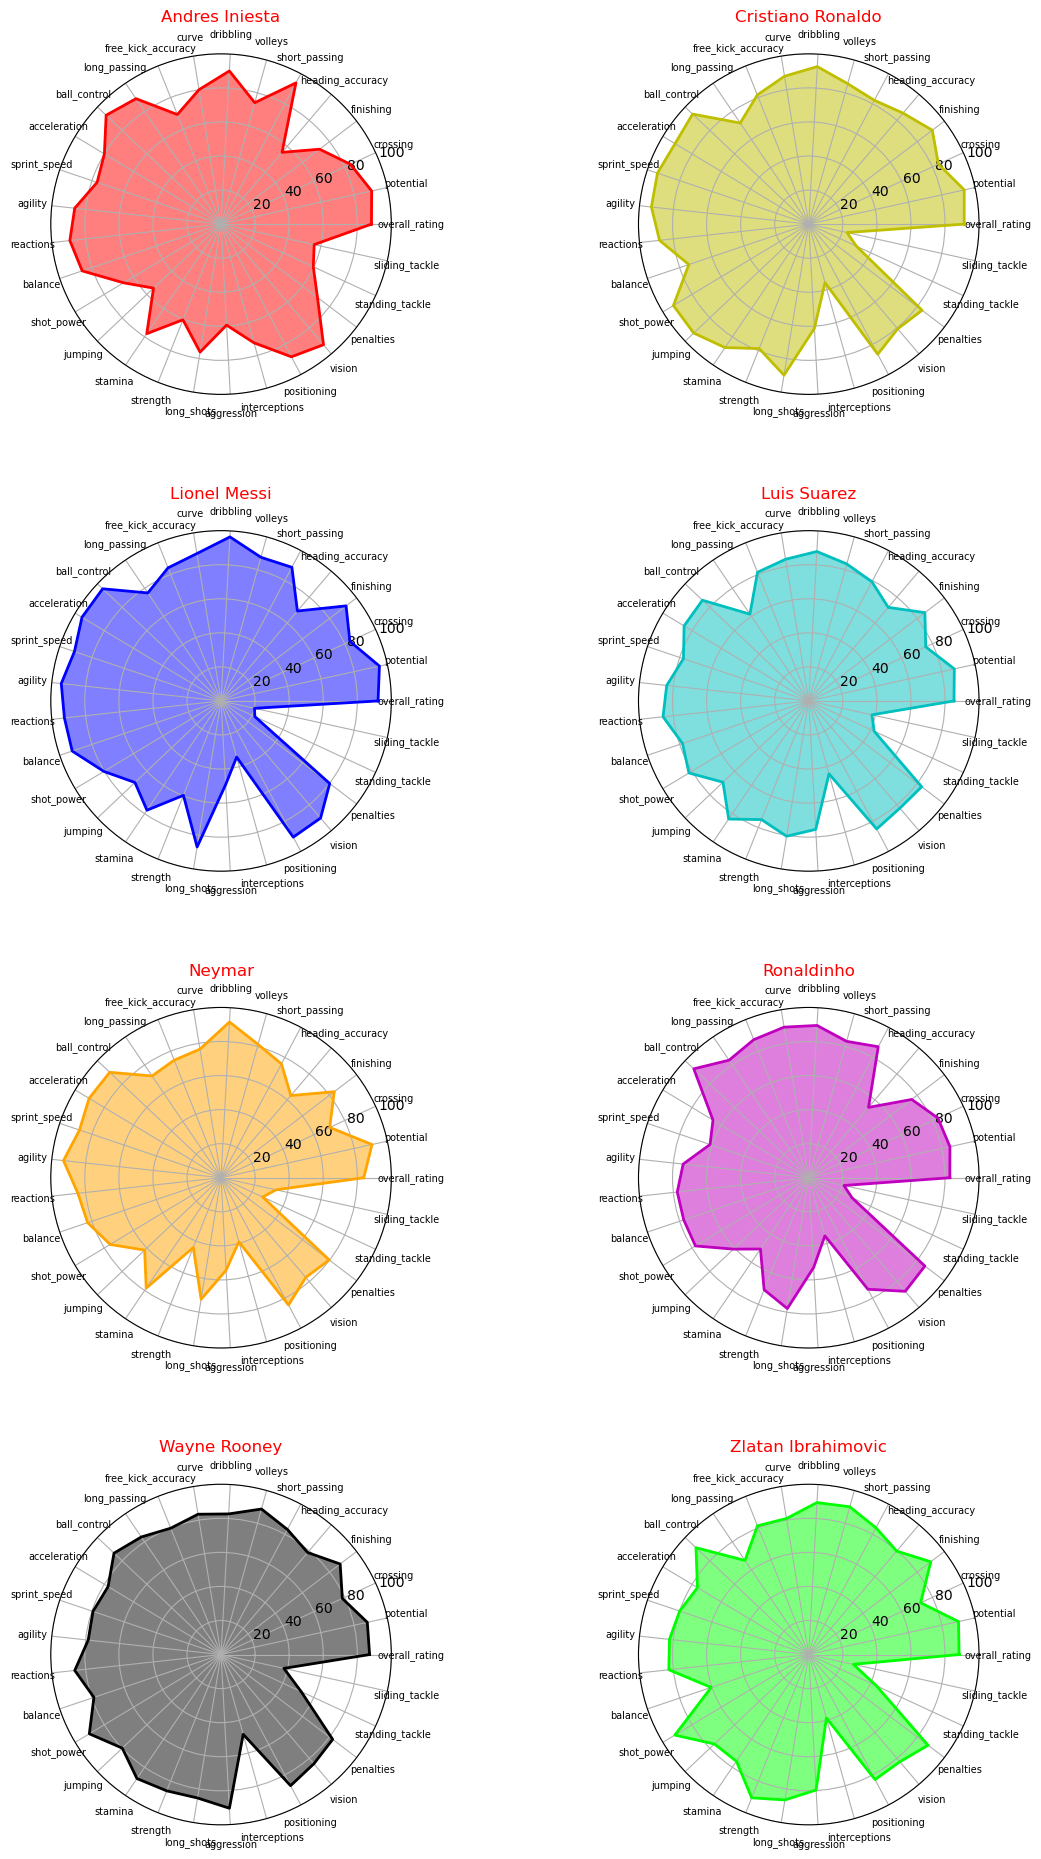

In [200]:
num = [0,1,2,3,4,5,6,7]
c = ["r","y","b","c","orange","m","k","lime"]
plt.figure(figsize=(13,23))

for i,j,k in zip(num,range(len(num)),c):
    plt.subplot(4,2,j+1,projection="polar") # IMPORTANTE
    cats = list(play)[1:]
    N    = len(cats)
    
    values = play.loc[i].drop("player_name").values.flatten().tolist()
    values += values[:1]
    values
    
    angles = [n / float(N)*2*pi for n in range(N)]
    angles += angles[:1]
    angles
    
    plt.xticks(angles[:-1],cats,color="k",size=7)
    plt.ylim([0,100])
    plt.plot(angles,values,color=k,linewidth=2,linestyle="solid")
    plt.fill(angles,values,color=k,alpha=0.5)
    plt.title(play["player_name"][i],color="r")
    plt.subplots_adjust(wspace=.4,hspace=.4)

plt.show()

# Atributos dos Times

In [201]:
team_info =  team_attributes.merge(teams,left_on="team_api_id",right_on="team_api_id",how="left")

In [202]:
team_info.head()

id_x  team_fifa_api_id_x  team_api_id                 date  \
0     1                 434         9930  2010-02-22 00:00:00   
1     2                 434         9930  2014-09-19 00:00:00   
2     3                 434         9930  2015-09-10 00:00:00   
3     4                  77         8485  2010-02-22 00:00:00   
4     5                  77         8485  2011-02-22 00:00:00   

   buildUpPlaySpeed buildUpPlaySpeedClass  buildUpPlayDribbling  \
0                60              Balanced                   NaN   
1                52              Balanced                  48.0   
2                47              Balanced                  41.0   
3                70                  Fast                   NaN   
4                47              Balanced                   NaN   

  buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  ...  \
0                    Little                  50                   Mixed  ...   
1                    Normal                  56                   Mixed  ...   
2                    Normal                  54                   Mixed  ...   
3                    Little                  70                    Long  ...   
4                    Little                  52                   Mixed  ...   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   
2               Medium                 44                  Press   
3               Medium                 70                 Double   
4               Medium                 47                  Press   

   defenceTeamWidth defenceTeamWidthClass  defenceDefenderLineClass   id_y  \
0                45                Normal                     Cover  49119   
1                54                Normal                     Cover  49119   
2                54                Normal                     Cover  49119   
3                70                  Wide                     Cover  39393   
4                52                Normal                     Cover  39393   

  team_fifa_api_id_y  team_long_name team_short_name  
0              434.0        FC Aarau             AAR  
1              434.0        FC Aarau             AAR  
2              434.0        FC Aarau             AAR  
3               77.0        Aberdeen             ABE  
4               77.0        Aberdeen             ABE  

[5 rows x 29 columns]

In [203]:
team_info = team_info.drop(['id_x','id_y', 'team_fifa_api_id_y'],axis=1)
team_info["date"] = pd.to_datetime(team_info["date"],format="%Y-%m-%d")

In [204]:
team_info.columns

Index(['team_fifa_api_id_x', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass',
       'team_long_name', 'team_short_name'],
      dtype='object')

In [205]:
columns= team_info.columns
cat_col= columns[columns.str.contains("Class")].tolist()
cat_col

['buildUpPlaySpeedClass',
 'buildUpPlayDribblingClass',
 'buildUpPlayPassingClass',
 'buildUpPlayPositioningClass',
 'chanceCreationPassingClass',
 'chanceCreationCrossingClass',
 'chanceCreationShootingClass',
 'chanceCreationPositioningClass',
 'defencePressureClass',
 'defenceAggressionClass',
 'defenceTeamWidthClass',
 'defenceDefenderLineClass']

In [206]:
num_col= [x for x in team_info.columns 
          if x not in columns[columns.str.contains("Class")].tolist()+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]

In [207]:
num_col

['buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth']

In [208]:
categorical_team_info = team_info[cat_col+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]
numerical_team_info   = team_info[num_col+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]

In [209]:
categorical_team_info

buildUpPlaySpeedClass buildUpPlayDribblingClass buildUpPlayPassingClass  \
0                 Balanced                    Little                   Mixed   
1                 Balanced                    Normal                   Mixed   
2                 Balanced                    Normal                   Mixed   
3                     Fast                    Little                    Long   
4                 Balanced                    Little                   Mixed   
...                    ...                       ...                     ...   
1453              Balanced                    Little                   Mixed   
1454              Balanced                    Little                   Mixed   
1455              Balanced                    Little                   Mixed   
1456              Balanced                    Normal                   Mixed   
1457              Balanced                    Normal                   Mixed   

     buildUpPlayPositioningClass chanceCreationPassingClass  \
0                      Organised                     Normal   
1                      Organised                     Normal   
2                      Organised                     Normal   
3                      Organised                      Risky   
4                      Organised                     Normal   
...                          ...                        ...   
1453                   Organised                     Normal   
1454                   Organised                     Normal   
1455                   Organised                     Normal   
1456                   Organised                     Normal   
1457                   Organised                     Normal   

     chanceCreationCrossingClass chanceCreationShootingClass  \
0                         Normal                      Normal   
1                         Normal                      Normal   
2                         Normal                      Normal   
3                           Lots                        Lots   
4                         Normal                      Normal   
...                          ...                         ...   
1453                      Normal                      Normal   
1454                      Normal                      Normal   
1455                      Normal                      Little   
1456                      Normal                      Little   
1457                      Normal                      Little   

     chanceCreationPositioningClass defencePressureClass  \
0                         Organised               Medium   
1                         Organised               Medium   
2                         Organised               Medium   
3                         Organised               Medium   
4                         Organised               Medium   
...                             ...                  ...   
1453                      Organised               Medium   
1454                      Organised               Medium   
1455                      Organised               Medium   
1456                      Organised               Medium   
1457                      Organised               Medium   

     defenceAggressionClass defenceTeamWidthClass defenceDefenderLineClass  \
0                     Press                Normal                    Cover   
1                     Press                Normal                    Cover   
2                     Press                Normal                    Cover   
3                    Double                  Wide                    Cover   
4                     Press                Normal                    Cover   
...                     ...                   ...                      ...   
1453                  Press                Normal                    Cover   
1454                  Press                Normal                    Cover   
1455                  Press                Normal                    Cover   
1456             

In [210]:
numerical_team_info

buildUpPlaySpeed  buildUpPlayDribbling  buildUpPlayPassing  \
0                   60                   NaN                  50   
1                   52                  48.0                  56   
2                   47                  41.0                  54   
3                   70                   NaN                  70   
4                   47                   NaN                  52   
...                ...                   ...                 ...   
1453                52                   NaN                  52   
1454                54                   NaN                  51   
1455                54                   NaN                  51   
1456                54                  42.0                  51   
1457                54                  42.0                  51   

      chanceCreationPassing  chanceCreationCrossing  chanceCreationShooting  \
0                        60                      65                      55   
1                        54                      63                      64   
2                        54                      63                      64   
3                        70                      70                      70   
4                        53                      48                      52   
...                     ...                     ...                     ...   
1453                     52                      48                      53   
1454                     47                      52                      50   
1455                     47                      52                      32   
1456                     47                      52                      32   
1457                     47                      52                      32   

      defencePressure  defenceAggression  defenceTeamWidth  team_api_id  \
0                  50                 55                45         9930   
1                  47                 44                54         9930   
2                  47                 44                54         9930   
3                  60                 70                70         8485   
4                  47                 47                52         8485   
...               ...                ...               ...          ...   
1453               46                 48                53        10000   
1454               44                 55                53        10000   
1455               44                 58                37        10000   
1456               44                 58                37        10000   
1457               44                 58                37        10000   

      team_fifa_api_id_x       date    team_long_name team_short_name  
0                    434 2010-02-22          FC Aarau             AAR  
1                    434 2014-09-19          FC Aarau             AAR  
2                    434 2015-09-10          FC Aarau             AAR  
3                     77 2010-02-22          Aberdeen             ABE  
4                     77 2011-02-22          Aberdeen             ABE  
...                  ...        ...               ...             ...  
1453               15005 2011-02-22  SV Zulte-Waregem             ZUL  
1454               15005 2012-02-22  SV Zulte-Waregem             ZUL  
1455               15005 2013-09-20  SV Zulte-Waregem             ZUL  
1456               15005 2014-09-19  SV Zulte-Waregem             ZUL  
1457               15005 2015-09-10  SV Zulte-Waregem             ZUL  

[1458 rows x 14 columns]

In [211]:
n = numerical_team_info.groupby("team_long_name")[num_col].mean().reset_index()

In [212]:
n

team_long_name  buildUpPlaySpeed  buildUpPlayDribbling  \
0        1. FC Kaiserslautern         51.166667                  51.0   
1                  1. FC Köln         57.333333                  50.0   
2              1. FC Nürnberg         45.333333                  60.0   
3             1. FSV Mainz 05         61.833333                  48.5   
4                  AC Ajaccio         60.166667                  57.0   
..                        ...               ...                   ...   
280      Xerez Club Deportivo         47.500000                   NaN   
281            Zagłębie Lubin         41.600000                  49.0   
282         Zawisza Bydgoszcz         54.000000                  51.0   
283  Évian Thonon Gaillard FC         52.000000                  43.0   
284             Śląsk Wrocław         50.666667                  54.0   

     buildUpPlayPassing  chanceCreationPassing  chanceCreationCrossing  \
0             51.666667              47.166667               62.000000   
1             61.166667              55.166667               41.666667   
2             47.500000              50.500000               53.000000   
3             51.500000              53.000000               47.666667   
4             48.833333              50.333333               40.666667   
..                  ...                    ...                     ...   
280           44.000000              45.250000               50.750000   
281           44.800000              50.000000               49.000000   
282           40.000000              56.500000               49.000000   
283           50.600000              51.600000               58.200000   
284           47.000000              52.166667               38.666667   

     chanceCreationShooting  defencePressure  defenceAggression  \
0                 59.666667        46.833333          52.833333   
1                 59.000000        45.000000          51.166667   
2                 59.166667        43.333333          50.500000   
3                 54.500000        52.500000          62.500000   
4                 52.166667        37.833333          50.500000   
..                      ...              ...                ...   
280               50.250000        47.250000          52.500000   
281               55.200000        58.200000          52.000000   
282               52.000000        44.000000          47.000000   
283               58.400000        46.600000          53.200000   
284               63.500000        40.666667          43.833333   

     defenceTeamWidth  
0           55.166667  
1           60.833333  
2           44.000000  
3           49.666667  
4           48.666667  
..                ...  
280         53.000000  
281         55.600000  
282         52.000000  
283         53.000000  
284         43.000000  

[285 rows x 10 columns]

### Comparador de Times

In [213]:
def team_comparator(team1,team2):
    
    team_list = [team1,team2]
    length    = len(team_list)
    cr        = ["b","r"]
    fig = plt.figure(figsize=(15,8))
    plt.subplot(111,projection= "polar")
    
    for i,j,k in zip(team_list,range(length),cr):
        cats = num_col
        N    = len(cats)
        
        values = n[n["team_long_name"] ==  i][cats].values.flatten().tolist()
        values += values[:1]
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        plt.xticks(angles[:-1],cats,color="k",fontsize=15)
        plt.plot(angles,values,linewidth=3,color=k)
        plt.fill(angles,values,color = k,alpha=.4,label = i)
        plt.legend(loc="upper right",frameon =True,prop={"size":15}).get_frame().set_facecolor("lightgrey")
        fig.set_facecolor("w")
        fig.set_edgecolor("k")
        plt.title("Comparador de Times",fontsize=30,color="tomato")

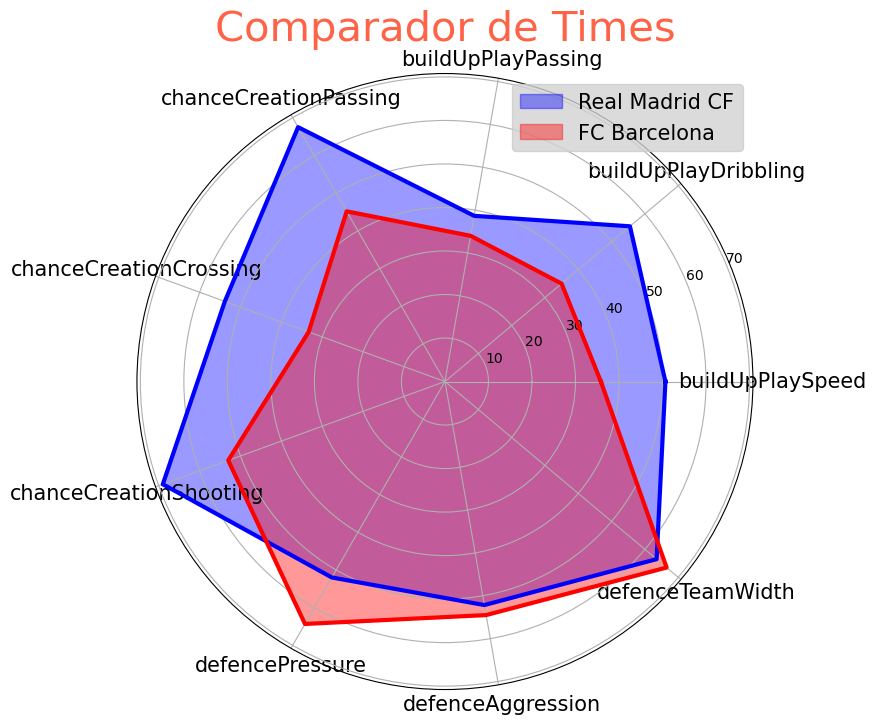

In [214]:
team_comparator("Real Madrid CF","FC Barcelona")

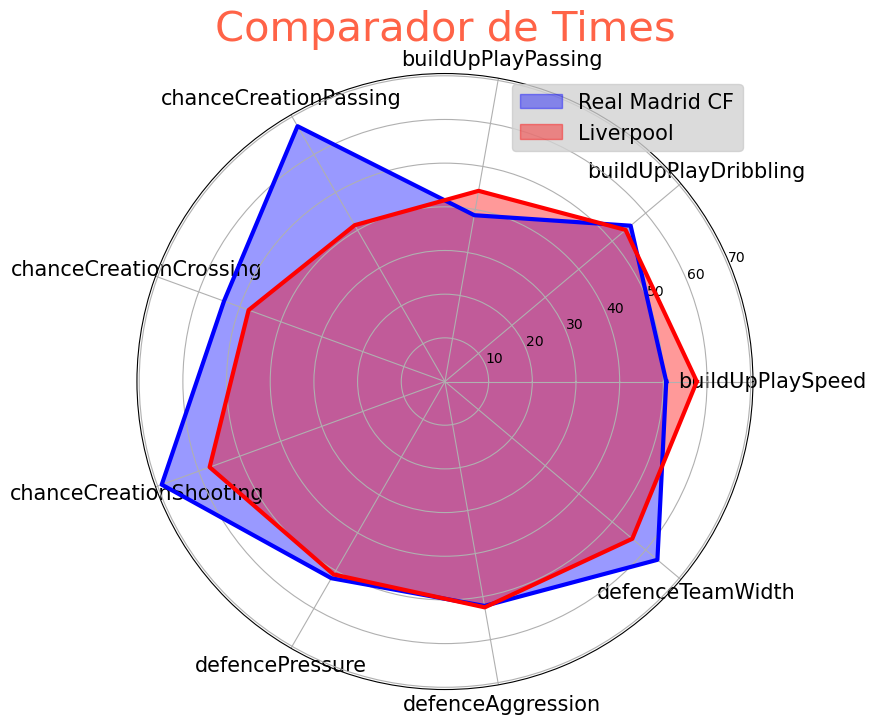

In [215]:
team_comparator("Real Madrid CF","Liverpool")

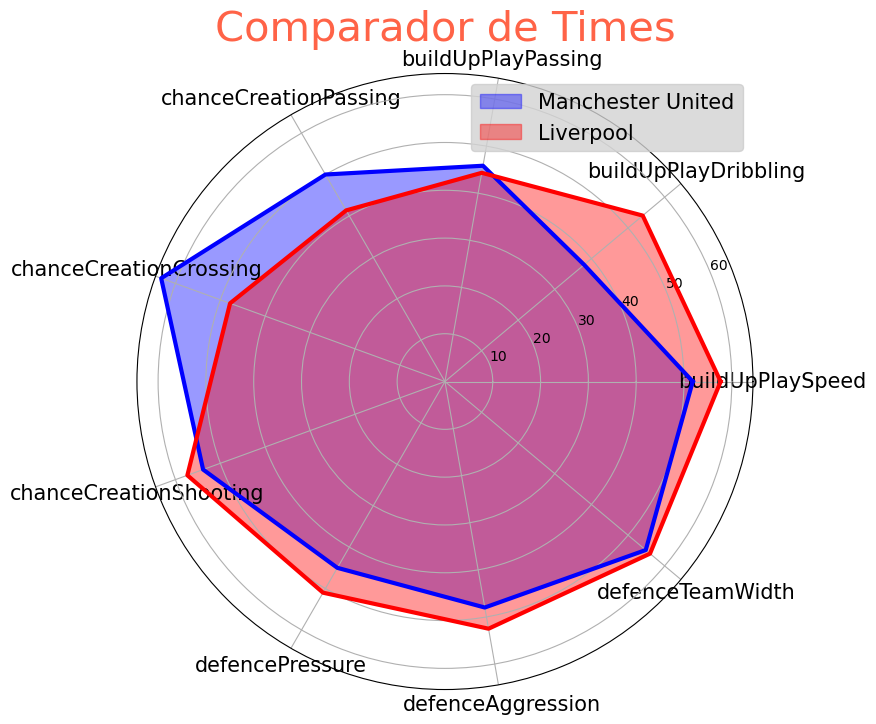

In [216]:
team_comparator("Manchester United","Liverpool")
plt.show()

# Econometria

Utilizaremos inicialmente o ``statsmodels``, ``sklearn`` e ``scipy``

In [284]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from numpy import NaN

from sklearn import linear_model

from scipy import stats

In [285]:
df = pd.read_stata("/Users/gustavorsampaio/Documents/Cursos/Python 2023.2/auto.dta")

In [286]:
df.head()

make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0    AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1      AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2     AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3  Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4  Buick Electra   7827   15    4.0       4.0     20    4080     222    43   

   displacement  gear_ratio   foreign  
0           121        3.58  Domestic  
1           258        2.53  Domestic  
2           121        3.08  Domestic  
3           196        2.93  Domestic  
4           350        2.41  Domestic

### Regressão usando StatsModels:

In [287]:
X = df["weight"]
y = df["price"]

In [288]:
X.head()

0    2930
1    3350
2    2640
3    3250
4    4080
Name: weight, dtype: int16

In [289]:
y.head()

0    4099
1    4749
2    3799
3    4816
4    7827
Name: price, dtype: int16

Inicialmente construimos o modelo e em seguida aplicamos a função ``fit()`` para "ajustar" a regressão

In [290]:
model = sm.OLS(y, X)

In [291]:
model

In [292]:
result = model.fit()

In [293]:
result

In [294]:
model

Podemos, agora, observar os dados da regressão

In [295]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):               30797.616
Model:                            OLS   Adj. R-squared (uncentered):          31219.488
Method:                 Least Squares   F-statistic:                             -73.00
Date:                Mon, 30 Oct 2023   Prob (F-statistic):                        1.00
Time:                        11:47:37   Log-Likelihood:                         -683.04
No. Observations:                  74   AIC:                                      1368.
Df Residuals:                      73   BIC:                                      1370.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

E podemos utilizar o resultado para realizar previsões

In [296]:
4000*2.0420

8167.999999999999

In [297]:
result.predict([4000,3490])

array([8167.90994295, 7126.50142523])

In [298]:
predictions = result.predict(X)

In [299]:
predictions.head()

0    5982.994033
1    6840.624577
2    5390.820562
3    6636.426829
4    8331.268142
dtype: float64

In [300]:
y.head()

0    4099
1    4749
2    3799
3    4816
4    7827
Name: price, dtype: int16

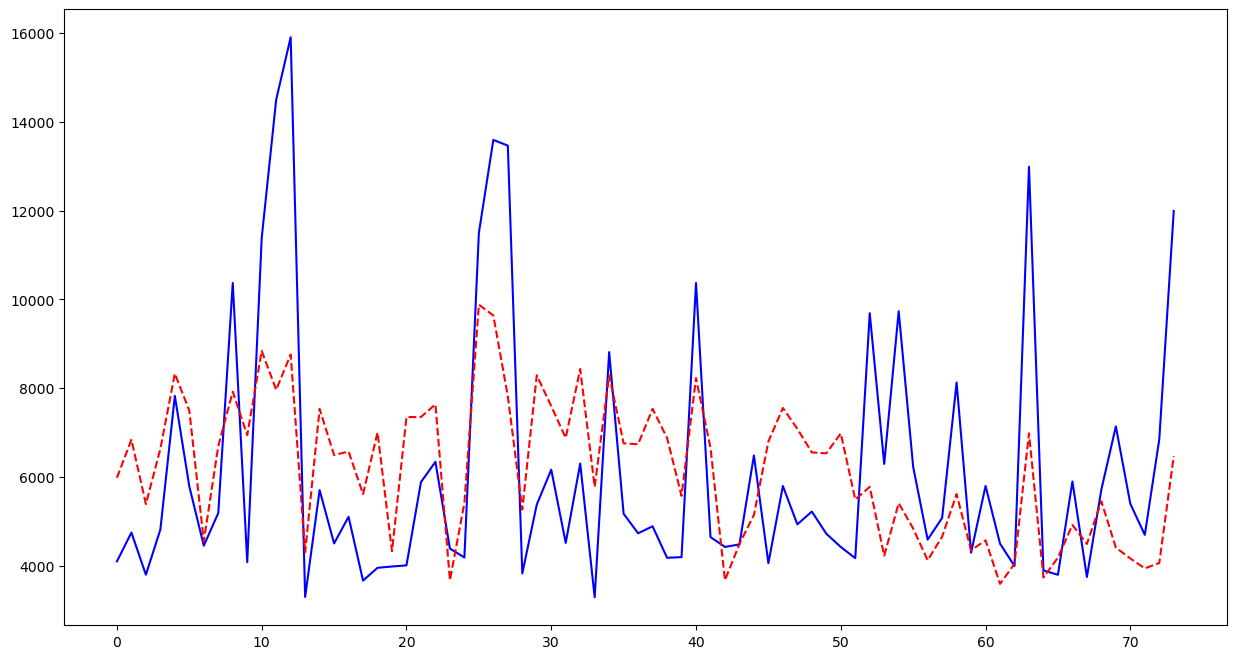

In [301]:
fig = plt.figure(figsize=(15,8))
plt.plot(range(0,len(y)), y.tolist(), 'b')
plt.plot(range(0,len(y)), predictions.tolist(), 'r--')
plt.show()

Observem que o modelo anterior não possui constante. Temos que adicionar manualmente

In [302]:
X

0     2930
1     3350
2     2640
3     3250
4     4080
      ... 
69    2160
70    2040
71    1930
72    1990
73    3170
Name: weight, Length: 74, dtype: int16

In [303]:
X = sm.add_constant(X)

In [304]:
X.head()

const  weight
0    1.0    2930
1    1.0    3350
2    1.0    2640
3    1.0    3250
4    1.0    4080

In [305]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     29.42
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           7.42e-07
Time:                        12:03:03   Log-Likelihood:                -683.04
No. Observations:                  74   AIC:                             1370.
Df Residuals:                      72   BIC:                             1375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7074   1174.430     -0.006      0.9

In [309]:
predictions.head()

0    5982.396023
1    6840.902309
2    5389.617873
3    6636.496050
4    8333.067996
dtype: float64

In [310]:
y.head()

0    4099
1    4749
2    3799
3    4816
4    7827
Name: price, dtype: int16

Podemos incluir mais de uma variável. Basta construir X com o número de variáveis desejadas

In [311]:
X = df[["weight", "length"]]

In [312]:
X

weight  length
0     2930     186
1     3350     173
2     2640     168
3     3250     196
4     4080     222
..     ...     ...
69    2160     172
70    2040     155
71    1930     155
72    1990     156
73    3170     193

[74 rows x 2 columns]

In [313]:
X = sm.add_constant(X)

In [314]:
X.head()

const  weight  length
0    1.0    2930     186
1    1.0    3350     173
2    1.0    2640     168
3    1.0    3250     196
4    1.0    4080     222

In [315]:
y = df["price"]

In [316]:
model = sm.OLS(y, X).fit()
#predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     18.91
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           2.61e-07
Time:                        12:04:59   Log-Likelihood:                -679.91
No. Observations:                  74   AIC:                             1366.
Df Residuals:                      71   BIC:                             1373.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.039e+04   4308.159      2.411      0.0

Ou utilizar todas as variáveis e dropar missings

In [318]:
df

make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0     AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1       AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2      AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3   Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4   Buick Electra   7827   15    4.0       4.0     20    4080     222    43   
..            ...    ...  ...    ...       ...    ...     ...     ...   ...   
69      VW Dasher   7140   23    4.0       2.5     12    2160     172    36   
70      VW Diesel   5397   41    5.0       3.0     15    2040     155    35   
71      VW Rabbit   4697   25    4.0       3.0     15    1930     155    35   
72    VW Scirocco   6850   25    4.0       2.0     16    1990     156    36   
73      Volvo 260  11995   17    5.0       2.5     14    3170     193    37   

    displacement  gear_ratio   foreign  
0            121        3.58  Domestic  
1            258        2.53  Domestic  
2            121        3.08  Domestic  
3            196        2.93  Domestic  
4            350        2.41  Domestic  
..           ...         ...       ...  
69            97        3.74   Foreign  
70            90        3.78   Foreign  
71            89        3.78   Foreign  
72            97        3.78   Foreign  
73           163        2.98   Foreign  

[74 rows x 12 columns]

In [320]:
y = df["price"]

In [321]:
df1 = df.drop("price",axis=1)
df1 = df1.drop("make",1)
df1 = df1.drop("foreign",1)

In [322]:
X = df1
X = sm.add_constant(X)

In [324]:
X.head()

const  mpg  rep78  headroom  trunk  weight  length  turn  displacement  \
0    1.0   22    3.0       2.5     11    2930     186    40           121   
1    1.0   17    3.0       3.0     11    3350     173    40           258   
2    1.0   22    NaN       3.0     12    2640     168    35           121   
3    1.0   20    3.0       4.5     16    3250     196    40           196   
4    1.0   15    4.0       4.0     20    4080     222    43           350   

   gear_ratio  
0        3.58  
1        2.53  
2        3.08  
3        2.93  
4        2.41

In [325]:
model = sm.OLS(y, X)

MissingDataError: exog contains inf or nans

In [326]:
model = sm.OLS(y, X, missing='drop')

In [327]:
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     6.958
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           9.13e-07
Time:                        12:15:22   Log-Likelihood:                -622.84
No. Observations:                  69   AIC:                             1266.
Df Residuals:                      59   BIC:                             1288.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.106e+04   7305.303      1.514   

In [328]:
predictions

0     5346.525963
1     8902.576564
2             NaN
3     5102.017301
4     9268.812307
         ...     
69    4781.303249
70    4381.596141
71    5046.180422
72    5925.169312
73    8265.236555
Length: 74, dtype: float64

In [329]:
y

0      4099
1      4749
2      3799
3      4816
4      7827
      ...  
69     7140
70     5397
71     4697
72     6850
73    11995
Name: price, Length: 74, dtype: int16

Como já vimos anteriormente, podemos construir dummies e inclui-las na regressão

In [330]:
y = df["price"]
df1 = df.drop("price",1)
df1 = df1.drop("make",1)
df1 = df1.drop("foreign",1)

In [331]:
df1.head()

mpg  rep78  headroom  trunk  weight  length  turn  displacement  gear_ratio
0   22    3.0       2.5     11    2930     186    40           121        3.58
1   17    3.0       3.0     11    3350     173    40           258        2.53
2   22    NaN       3.0     12    2640     168    35           121        3.08
3   20    3.0       4.5     16    3250     196    40           196        2.93
4   15    4.0       4.0     20    4080     222    43           350        2.41

In [43]:
df

make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0     AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1       AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2      AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3   Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4   Buick Electra   7827   15    4.0       4.0     20    4080     222    43   
..            ...    ...  ...    ...       ...    ...     ...     ...   ...   
69      VW Dasher   7140   23    4.0       2.5     12    2160     172    36   
70      VW Diesel   5397   41    5.0       3.0     15    2040     155    35   
71      VW Rabbit   4697   25    4.0       3.0     15    1930     155    35   
72    VW Scirocco   6850   25    4.0       2.0     16    1990     156    36   
73      Volvo 260  11995   17    5.0       2.5     14    3170     193    37   

    displacement  gear_ratio   foreign  
0            121        3.58  Domestic  
1            258        2.53  Domestic  
2            121        3.08  Domestic  
3            196        2.93  Domestic  
4            350        2.41  Domestic  
..           ...         ...       ...  
69            97        3.74   Foreign  
70            90        3.78   Foreign  
71            89        3.78   Foreign  
72            97        3.78   Foreign  
73           163        2.98   Foreign  

[74 rows x 12 columns]

In [332]:
dummie_foreign = pd.get_dummies(df['foreign'], prefix='dum')

In [333]:
dummie_foreign

dum_Domestic  dum_Foreign
0              1            0
1              1            0
2              1            0
3              1            0
4              1            0
..           ...          ...
69             0            1
70             0            1
71             0            1
72             0            1
73             0            1

[74 rows x 2 columns]

In [334]:
X = pd.concat([df1, dummie_foreign], axis=1)

In [335]:
X.head()

mpg  rep78  headroom  trunk  weight  length  turn  displacement  \
0   22    3.0       2.5     11    2930     186    40           121   
1   17    3.0       3.0     11    3350     173    40           258   
2   22    NaN       3.0     12    2640     168    35           121   
3   20    3.0       4.5     16    3250     196    40           196   
4   15    4.0       4.0     20    4080     222    43           350   

   gear_ratio  dum_Domestic  dum_Foreign  
0        3.58             1            0  
1        2.53             1            0  
2        3.08             1            0  
3        2.93             1            0  
4        2.41             1            0

In [336]:
X = X.drop("dum_Foreign",1)

In [337]:
X.head()

mpg  rep78  headroom  trunk  weight  length  turn  displacement  \
0   22    3.0       2.5     11    2930     186    40           121   
1   17    3.0       3.0     11    3350     173    40           258   
2   22    NaN       3.0     12    2640     168    35           121   
3   20    3.0       4.5     16    3250     196    40           196   
4   15    4.0       4.0     20    4080     222    43           350   

   gear_ratio  dum_Domestic  
0        3.58             1  
1        2.53             1  
2        3.08             1  
3        2.93             1  
4        2.41             1

In [338]:
model = sm.OLS(y, X, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):               11232.670
Model:                            OLS   Adj. R-squared (uncentered):          13136.342
Method:                 Least Squares   F-statistic:                             -5.901
Date:                Mon, 30 Oct 2023   Prob (F-statistic):                        1.00
Time:                        12:16:58   Log-Likelihood:                         -618.48
No. Observations:                  69   AIC:                                      1257.
Df Residuals:                      59   BIC:                                      1279.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Podemos utilizar a systaxe do R

In [339]:
dat = df

In [340]:
dat

make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0     AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1       AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2      AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3   Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4   Buick Electra   7827   15    4.0       4.0     20    4080     222    43   
..            ...    ...  ...    ...       ...    ...     ...     ...   ...   
69      VW Dasher   7140   23    4.0       2.5     12    2160     172    36   
70      VW Diesel   5397   41    5.0       3.0     15    2040     155    35   
71      VW Rabbit   4697   25    4.0       3.0     15    1930     155    35   
72    VW Scirocco   6850   25    4.0       2.0     16    1990     156    36   
73      Volvo 260  11995   17    5.0       2.5     14    3170     193    37   

    displacement  gear_ratio   foreign  
0            121        3.58  Domestic  
1            258        2.53  Domestic  
2            121        3.08  Domestic  
3            196        2.93  Domestic  
4            350        2.41  Domestic  
..           ...         ...       ...  
69            97        3.74   Foreign  
70            90        3.78   Foreign  
71            89        3.78   Foreign  
72            97        3.78   Foreign  
73           163        2.98   Foreign  

[74 rows x 12 columns]

In [341]:
results = smf.ols('np.log(price) ~ weight + length + foreign', data=dat).fit()

In [342]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     30.75
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           8.55e-13
Time:                        12:17:23   Log-Likelihood:                -4.1116
No. Observations:                  74   AIC:                             16.22
Df Residuals:                      70   BIC:                             25.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.9251      0

# Regressão usando o Sklearn

In [343]:
X = df[["weight"]]
y = df["price"]

In [344]:
X.head()

weight
0    2930
1    3350
2    2640
3    3250
4    4080

In [345]:
lm = linear_model.LinearRegression()

In [346]:
lm

LinearRegression()

In [347]:
lm.fit(X,y)

LinearRegression()

In [348]:
model = lm.fit(X,y)

In [349]:
model

LinearRegression()

Recuperando os coeficientes, intercepto e $R^2$ 

In [350]:
lm.coef_

array([2.04406259])

In [351]:
lm.intercept_

-6.707353351664096

In [352]:
lm.score(X,y)

0.2901023076446272

In [353]:
lm.predict([[4000]])

array([8169.54298943])

In [354]:
X

weight
0     2930
1     3350
2     2640
3     3250
4     4080
..     ...
69    2160
70    2040
71    1930
72    1990
73    3170

[74 rows x 1 columns]

Podemos, também, realizar previsões

In [355]:
predictions = lm.predict(X)
print(predictions)

[5982.39602274 6840.90230873 5389.61787289 6636.49605016 8333.06799629
 7495.00233615 4551.55221275 6697.81792773 7924.25547915 6943.10543802
 8844.08364271 7965.13673086 8762.32113929 4306.26470247 7535.88358787
 6493.41166916 6575.17417259 5614.46475731 7004.42731559 4326.70532832
 7351.91795516 7351.91795516 7638.08671715 3672.6053009  5410.05849874
 9886.55556142 9641.26805114 7822.05234987 5266.97411775 8292.18674458
 7597.20546544 6881.78356045 8435.27112557 5777.98976417 8292.18674458
 6759.1398053  6738.69917945 7535.88358787 6881.78356045 5573.5835056
 8230.86486701 6656.93667602 3672.6053009  4490.23033518 5144.3303626
 6800.02105702 7556.32421373 7086.18981902 6554.73354673 6534.29292088
 6983.98668973 5491.82100217 5777.98976417 4224.50219904 5410.05849874
 4837.72097475 4122.29906976 4653.75534204 5614.46475731 4347.14595418
 4571.99283861 3590.84279747 4040.53656633 6983.98668973 3733.92717847
 4183.62094733 4919.48347818 4490.23033518 5450.93975046 4408.46783175
 4163.18

### plot da Regressão

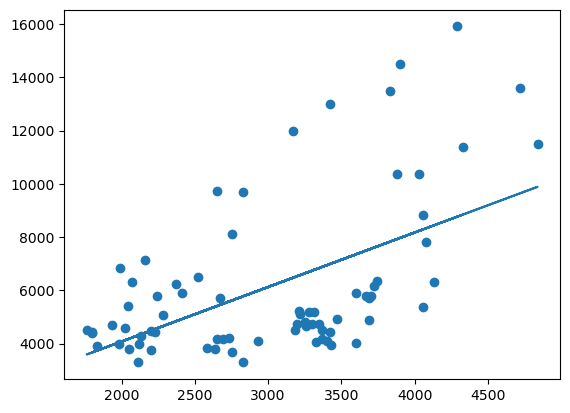

In [356]:
yfit = model.predict(X)
plt.scatter(X,y)
plt.plot(X,yfit)
plt.show()

# Regressão usando o Scipy

In [357]:
X = np.array([0,1,2,3,4,5])
Y = np.array([3,4, 5, 10, 2, 5])

In [358]:
stats.linregress(X,Y)

LinregressResult(slope=0.2571428571428572, intercept=4.19047619047619, rvalue=0.17262001662906243, pvalue=0.7436418122140313, stderr=0.7336424827646003, intercept_stderr=2.221212922723205)

## Regressão Linear Robusta

In [359]:
X = df[["weight"]]
y = df["price"]

In [360]:
model = sm.RLM(y, X, missing='drop', M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                   74
Model:                            RLM   Df Residuals:                       73
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Oct 2023                                         
Time:                        12:24:25                                         
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weight         1.9234      0.081     23.714      0.0

## Comparar OLS e RLM

``linspace``: Return evenly spaced numbers over a specified interval

In [369]:
np.linspace(0, 20, 50)

array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])

In [370]:
nsample = 50
x1 = np.linspace(0, 20, nsample)

In [371]:
x1

array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])

In [372]:
(x1-5)**2

array([2.50000000e+01, 2.10849646e+01, 1.75031237e+01, 1.42544773e+01,
       1.13390254e+01, 8.75676801e+00, 6.50770512e+00, 4.59183673e+00,
       3.00916285e+00, 1.75968347e+00, 8.43398584e-01, 2.60308205e-01,
       1.04123282e-02, 9.37109538e-02, 5.10204082e-01, 1.25989171e+00,
       2.34277384e+00, 3.75885048e+00, 5.50812162e+00, 7.59058726e+00,
       1.00062474e+01, 1.27551020e+01, 1.58371512e+01, 1.92523948e+01,
       2.30008330e+01, 2.70824656e+01, 3.14972928e+01, 3.62453145e+01,
       4.13265306e+01, 4.67409413e+01, 5.24885464e+01, 5.85693461e+01,
       6.49833403e+01, 7.17305289e+01, 7.88109121e+01, 8.62244898e+01,
       9.39712620e+01, 1.02051229e+02, 1.10464390e+02, 1.19210746e+02,
       1.28290296e+02, 1.37703040e+02, 1.47448980e+02, 1.57528113e+02,
       1.67940441e+02, 1.78685964e+02, 1.89764681e+02, 2.01176593e+02,
       2.12921699e+02, 2.25000000e+02])

In [373]:
X = np.column_stack((x1, (x1-5)**2))

In [374]:
X

array([[0.00000000e+00, 2.50000000e+01],
       [4.08163265e-01, 2.10849646e+01],
       [8.16326531e-01, 1.75031237e+01],
       [1.22448980e+00, 1.42544773e+01],
       [1.63265306e+00, 1.13390254e+01],
       [2.04081633e+00, 8.75676801e+00],
       [2.44897959e+00, 6.50770512e+00],
       [2.85714286e+00, 4.59183673e+00],
       [3.26530612e+00, 3.00916285e+00],
       [3.67346939e+00, 1.75968347e+00],
       [4.08163265e+00, 8.43398584e-01],
       [4.48979592e+00, 2.60308205e-01],
       [4.89795918e+00, 1.04123282e-02],
       [5.30612245e+00, 9.37109538e-02],
       [5.71428571e+00, 5.10204082e-01],
       [6.12244898e+00, 1.25989171e+00],
       [6.53061224e+00, 2.34277384e+00],
       [6.93877551e+00, 3.75885048e+00],
       [7.34693878e+00, 5.50812162e+00],
       [7.75510204e+00, 7.59058726e+00],
       [8.16326531e+00, 1.00062474e+01],
       [8.57142857e+00, 1.27551020e+01],
       [8.97959184e+00, 1.58371512e+01],
       [9.38775510e+00, 1.92523948e+01],
       [9.795918

In [375]:
X = sm.add_constant(X)

In [ ]:
Y = a + b*x1 + c*x2

In [377]:
X

array([[1.00000000e+00, 0.00000000e+00, 2.50000000e+01],
       [1.00000000e+00, 4.08163265e-01, 2.10849646e+01],
       [1.00000000e+00, 8.16326531e-01, 1.75031237e+01],
       [1.00000000e+00, 1.22448980e+00, 1.42544773e+01],
       [1.00000000e+00, 1.63265306e+00, 1.13390254e+01],
       [1.00000000e+00, 2.04081633e+00, 8.75676801e+00],
       [1.00000000e+00, 2.44897959e+00, 6.50770512e+00],
       [1.00000000e+00, 2.85714286e+00, 4.59183673e+00],
       [1.00000000e+00, 3.26530612e+00, 3.00916285e+00],
       [1.00000000e+00, 3.67346939e+00, 1.75968347e+00],
       [1.00000000e+00, 4.08163265e+00, 8.43398584e-01],
       [1.00000000e+00, 4.48979592e+00, 2.60308205e-01],
       [1.00000000e+00, 4.89795918e+00, 1.04123282e-02],
       [1.00000000e+00, 5.30612245e+00, 9.37109538e-02],
       [1.00000000e+00, 5.71428571e+00, 5.10204082e-01],
       [1.00000000e+00, 6.12244898e+00, 1.25989171e+00],
       [1.00000000e+00, 6.53061224e+00, 2.34277384e+00],
       [1.00000000e+00, 6.93877

In [378]:
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta) # multiplicar dois arrays

In [379]:
y_true2

array([ 5.        ,  5.20408163,  5.40816327,  5.6122449 ,  5.81632653,
        6.02040816,  6.2244898 ,  6.42857143,  6.63265306,  6.83673469,
        7.04081633,  7.24489796,  7.44897959,  7.65306122,  7.85714286,
        8.06122449,  8.26530612,  8.46938776,  8.67346939,  8.87755102,
        9.08163265,  9.28571429,  9.48979592,  9.69387755,  9.89795918,
       10.10204082, 10.30612245, 10.51020408, 10.71428571, 10.91836735,
       11.12244898, 11.32653061, 11.53061224, 11.73469388, 11.93877551,
       12.14285714, 12.34693878, 12.55102041, 12.75510204, 12.95918367,
       13.16326531, 13.36734694, 13.57142857, 13.7755102 , 13.97959184,
       14.18367347, 14.3877551 , 14.59183673, 14.79591837, 15.        ])

In [380]:
np.random.normal(size=nsample)*0.16

array([ 0.09329798,  0.2362679 ,  0.22065885,  0.18766147,  0.0533279 ,
        0.13590267, -0.07319251,  0.16744494, -0.26600914, -0.04681131,
       -0.11124302, -0.10830764, -0.11773577,  0.04988159, -0.13307869,
        0.1757451 ,  0.31907568, -0.17459179,  0.29218439, -0.08852729,
        0.31726633, -0.08056582, -0.23440918,  0.02517713,  0.02240408,
       -0.07162906,  0.07304995, -0.07886206,  0.15129214,  0.09053715,
       -0.13323695, -0.23912741, -0.01589564, -0.26679066, -0.11720708,
        0.14757919,  0.15109193, -0.10394387,  0.13840957, -0.01672779,
        0.26503234, -0.03191503,  0.30900467,  0.19228648, -0.18260035,
       -0.02792705,  0.01569502, -0.0785374 ,  0.06004661,  0.06006233])

In [381]:
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)

In [382]:
y2

array([ 4.61055824,  5.47093633,  5.58748757,  6.16801802,  5.67605352,
        5.64449817,  6.08588488,  6.2055199 ,  6.95897423,  7.24932859,
        7.04265075,  7.45740593,  7.35393818,  8.00739842,  8.4243716 ,
        7.69081692,  8.59111965,  8.54488383,  9.39324227,  8.90504682,
        9.72307164,  9.20891466,  9.33664805,  9.49015386,  9.51700225,
       10.07366597, 10.22965048, 10.28254981, 10.65827087, 10.71628954,
       11.41664843, 11.47477223, 11.3806107 , 12.21463128, 12.10044585,
       12.31755697, 12.15109613, 12.20797562, 12.91311114, 13.09449306,
       13.18424327, 13.41053409, 13.63997003, 13.38342206, 13.8398599 ,
       14.22663212, 13.74838368, 14.63113845, 14.85090863, 14.81019598])

In [383]:
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

In [384]:
y2

array([ 4.61055824,  5.47093633,  5.58748757,  6.16801802,  5.67605352,
        5.64449817,  6.08588488,  6.2055199 ,  6.95897423,  7.24932859,
        7.04265075,  7.45740593,  7.35393818,  8.00739842,  8.4243716 ,
        7.69081692,  8.59111965,  8.54488383,  9.39324227,  8.90504682,
        9.72307164,  9.20891466,  9.33664805,  9.49015386,  9.51700225,
       10.07366597, 10.22965048, 10.28254981, 10.65827087, 10.71628954,
       11.41664843, 11.47477223, 11.3806107 , 12.21463128, 12.10044585,
       12.31755697, 12.15109613, 12.20797562, 12.91311114,  8.09449306,
       13.18424327,  8.41053409, 13.63997003,  8.38342206, 13.8398599 ,
        9.22663212, 13.74838368, 14.63113845,  9.85090863, 14.81019598])

In [385]:
res = sm.OLS(y2, X).fit()
print(res.params)

[ 5.14483878  0.52484199 -0.01452811]


In [386]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)

[ 5.08028652e+00  5.10286031e-01 -4.29970184e-03]


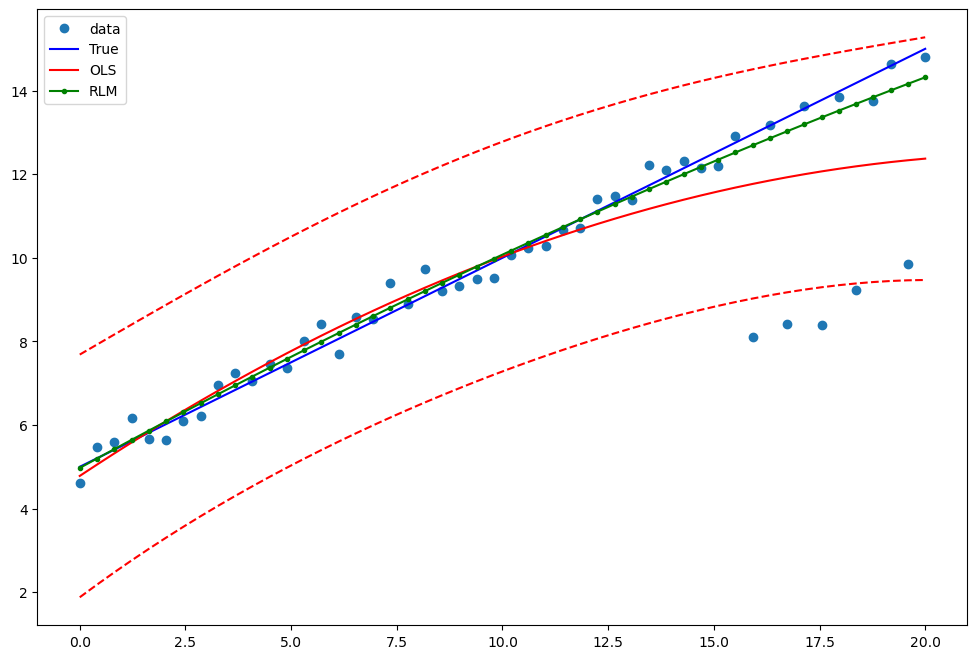

In [387]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")
plt.show()

## Logit e Probit

In [388]:
dummie_foreign = pd.get_dummies(df['foreign'],prefix='foreign')

In [389]:
dummie_foreign

foreign_Domestic  foreign_Foreign
0                  1                0
1                  1                0
2                  1                0
3                  1                0
4                  1                0
..               ...              ...
69                 0                1
70                 0                1
71                 0                1
72                 0                1
73                 0                1

[74 rows x 2 columns]

In [398]:
Y = dummie_foreign["foreign_Domestic"]

In [399]:
Y

0     1
1     1
2     1
3     1
4     1
     ..
69    0
70    0
71    0
72    0
73    0
Name: foreign_Domestic, Length: 74, dtype: uint8

In [400]:
X = df[["weight", "length"]]
X = sm.add_constant(X)

In [392]:
X

array([[1.00000000e+00, 0.00000000e+00, 2.50000000e+01],
       [1.00000000e+00, 4.08163265e-01, 2.10849646e+01],
       [1.00000000e+00, 8.16326531e-01, 1.75031237e+01],
       [1.00000000e+00, 1.22448980e+00, 1.42544773e+01],
       [1.00000000e+00, 1.63265306e+00, 1.13390254e+01],
       [1.00000000e+00, 2.04081633e+00, 8.75676801e+00],
       [1.00000000e+00, 2.44897959e+00, 6.50770512e+00],
       [1.00000000e+00, 2.85714286e+00, 4.59183673e+00],
       [1.00000000e+00, 3.26530612e+00, 3.00916285e+00],
       [1.00000000e+00, 3.67346939e+00, 1.75968347e+00],
       [1.00000000e+00, 4.08163265e+00, 8.43398584e-01],
       [1.00000000e+00, 4.48979592e+00, 2.60308205e-01],
       [1.00000000e+00, 4.89795918e+00, 1.04123282e-02],
       [1.00000000e+00, 5.30612245e+00, 9.37109538e-02],
       [1.00000000e+00, 5.71428571e+00, 5.10204082e-01],
       [1.00000000e+00, 6.12244898e+00, 1.25989171e+00],
       [1.00000000e+00, 6.53061224e+00, 2.34277384e+00],
       [1.00000000e+00, 6.93877

In [401]:
df

make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0     AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1       AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2      AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3   Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4   Buick Electra   7827   15    4.0       4.0     20    4080     222    43   
..            ...    ...  ...    ...       ...    ...     ...     ...   ...   
69      VW Dasher   7140   23    4.0       2.5     12    2160     172    36   
70      VW Diesel   5397   41    5.0       3.0     15    2040     155    35   
71      VW Rabbit   4697   25    4.0       3.0     15    1930     155    35   
72    VW Scirocco   6850   25    4.0       2.0     16    1990     156    36   
73      Volvo 260  11995   17    5.0       2.5     14    3170     193    37   

    displacement  gear_ratio   foreign  
0            121        3.58  Domestic  
1            258        2.53  Domestic  
2            121        3.08  Domestic  
3            196        2.93  Domestic  
4            350        2.41  Domestic  
..           ...         ...       ...  
69            97        3.74   Foreign  
70            90        3.78   Foreign  
71            89        3.78   Foreign  
72            97        3.78   Foreign  
73           163        2.98   Foreign  

[74 rows x 12 columns]

In [402]:
Y

0     1
1     1
2     1
3     1
4     1
     ..
69    0
70    0
71    0
72    0
73    0
Name: foreign_Domestic, Length: 74, dtype: uint8

In [403]:
logit_mod = sm.Logit(Y, X)

In [404]:
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 48.238428
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       foreign_Domestic   No. Observations:                   74
Model:                          Logit   Df Residuals:                       71
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                     inf
Time:                        13:16:29   Log-Likelihood:                -3569.6
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3662      5.775     -0.929      0.353     -16.686       5.953
weight         0.0028      0

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [405]:
print(logit_res.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: inf      
Dependent Variable: foreign_Domestic AIC:              7145.2873
Date:               2023-10-30 13:16 BIC:              7152.1995
No. Observations:   74               Log-Likelihood:   -3569.6  
Df Model:           2                LL-Null:          0.0000   
Df Residuals:       71               LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
const    -5.3662     5.7753   -0.9292   0.3528   -16.6857   5.9532
weight    0.0028     0.0017    1.6953   0.0900    -0.0004   0.0061
length   -0.0089     0.0543   -0.1643   0.8695    -0.1153   0.0975



In [406]:
probit_mod = sm.Probit(Y, X)
probit_res = probit_mod.fit()
print(probit_res.summary2())

         Current function value: 0.000000
         Iterations: 35
                          Results: Probit
Model:                Probit           Pseudo R-squared: inf        
Dependent Variable:   foreign_Domestic AIC:              6.0000     
Date:                 2023-10-30 13:16 BIC:              12.9122    
No. Observations:     74               Log-Likelihood:   -2.7587e-12
Df Model:             2                LL-Null:          0.0000     
Df Residuals:         71               LLR p-value:      1.0000     
Converged:            0.0000           Scale:            1.0000     
No. Iterations:       35.0000                                       
--------------------------------------------------------------------
        Coef.    Std.Err.     z    P>|z|      [0.025       0.975]   
--------------------------------------------------------------------
const   5.8513 944136.3094  0.0000 1.0000 -1850467.3116 1850479.0142
weight -0.0011    499.7307 -0.0000 1.0000     -979.4552     979.

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Em Logit e Probit, não estamos interessados nos coeficientes da regressão em si. Mas nos efeitos marginais

In [407]:
print(probit_res.get_margeff(at='overall', method='dydx').summary())

       Probit Marginal Effects       
Dep. Variable:       foreign_Domestic
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weight     -2.884e-16   2.17e-10  -1.33e-06      1.000   -4.24e-10    4.24e-10
length      7.634e-15   5.73e-09   1.33e-06      1.000   -1.12e-08    1.12e-08


In [408]:
X

const  weight  length
0     1.0    2930     186
1     1.0    3350     173
2     1.0    2640     168
3     1.0    3250     196
4     1.0    4080     222
..    ...     ...     ...
69    1.0    2160     172
70    1.0    2040     155
71    1.0    1930     155
72    1.0    1990     156
73    1.0    3170     193

[74 rows x 3 columns]

In [409]:
predictions = probit_res.predict([[1.0, 1020, 182]])

In [410]:
predictions

array([1.])

# Regressão Quantílica

Gerar dados com variância constante

loc : Mean (“centre”) of the distribution.

scale : Standard deviation (spread or “width”) of the distribution.


In [411]:
import numpy as np
x = np.arange(100).reshape(100,1)

In [413]:
print(x)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]
 [50]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [57]
 [58]
 [59]
 [60]
 [61]
 [62]
 [63]
 [64]
 [65]
 [66]
 [67]
 [68]
 [69]
 [70]
 [71]
 [72]
 [73]
 [74]
 [75]
 [76]
 [77]
 [78]
 [79]
 [80]
 [81]
 [82]
 [83]
 [84]
 [85]
 [86]
 [87]
 [88]
 [89]
 [90]
 [91]
 [92]
 [93]
 [94]
 [95]
 [96]
 [97]
 [98]
 [99]]


In [414]:
intercept_ = 6 
slope_ = 0.1 

In [ ]:
Y = a + b.X + erro

In [417]:
## erro não constante 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = 1) 

In [418]:
error_

array([[ 0.24381931],
       [ 0.78672738],
       [-0.13068078],
       [-0.99100853],
       [ 0.33513445],
       [ 1.01842939],
       [-0.35851391],
       [-1.13857128],
       [ 0.66604746],
       [-0.07082449],
       [ 1.09736512],
       [ 0.02037948],
       [-1.67069815],
       [-0.64093828],
       [ 1.87563937],
       [-0.15119861],
       [ 0.99492971],
       [-1.51652098],
       [-1.5210682 ],
       [-0.82189356],
       [ 0.25121408],
       [-0.49009955],
       [-0.96561221],
       [-0.17546265],
       [-0.0378059 ],
       [-0.48255421],
       [ 0.53815673],
       [-1.20171906],
       [ 0.60792811],
       [-1.39067821],
       [ 0.40547045],
       [-0.48385478],
       [-0.8644347 ],
       [ 0.25749007],
       [ 1.45882405],
       [-0.3354988 ],
       [ 2.00031992],
       [ 1.34694318],
       [ 0.69569743],
       [-0.52048271],
       [ 1.00287887],
       [-0.54205366],
       [-0.28767513],
       [ 0.22510299],
       [ 0.34726655],
       [ 0

In [419]:
## Equação da Regressão 
y = intercept_ + slope_ * x + error_  

In [420]:
y

array([[ 6.24381931],
       [ 6.88672738],
       [ 6.06931922],
       [ 5.30899147],
       [ 6.73513445],
       [ 7.51842939],
       [ 6.24148609],
       [ 5.56142872],
       [ 7.46604746],
       [ 6.82917551],
       [ 8.09736512],
       [ 7.12037948],
       [ 5.52930185],
       [ 6.65906172],
       [ 9.27563937],
       [ 7.34880139],
       [ 8.59492971],
       [ 6.18347902],
       [ 6.2789318 ],
       [ 7.07810644],
       [ 8.25121408],
       [ 7.60990045],
       [ 7.23438779],
       [ 8.12453735],
       [ 8.3621941 ],
       [ 8.01744579],
       [ 9.13815673],
       [ 7.49828094],
       [ 9.40792811],
       [ 7.50932179],
       [ 9.40547045],
       [ 8.61614522],
       [ 8.3355653 ],
       [ 9.55749007],
       [10.85882405],
       [ 9.1645012 ],
       [11.60031992],
       [11.04694318],
       [10.49569743],
       [ 9.37951729],
       [11.00287887],
       [ 9.55794634],
       [ 9.91232487],
       [10.52510299],
       [10.74726655],
       [10

In [421]:
x[0:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [422]:
error_[0:5]

array([[ 0.24381931],
       [ 0.78672738],
       [-0.13068078],
       [-0.99100853],
       [ 0.33513445]])

In [423]:
y[0:5]

array([[6.24381931],
       [6.88672738],
       [6.06931922],
       [5.30899147],
       [6.73513445]])

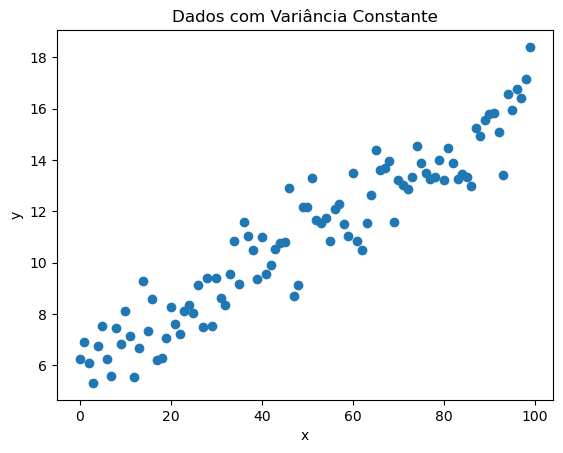

In [424]:
plt.figure(1) 
plt.scatter(x, y) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Dados com Variância Constante")
plt.show()

Vamos rodar uma OLS nos dados acima

In [425]:
model1 = linear_model.LinearRegression(fit_intercept = True, normalize = False) 
res = model1.fit(x, y)

In [426]:
res.coef_

array([[0.10357862]])

In [427]:
res.intercept_

array([5.90475887])

In [428]:
y_pred1 = res.predict(x)

In [429]:
y_pred1[0:5]

array([[5.90475887],
       [6.00833748],
       [6.1119161 ],
       [6.21549472],
       [6.31907334]])

In [430]:
y[0:5]

array([[6.24381931],
       [6.88672738],
       [6.06931922],
       [5.30899147],
       [6.73513445]])

In [431]:
ols = model1.coef_

In [432]:
ols

array([[0.10357862]])

In [433]:
print("Mean squared error: {0:.2f}".format(np.mean((y_pred1 - y) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x, y)))

Mean squared error: 0.98
Variance score: 0.90


Vamos plotar a regressão

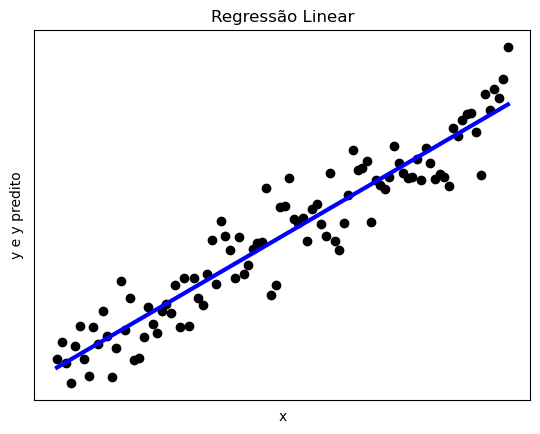

In [434]:
plt.figure(2) 
plt.scatter(x, y, color='black') 
plt.plot(x, y_pred1, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Linear")
plt.show()

Vamos agora gerar dados com variância não constante

In [435]:
x_ = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 
## Variância não constante 
var_ = 0.1 + 0.05 * x_ 
## erro não constante 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = var_) 

In [436]:
x_[0:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [437]:
var_[0:5]

array([[0.1 ],
       [0.15],
       [0.2 ],
       [0.25],
       [0.3 ]])

In [438]:
error_[0:5]

array([[-0.0244595 ],
       [ 0.15788018],
       [-0.33884807],
       [ 0.02748129],
       [ 0.21244733]])

In [439]:
## Equação da Regressão 
y_ = intercept_ + slope_ * x + error_  

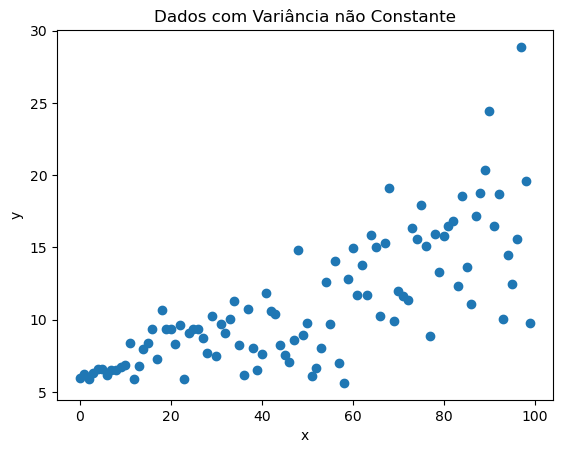

In [440]:
plt.figure(3) 
plt.scatter(x_, y_) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Dados com Variância não Constante")
plt.show()

Vamos tentar ajustar uma regressão linear

In [441]:
model2 = linear_model.LinearRegression(fit_intercept = True, normalize = False) 
res2 = model2.fit(x_, y_)

In [442]:
y_pred2 = res2.predict(x_)

In [443]:
y_pred2[0:5]

array([[5.39303424],
       [5.50917496],
       [5.62531569],
       [5.74145642],
       [5.85759714]])

In [444]:
ols2 = res2.coef_

In [445]:
print(ols2)

[[0.11614073]]


In [446]:
print("Mean squared error: {0:.2f}".format(np.mean((y_pred2 - y_) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x_, y_)))

Mean squared error: 8.64
Variance score: 0.56


Vamos plotar a regressão

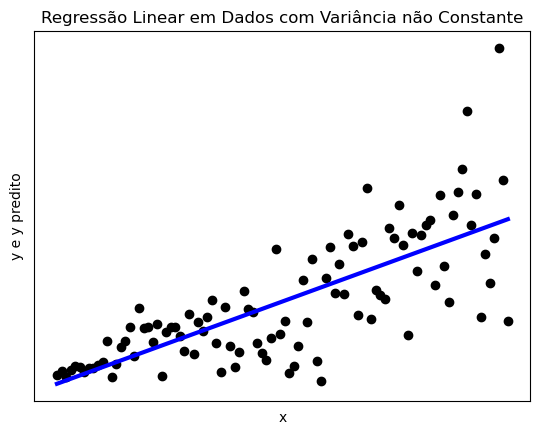

In [447]:
plt.figure(4) 
plt.scatter(x_, y_, color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Linear em Dados com Variância não Constante")
plt.show()

Vamos, agora, rodar uma Regressão Quantílica para a mediana dos dados (Quantil 0.5)

In [448]:
data = pd.DataFrame(data = np.hstack([x_, y_]), columns = ["x", "y"]) 

In [449]:
data.head()

x         y
0  0.0  5.975540
1  1.0  6.257880
2  2.0  5.861152
3  3.0  6.327481
4  4.0  6.612447

In [450]:
mod = smf.quantreg('y ~ x', data)

In [451]:
mod

In [452]:
res = mod.fit(q=.5) 
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3727
Model:                       QuantReg   Bandwidth:                       2.985
Method:                 Least Squares   Sparsity:                        7.041
Date:                Mon, 30 Oct 2023   No. Observations:                  100
Time:                        13:19:15   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7037      0.699      8.161      0.000       4.317       7.091
x              0.1182      0.012      9.695      0.000       0.094       0.142


In [453]:
ols2

array([[0.11614073]])

In [454]:
res.params['x']

0.11823575038755765

In [455]:
res.conf_int()

0         1
Intercept  4.316789  7.090520
x          0.094033  0.142439

Construir o modelo para outros quantis

In [151]:
quantiles = np.arange(0.1,1,0.1) 
print(quantiles) 

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [152]:
models = [] 
params = []  
for qt in quantiles:  
    print(qt)  
    res = mod.fit(q = qt )
    models.append(res)
    params.append([qt, res.params['Intercept'], res.params['x']] + [res.conf_int()[0]['x'],res.conf_int()[1]['x']])

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [153]:
params

[[0.1,
  5.990758940076958,
  0.03144701370580994,
  0.011948617947386189,
  0.05094540946423369],
 [0.2,
  5.9226995877547575,
  0.05643061803980748,
  0.03955384422774083,
  0.07330739185187413],
 [0.30000000000000004,
  6.0052229717699355,
  0.06622521177146,
  0.04847287253954434,
  0.08397755100337566],
 [0.4,
  5.998075421846722,
  0.07773751396950128,
  0.058675970289814444,
  0.09679905764918811],
 [0.5,
  5.896743142882402,
  0.09604119777717506,
  0.07620008250953145,
  0.11588231304481866],
 [0.6000000000000001,
  5.992875142596371,
  0.10729624613332461,
  0.086821227081709,
  0.12777126518494022],
 [0.7000000000000001,
  5.99698264563074,
  0.12855110984463924,
  0.10718591645774819,
  0.1499163032315303],
 [0.8,
  5.957540709422647,
  0.14263085110482257,
  0.11843407981628148,
  0.16682762239336366],
 [0.9,
  6.025993804290349,
  0.1561398757371648,
  0.13211286520943605,
  0.18016688626489358]]

In [77]:
res.conf_int()[0]['x']

0.017188179320732327

In [ ]:
models

In [154]:
params = pd.DataFrame(data = params, columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])  
print(params)

    qt  intercept    x_coef  cf_lower_bound  cf_upper_bound
0  0.1   5.990759  0.031447        0.011949        0.050945
1  0.2   5.922700  0.056431        0.039554        0.073307
2  0.3   6.005223  0.066225        0.048473        0.083978
3  0.4   5.998075  0.077738        0.058676        0.096799
4  0.5   5.896743  0.096041        0.076200        0.115882
5  0.6   5.992875  0.107296        0.086821        0.127771
6  0.7   5.996983  0.128551        0.107186        0.149916
7  0.8   5.957541  0.142631        0.118434        0.166828
8  0.9   6.025994  0.156140        0.132113        0.180167


Plot dos dados e de cada regressão

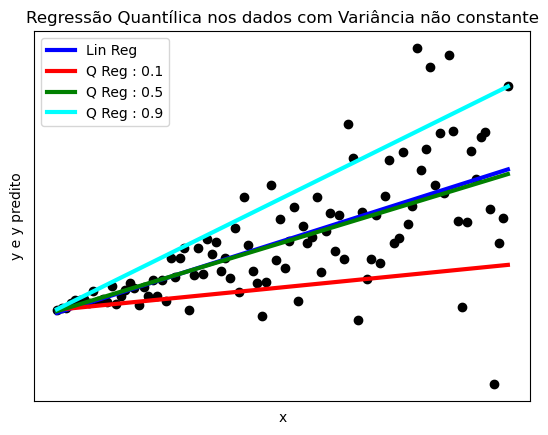

In [155]:
plt.figure(5) 
plt.scatter(x_, y_,  color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3, label='Lin Reg')  
y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x_ 
plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.1')  
y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x_ 
plt.plot(x_, y_pred4, color='green', linewidth=3, label='Q Reg : 0.5')   
y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x_ 
plt.plot(x_, y_pred5, color='cyan', linewidth=3, label='Q Reg : 0.9')   
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Quantílica nos dados com Variância não constante") 
plt.legend()
plt.show()

Plotar mudanças nos coeficientes dos quantís

In [157]:
ols2

array([[0.10055082]])

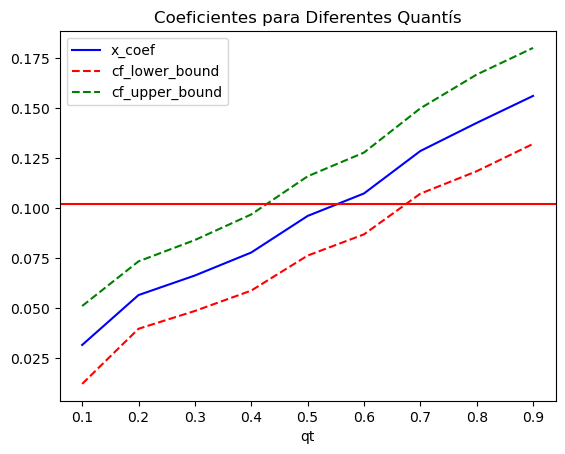

In [156]:
params.plot(x = 'qt', y = ['x_coef','cf_lower_bound', 'cf_upper_bound'], title = 'Coeficientes para Diferentes Quantís', kind ='line', style = ['b-','r--','g--'])
plt.axhline(y=ols, color='r', linestyle='-')
plt.show()